# TOPIC EXTRACTION AND SUMMARIZATION OF COMMENTS

In [1]:
import pandas as pd

# Read the .csv file
data_def = pd.read_csv('data/ministryofdefence_final.csv')
my_cols = data_def.columns.to_list()
print(my_cols)

['16181', 'term_id', 'name', 'post_title', 'comment_content', 'word_count', 'has_emoji', 'tok_comments', 'tok_comments_no_stopwords', 'tok_comments_with_stopwords', 'comments_no_stopwords', 'comments_with_stopwords', 'lemmatized_comments_no_stopwords', 'word_count_no_stopwords', 'ner_entities', 'pos_tags_no_stopwords']


In [2]:
import numpy as np


def extract_comments_for_article(df, column, article):
    df_article = df[df[column] == article] 
    return df_article

# Extract the comments for a random article for term_id=74
df_74 = data_def[data_def['term_id'] == 74]
articles_74 = np.unique(df_74[my_cols[3]])

df_74_01 = extract_comments_for_article(df_74, my_cols[3], articles_74[0])
print(f'Number of comments for article: "{articles_74[0]}" is: {len(df_74_01)}')

Number of comments for article: "Άρθρο 01 - Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" is: 123


['Ρυθμίσεις περί σταδιοδρομίας και εξέλιξης στελεχών και οικονομικής μέριμνας και λογιστικού των Ενόπλων Δυνάμεων']


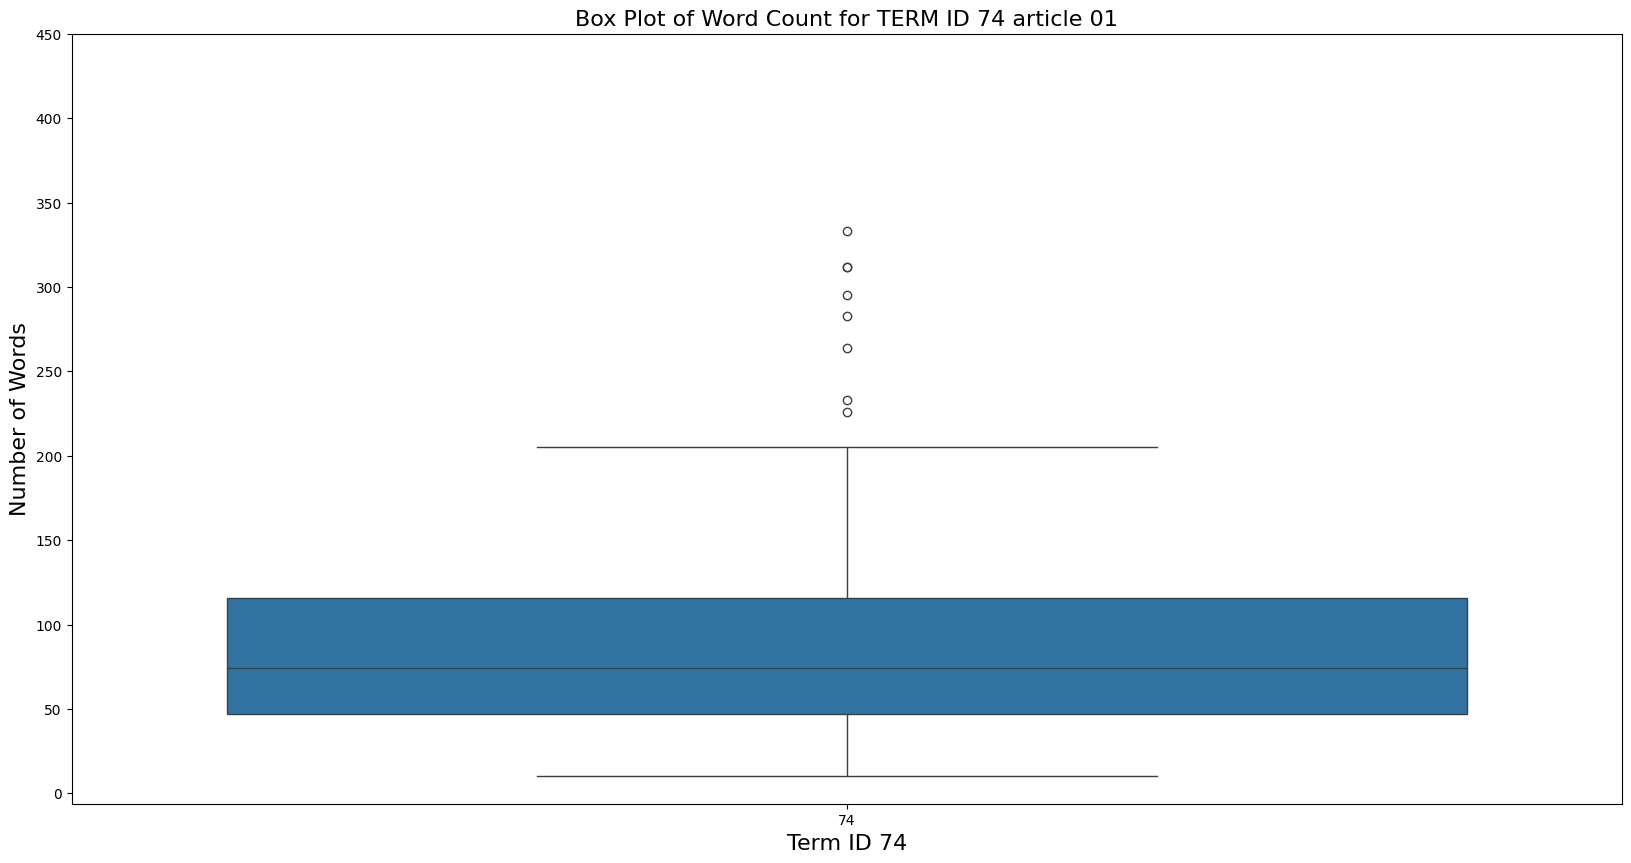

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


def avg_word_length(df, column, term_id, step_y_axis=200, max_y_position = 1500):
    """
    Function for plotting a histogram which show the avg
    and max word counts of each comment
    :param df: pandas dataframe which contains the text
    :param column: column of interest (str)
    :param term_id: article of interest (int)
    :return: plot of a histogram
    """
    # Calculate the maximum and minimum word count values

    df_term = df[df['term_id'] == term_id]
    print(np.unique(df_term['name']))

    median = df_term[column].median()
    sns.boxplot(x=my_cols[1], y=column, data=df_term)
    plt.axhline(median, xmin=0, xmax=0, label=f'Median for term_id {term_id}: {median}')
    # plt.text(0, 0, f'{median}', fontsize=12, ha='right', va='top')

    # Add labels and legend
    plt.xlabel("Term ID 74", fontsize=16)
    plt.ylabel('Number of Words', fontsize=16)
    plt.title(f"Box Plot of Word Count for TERM ID 74 article 01", fontsize=16)

    #Adjust the y axis
    max_word_count = df_term[column].max()
    y_tick_positions = [i for i in range(0, max_word_count + max_y_position, step_y_axis)]
    plt.yticks(y_tick_positions)
    

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
avg_word_length(df_74_01, 'word_count', 74, step_y_axis=50, max_y_position=150)
plt.show()

### IMPLEMENT A CLASS FOR GPT API

In [4]:
%%capture
!pip install openai python-dotenv openpyxl
import openai
import os
from dotenv import load_dotenv
import openpyxl

In [5]:
class PromptingGPT:

    # Load API key and organization from environment variables
    load_dotenv("secrets.env")
    openai.api_key = os.getenv("OPENAI_API_KEY")
    openai.organization = os.getenv("OPENAI_ORGANIZATION")

    ClientOpenAi = openai.OpenAI(
            api_key= openai.api_key,
            organization= openai.organization
        )

    
    def make_prompts(self, prompt, GPT_model='gpt-3.5-turbo-0125'):
        """
        Create a conversation with a GPT model. With
        the following code you create a prompt with a GPT model
        :param prompt: str (input text)
        :param GPT_model: str (model to be selected)
        :return: response of GPT model
        """
        messages = [{'role': 'system', 'content': 'You are a helpful assistant.'}]
        messages.append({'role': 'user', 'content': prompt})

        response = openai.chat.completions.create(
            model=GPT_model,
            messages=messages,
            max_tokens=4000,
        )

        # Extract and print the model's reply
        reply = response.choices[0].message.content
        print(reply)

        # Update conversation history
        return reply

In [6]:
# Extract final columns
final_cols = df_74_01.columns.to_list()
final_cols
print(df_74_01.iloc[3]['comments_with_stopwords'])

πολύ καλή εξέλιξη για όσους συναδέλφους επιθυμούν να συνεχίσουν και πέραν της 35ετιας να προσφέρουν την εμπειρία τους και τις υπηρεσίες τους στις ε.δ μας δίνεται η δυνατότητα να εργαστούμε στο αντικείμενο που αγαπήσαμε βιώσαμε και αποτελεί το μεγαλύτερο κομμάτι της ζωής μας πάρα ταύτα τα στελέχη των ειδικών δυνάμεων του πολεμικού ναυτικού υ κτ πως θα συνεχίσουν να επιχειρούν και να μεταδίδουν την εμπειρία τους και τις γνώσεις τους χωρίς να καταδύονται ή να πέφτουν με το αλεξίπτωτο κόβοντας αυτό το προνόμιο και το οικονομικό επίδομα πως θα διδάξει καταδύσεις κάποιος χωρίς να καταδυθεί οπωσδήποτε είναι μια πολύ καλή εξέλιξη που δίνει την δυνατότητα σε στελέχη να παραμένουν ενεργά και να αποτελούν παράδειγμα προς μίμηση


## CREATE A SUMMARY OF COMMENTS

### TECHNIQUE 1: DIVIDE COMMENTS **INDEPENDENTLY** INTO DOZENS OF 12 IN ORDER TO CREATE A SUMMARY FOR EACH DOZEN

In [170]:
from tqdm import tqdm

length_coms = len(df_74_01)
summary_each_12_unclustered_independent = []
for i in tqdm(range(0, length_coms, 12)):
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    if (length_coms-i)<12:
        comments = df_74_01.iloc[i:length_coms]['comments_with_stopwords'].to_list()
    else:
        comments = df_74_01.iloc[i:i+12]['comments_with_stopwords'].to_list()
    prompt = f"""
    Hello my good model, I would like to create a summary of 300 words for an article and its comments. 
    The article is from the Ministry of Defence and the topic of discussion is: 
    "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". 
    I will provide you the comments and I would like you to create the summary in order the Minister of Defense 
    to be able to comprehend the whole discussion and its most important points. Please I would like the summary
    to be in Greek language as the comments are. Additionaly, I will give you some insights by the exploratory 
    The average word count for the comments is 95 words. Finally, for each comment I have removed special tokens and digits, 
    so be careful with the connections of the words and the meanings.
    Please write me an efficient summary with all the insights from the comments. Thank you
    Here are the comments I would like to create a summary in Greek language: + {comments}
    """
    summary_each_12_unclustered_independent.append(GPT_prompts.make_prompts(prompt))        

  9%|█████████████                                                                                                                                  | 1/11 [00:12<02:09, 12.92s/it]

Βάσει των σχολίων σας, η συζήτηση περί των "Ειδικών Κατηγοριών Αξιωματικών Εκτός Οργανικών Θέσεων" αποτελεί ένα θέμα που προκαλεί θετικές αντιδράσεις. Η δυνατότητα για ενεργό συμμετοχή και προσφορά από έμπειρα στελέχη αναδεικνύεται ως θετική εξέλιξη. Συνάδελφοι που έχουν Ͼενίξει την τριανταπενταετία εκδηλώνουν την επιθυμία να παραμείνουν δραστήριοι, ενώ ορισμένοι εκφράζουν τη λύπη τους για τη διακοπή οικονομικών επιδομάτων λόγω της αποστρατείας. Ορισμένοι παρατηρούν την ανάγκη να καθοριστούν μέτρα αποζημίωσης για αξιωματικούς με ειδικές υπηρεσιακές παραμονές. Με γενικότερη σύμφωνη άποψη για τη θετική εξέλιξη που αναμένεται, ελπίζεται ότι η διαδικασία θα οδηγήσει σε οφέλη για τους ενδιαφερόμενους. Τέλος, η πρωτοβουλία αναμένεται να καταλήξει σε νομική ρύθμιση, εκδηλώνοντας θετικές προσδοκίες για το μέλλον.


 18%|██████████████████████████                                                                                                                     | 2/11 [00:24<01:51, 12.38s/it]

Από τα σχόλια που παρατέθηκαν, προκύπτει μια θετική αντίδραση σχετικά με την πρόταση για τις ειδικές κατηγορίες αξιωματικών που είναι εκτός οργανικών θέσεων από το Υπουργείο Άμυνας. Οι συμμετέχοντες υποστηρίζουν τη διατήρηση εμπειρογνωμόνων στις ενόπλες δυνάμεις, ενώ τονίζουν την κοινωνική και εργασιακή ισονομία που επιδιώκεται. Επιπλέον, υπάρχει επισήμανση για την ανάγκη διαγραφής προβλέψεων περί υπηρεσίας στο εξωτερικό και γίνεται λόγος για απαιτήσεις δικαιοσύνης για τους αξιωματικούς. Η συνολική εικόνα που αποδίδεται είναι ότι η πρόταση φαίνεται να είναι θετικά εκτιμημένη, ενώ υπάρχουν ανησυχίες για πιθανές αδικίες ή ανεπάρκειες στην εφαρμογή της. Συνολικά, η πρόταση φαίνεται να αποτελεί ενθαρρυντικό βήμα προς την βελτίωση της κατάστασης των αξιωματικών εκτός των οργανικών θέσεων.


 27%|███████████████████████████████████████                                                                                                        | 3/11 [00:46<02:12, 16.53s/it]

Βασικά σημεία της συζήτησης από το άρθρο του Υπουργείου Άμυνας με θέμα "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" είναι:
1. Παροχή δυνατότητας παραμονής των αξιωματικών έως τα 58 μετά την αποστρατεία τους και εκτός οργανικών θέσεων.
2. Καθορισμός των όρων και προθεσμιών για την οικειοθελή παραμονή τους.
3. Ανάγκη αλλαγής στη διαδικασία για δικαιοσύνη και ισονομία.
4. Πρόταση να συμπεριληφθούν και εκείνοι που έχουν αποστρατευτεί αλλά μπορούν να συνεχίσουν υπηρεσία.
5. Αναγνώριση της εμπειρίας και γνώσης των αξιωματικών που θέλουν να παραμείνουν ενεργοί.
6. Πρόταση για δημιουργία θέσεων εξωτερικά, ενισχύοντας την υπηρεσία στις παραμεθόριες περιοχές.

Οι σχόλια αναδεικνύουν υποστήριξη προς την επέκταση των ευκαιριών για τους αξιωματικούς, καθώς επίσης επισημαίνουν την ανάγκη για ισονομία. Η ενδεχόμενη θετική επίδραση στην υπηρεσία και την κοινωνία επισημαίνεται, εστιάζοντας στην αξιοποίηση της εμπειρίας τους. Επιπλέον, προκύπτει η αναγγελία τερματισμού της υποχρεωτικής εφεδρε

 36%|████████████████████████████████████████████████████                                                                                           | 4/11 [00:57<01:40, 14.36s/it]

Ο Υπουργός Άμυνας πρέπει να ενημερωθεί για τα βασικά στοιχεία της συζήτησης σχετικά με τις "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". Οι συμμετέχοντες υποστηρίζουν την ενίσχυση των ΕΔ με εμπειρότερα στελέχη για την αντιμετώπιση των προκλήσεων, ενώ προτείνουν αποκατάσταση αδικιών και ισότητας για τα στελέχη εξωτερικού. Η συνταξιοδότηση στα 53 ετών αναφέρεται ως κοινωνική αδικία, ενώ υπάρχει πρόταση για επιστροφή των επιθυμούντων σε ηλικία έως 58 ετών. Τέλος, υπογραμμίζεται η ανάγκη για δικαιοσύνη και ισότητα στο πλαίσιο των νέων μέτρων. Οι συζητήσεις εστιάζουν στην ανάγκη επαναξιολόγησης του στρατού και της στρατιωτικής ιεραρχίας, προκειμένου να διασφαλιστεί η βέλτιστη απόδοση και λειτουργία των ΕΔ.


 45%|█████████████████████████████████████████████████████████████████                                                                              | 5/11 [01:08<01:19, 13.32s/it]

Από τα σχόλια που παρουσιάστηκαν, προκύπτει μια έντονη συζήτηση γύρω από το θέμα "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". Οι αντιδράσεις κυμαίνονται ανάμεσα σε θετικές και αρνητικές αξιολογήσεις του προτεινόμενου νόμου. Ορισμένοι υποστηρίζουν την ανάγκη νέων μέτρων για την αποκατάσταση δικαιοσύνης και ισότητας στην υπηρεσία, όπως η ενσωμάτωση αξιωματικών που τερμάτισαν τη σταδιοδρομία τους πρόωρα.

Άλλοι επισημαίνουν την ανάγκη για διαφοροποίηση και διαφάνεια στη διαδικασία εκτέλεσης του νόμου για την αποφυγή κοινωνικών αδικιών. Σημαντικά αναφέρεται η πρόταση να εξεταστεί και η ενδεχόμενη επέκταση του μέτρου στα στελέχη του 1990 και η πιθανότητα ενσωμάτωσής τους στο νόμο 2439/96. Το συνολικό συμπέρασμα είναι ότι υπάρχει ανάγκη για εξισορρόπηση μεταξύ της ανάγκης για επαγγελματική συνέχεια και των αρχών της δικαιοσύνης στο πλαίσιο των Ενόπλων Δυνάμεων.


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 6/11 [01:19<01:01, 12.24s/it]

Το άρθρο του Υπουργείου Άμυνας αναφέρεται στις "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". Στα σχόλια που παρέχονται, αναδεικνύονται σημαντικές απόψεις. Προτάσεις περιλαμβάνουν την επέκταση κριτηρίων για πρόωρη συνταξιοδότηση, την ενσωμάτωση σε νέες κατηγορίες, και τη σημασία της εμπειρίας και υπηρεσίας. Έγινε αναφορά και στην προστασία των συνταξιούχων αξιωματικών, στην αξία που μπορούν να προσφέρουν στις ε.δ, καθώς και στην ανάγκη για αξιοποίηση της εμπειρίας τους. Εν γένει, οι συζητήσεις επικεντρώθηκαν στην αναδιάρθρωση και αξιοποίηση του ανθρώπινου δυναμικού των ενόπλων δυνάμεων. Η δημιουργία νέων κατηγοριών προσωπικού, οι προκλήσεις που προκύπτουν, και η σημασία της συνεισφοράς των αξιωματικών αποτελούν κύρια θέματα.


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 7/11 [01:29<00:46, 11.75s/it]

Σύνοψη:

Το Υπουργείο Άμυνας συζητά το θέμα των ειδικών κατηγοριών αξιωματικών εκτός οργανικών θέσεων. Οι συνάδελφοι εκφράζουν ικανοποίηση για τη δυνατότητα παραμονής μετά τα 35 έτη, ενώ υπογραμμίζουν την ανάγκη δικαιοσύνης και ισότητας στην εφαρμογή του νόμου. Προτείνουν επίσης τη λύση παλαιών προβλημάτων και τη συμμετοχή όλων στη βελτίωση του νομοσχεδίου. Επισημαίνουν την ανάγκη για διαφάνεια και συνεργασία, ενώ εκφράζουν ανησυχίες για τις επιπτώσεις στην οικογένεια των αξιωματικών. Στηρίζουν την πρωτοβουλία της κυβέρνησης για τη διατήρηση του εμψυχωτικού δυναμικού και τη διαχείριση ρεαλιστικών προβλημάτων. Επισημαίνουν την ανάγκη άμεσης εφαρμογής του νόμου για την εξασφάλιση δικαιωμάτων και ευκαιριών για τους αξιωματικούς.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 8/11 [01:47<00:40, 13.62s/it]

Το άρθρο του Υπουργείου Άμυνας με θέμα "Ειδικές Κατηγορίες Αξιωματικών Εκτός Οργανικών Θέσεων" προκάλεσε θετικά σχόλια. Ορισμένοι χρήστες εξέφρασαν την υποστήριξή τους για το νομοσχέδιο που αποσκοπεί στη διασφάλιση της ισότητας και στην επιστροφή στην ενεργό υπηρεσία αξιωματικών άνω των 58 ετών. Επισημαίνεται η ανάγκη για επαρκή προσωπικό στις μονάδες και σε μαχητικές ειδικότητες. Επικροτείται η επιχειρούμενη πρωτοβουλία για τη διατήρηση των εμπειριών στελεχών και η τήρηση δεσμεύσεων για την επιστροφή στην υπηρεσία.

Τα σχόλια προβάλλουν τη σημασία της θέσης του κ. Υπουργού και την υιοθέτησή του αξιοπρεπούς στάσης για το θέμα. Οι χρήστες εκφράζουν ανησυχίες για τις λεπτομέρειες και την ασάφεια στο νομοσχέδιο, καλώντας για διαφορετικές εξηγήσεις. Επιπλέον, υπογραμμίζεται η ανάγκη για νέα αίματα στις ένοπλες δυνάμεις και η σημασία της διαφύλαξης των ασφαλιστικών ταμείων. Οι σχολιαστές εκφράζουν την επιθυμία για διαφάνεια και συνέχεια στην υπηρεσία, καθώς και την απαίτηση για ισότιμη μετα

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9/11 [02:03<00:28, 14.24s/it]

Από τη συζήτηση που αναφέρεται στο θέμα "Ειδικές κατηγορίες αξιωματικών Έξω Οργανικών Θέσεων" από το Υπουργείο Εθνικής Άμυνας, προκύπτουν σημαντικά σχόλια. Οι συζητήσεις επικεντρώνονται στο θέμα της παραμονής των στελεχών μετά τα 35 έτη υπηρεσίας. Ορισμένοι επικροτούν τη δυνατότητα παραμονής μέχρι τα 58 έτη, ενώ άλλοι εκφράζουν ανησυχίες για τη δικαιοσύνη και ισότητα σε σχέση με τις συντάξεις και την επαγγελματική πορεία. Αναδεικνύεται η ανάγκη για δίκαιες και συνεκτικές λύσεις που θα λαμβάνουν υπόψη τις ιδιαιτερότητες της στρατιωτικής υπηρεσίας. Επίσης, προτείνεται η διευκρίνιση ορισμένων παραγράφων του νομοσχεδίου προκειμένου να εξασφαλιστεί η διαφάνεια και η συνέπεια στην εφαρμογή του. Συνολικά, αναδεικνύεται η ανάγκη για ισορροπημένες και δικαιολογημένες αποφάσεις που θα ανταποκρίνονται στα διάφορα επαγγελματικά και κοινωνικά κριτήρια των ενδιαφερομένων.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 10/11 [02:16<00:13, 13.99s/it]

Το Υπουργείο Άμυνας συζητά τις "Ειδικές Κατηγορίες Αξιωματικών Εκτός Οργανικών Θέσεων". Τα σχόλια εκφράζουν ελπίδες για την υλοποίηση υποσχέσεων που αφορούν την αποχώρηση αξιωματικών από τον στρατό μετά τα 58 τους. Εκφράζεται θετική αξιολόγηση για τη δυνατότητα συνέχισης υπηρεσίας από έμπειρους αξιωματικούς. Η πολιτική ηγεσία του υπουργείου αναγνωρίζει τη σημασία της συνεισφοράς του προσωπικού. Υπάρχει ανησυχία για αδικίες που προκύπτουν από τον νέο νόμο. Προτάσεις για διασφάλιση δικαιοσύνης στη μεταρρύθμιση της αποχώρησης των αξιωματικών αναφέρονται. Αναδεικνύεται η ανάγκη ισοτιμίας και ισότητας στη μεταρρύθμιση του συστήματος σύνταξης. Ο νόμος προβλέπει ανταποδοτικό μέρος στις συντάξεις. Συνολικά, υπογραμμίζεται η ανάγκη για δίκαιη και ισότιμη μεταρρύθμιση.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:26<00:00, 13.34s/it]

Η συζήτηση γύρω από τις ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων αναδεικνύει διάφορες απόψεις και προβληματισμούς. Από τα σχόλια προκύπτει η αντίθεση ορισμένων συναδέλφων, οι οποίοι αμφισβητούν τη νομιμότητα και τη δικαιολογία πίσω από την πρόταση παράτασης του εργασιακού βίου. Αντίθετα, υπάρχουν και θετικές αξιολογήσεις για το προτεινόμενο σχέδιο νόμου, που το βλέπουν ως επιτυχημένη ρύθμιση που εξυπηρετεί τόσο τους αξιωματικούς όσο και τις ένοπλες δυνάμεις. Επιπλέον, επισημαίνεται η ανάγκη για διατήρηση της αξιόμαχης δύναμης των ενόπλων δυνάμεων αντιμέτωπων με δύσκολους καιρούς. Συνολικά, η πρόταση φαίνεται να διχάζει τις απόψεις, αλλά προσφέρει λύσεις για την ολοκλήρωση της σταδιοδρομίας των αξιωματικών με διαφανή κριτήρια και δικαιοσύνη.


In [171]:
GPT_prompts = PromptingGPT()

prompt = f"""
Hello my good model, I would like to create a summary of 600 words about comments for an article by Ministry of Defence.
The article is about Ministry of Defence and the topic of discussion is: "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων".
The comments scope to represent the problems, aggrements and/or challenges for the article. However, for the reason that the comments
were too many, I created a summary for each 12 comments of 200 words. So, I would like you to create a final summary 
of 600 words, based on the summaries of the comments. Please write the final summary based on the summaries I am providing you
and the topic. I would like the final summary to be in Greek language as the summaries are.
Here are the summaries: + {summary_each_12_unclustered_independent}
"""

final_summary_74_01_independent = GPT_prompts.make_prompts(prompt, GPT_model='gpt-4-0125-preview')

Στη συζήτηση που προέκυψε από το άρθρο του Υπουργείου Άμυνας για τις "Ειδικές Κατηγορίες Αξιωματικών Εκτός Οργανικών Θέσεων", τα σχόλια των αναγνωστών αντικατόπτρισαν ένα φάσμα απόψεων, σκέψεων και προβληματισμών. Η προσέγγιση αυτή εμφανίζεται να εγείρει ιδιαίτερο ενδιαφέρον από ένα πλήθος εμπειρογνωμόνων και ενδιαφερόμενων μερών τόσο για τις ευκαιρίες ανάπτυξης και προσφοράς που ανοίγει στα έμπειρα στελέχη, όσο και για τις υπάρχουσες προκλήσεις και τις ανησυχίες σχετικά με την ισότητα και τη δικαιοσύνη.

Από την μία πλευρά, αναγνωρίζεται η δυνατότητα παραμονής των αξιωματικών έως τα 58 έτη σε εκτός οργανικών θέσεων ως μια θετική εξέλιξη που επιτρέπει την αξιοποίηση της εμπειρίας και των γνώσεων τους για την ενίσχυση των ενόπλων δυνάμεων και την αντιμετώπιση των προκλήσεων. Παράλληλα, εκφράζεται ικανοποίηση για τις νέες προοπτικές που προσφέρονται, καθώς και για τη δυνατότητα διατήρησης του εμψυχωτικού δυναμικού.

Από την άλλη πλευρά, υπάρχει προβληματισμός και ανησυχία όσον αφορά τις 

### PRINT THE SUMMARY IN A BETTER FORMAT

In [189]:
import textwrap

def print_summary(final_summary):
    """
    Give a text and print it in a more beautiful format
    :param final_summary: str of final summary
    :return: print in a better format the summary
    """
    # Split the text into paragraphs
    paragraphs = final_summary.split('\n\n')  # Assuming paragraphs are separated by two newlines

    # Wrap each paragraph using textwrap
    wrapped_text = '\n\n'.join(textwrap.fill(paragraph, width=120) for paragraph in paragraphs if paragraph)

    print(wrapped_text)

print_summary(final_summary_74_01_independent)

Στη συζήτηση που προέκυψε από το άρθρο του Υπουργείου Άμυνας για τις "Ειδικές Κατηγορίες Αξιωματικών Εκτός Οργανικών
Θέσεων", τα σχόλια των αναγνωστών αντικατόπτρισαν ένα φάσμα απόψεων, σκέψεων και προβληματισμών. Η προσέγγιση αυτή
εμφανίζεται να εγείρει ιδιαίτερο ενδιαφέρον από ένα πλήθος εμπειρογνωμόνων και ενδιαφερόμενων μερών τόσο για τις
ευκαιρίες ανάπτυξης και προσφοράς που ανοίγει στα έμπειρα στελέχη, όσο και για τις υπάρχουσες προκλήσεις και τις
ανησυχίες σχετικά με την ισότητα και τη δικαιοσύνη.

Από την μία πλευρά, αναγνωρίζεται η δυνατότητα παραμονής των αξιωματικών έως τα 58 έτη σε εκτός οργανικών θέσεων ως μια
θετική εξέλιξη που επιτρέπει την αξιοποίηση της εμπειρίας και των γνώσεων τους για την ενίσχυση των ενόπλων δυνάμεων και
την αντιμετώπιση των προκλήσεων. Παράλληλα, εκφράζεται ικανοποίηση για τις νέες προοπτικές που προσφέρονται, καθώς και
για τη δυνατότητα διατήρησης του εμψυχωτικού δυναμικού.

Από την άλλη πλευρά, υπάρχει προβληματισμός και ανησυχία όσον αφορά τις 

### TECHNIQUE 2: DIVIDE COMMENTS INTO DOZENS OF 12 IN ORDER TO CREATE A SUMMARY FOR EACH DOZEN - GIVE THE PREVIOUS SUMMARIES TO THE NEXT DOZEN OF COMMENTS

In [176]:
from tqdm import tqdm


summary_each_12_unclustered = []
for i in tqdm(range(0, length_coms, 12)):
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    if (length_coms-i)<12:
        comments = df_74_01.iloc[i:length_coms]['comments_no_stopwords'].to_list()
    else:
        comments = df_74_01.iloc[i:i+12]['comments_no_stopwords'].to_list()
    prompt = f"""
    Hello my good model, I would like to create a summary of 300 words for an article and its comments. 
    The article is from the Ministry of Defence and the topic of discussion is: 
    "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". 
    I will provide you the comments and I would like you to create the summary in order the Minister of Defense 
    to be able to comprehend the whole discussion and its most important points. Please I would like the summary
    to be in Greek language as the comments are. Additionaly, I will give you some insights by the exploratory 
    The average word count for the comments is 95 words. Finally, for each comment I have removed special tokens and digits, 
    so be careful with the connections of the words and the meanings. Finally I am going to give you the summaries of the previous
    comments in order to be able to check the history of the previous comments.
    Please write me an efficient summary with all the insights from the comments. Thank you
    Here are the history of the previous summaries of the previous comments: {summary_each_12_unclustered}
    Here are the comments I would like to create a summary in Greek language: + {comments}
    """
    summary_each_12_unclustered.append(GPT_prompts.make_prompts(prompt))        

  9%|█████████████                                                                                                                                  | 1/11 [00:11<01:59, 11.94s/it]

Με βάση τα σχόλια που παραστήθηκαν, το άρθρο αφορά την ειδική κατηγορία των αξιωματικών εκτός οργανικών θέσεων στον τομέα της αμυντικής πολιτικής. Έχουν εκφραστεί θετικές αναφορές σε αυτήν την εξέλιξη, με στελέχη που έχουν αποφασίσει να συνεχίσουν την υπηρεσία τους πέραν των 35 ετών, παρά την προοπτική της συνταξιοδότησης. Αναδεικνύεται η σπουδαιότητα της διατήρησης της εμπειρίας και των γνώσεων τους για την εθνική ασφάλεια. Συγχρόνως, διατυπώνονται επικρίσεις για τις ανισότητες στην αποζημίωση και τα κινδύνους που αντιμετωπίζουν, με αιτήματα για δίκαιες ρυθμίσεις. Επιπλέον, υπογραμμίζεται η σημασία της πρόβλεψης για την εξέλιξη των αξιωματικών που προέρχονται από το στράτευμα, προσκαλώντας την πολιτική ηγεσία να υιοθετήσει αντίστοιχες λύσεις. Συνολικά, οι συζητήσεις αντικατοπτρίζουν την προσπάθεια για δίκαιες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας.


 18%|██████████████████████████                                                                                                                     | 2/11 [00:21<01:35, 10.63s/it]

Βάσει των σχολίων που προβλήθηκαν, η συζήτηση αφορά την ειδική κατηγορία των αξιωματικών εκτός οργανικών θέσεων στον τομέα της αμυντικής πολιτικής. Έκαναν επισήμανση για τη σημασία της διατήρησης της εμπειρίας τους για την εθνική ασφάλεια, αλλά και για τις ανισότητες στην αποζημίωση και τους κινδύνους που αντιμετωπίζουν, με αιτήματα για δίκαιες ρυθμίσεις. Υπάρχει αίτημα για να γίνει νόμος η παραμονή τους στο στρατό μετά τα 35 έτη υπηρεσίας, εξασφαλίζοντας ότι αυτή η προσπάθεια είναι ανθρωποκεντρική πολιτική. Επίσης, προτείνεται η διαγραφή της υποχρεωτικής εφεδρείας των 35 ετών υπηρεσίας. Συνολικά, οι συζητήσεις προσδιορίζουν την ανάγκη για δικαιότερες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας.


 27%|███████████████████████████████████████                                                                                                        | 3/11 [00:26<01:05,  8.16s/it]

Based on the history of previous summaries of the comments, the ongoing discussion on the topic of "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" from the Ministry of Defence highlights various important points. The comments express relief during economic crises as a draft law is open for consultation concerning the possibility for officers outside organic positions to remain in service beyond retirement age. The importance of maintaining their experience for national security is emphasized, along with concerns about inequalities in compensation and risks they face, calling for fair regulations. Suggestions include making their continued service a law, emphasizing human-centered policies. Discussions also stress the need for fair and sustainable policies to strengthen the defense sector.

Moreover, there is recognition of the significance of anticipating the development of officers coming from the military, urging political leadership to adopt corresponding solutions. Overall,

 36%|████████████████████████████████████████████████████                                                                                           | 4/11 [00:36<01:00,  8.59s/it]

Με βάση την εξέλιξη των σχολίων, η συζήτηση για τις ειδικές κατηγορίες αξιωματικών εκτός οργανικών θέσεων αναδεικνύει σημαντικά στοιχεία. Εκφράζεται χαρά για τη διατήρηση εμπειρίας αξιωματικών και ανησυχίες για ανισότητες στην αποζημίωση και τους κινδύνους που αντιμετωπίζουν, με αιτήματα για δίκαιες ρυθμίσεις. Υπάρχει πρόταση να γίνει νόμος η παραμονή τους στο στρατό μετά τα 35 έτη υπηρεσίας, ενώ επισημαίνεται η σημασία της διατήρησης της εμπειρίας τους για την εθνική ασφάλεια. Συνολικά, υπάρχει ανάγκη για δικαιότερες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας. Επίσης, υπάρχει ανησυχία για την αδικία που προκύπτει από την απόσταση αξιωματικών νωρίτερα από τα 35 έτη υπηρεσίας, ενώ υπάρχει θετική υποδοχή για την επιστροφή τους και την αποζημίωσή τους.


 45%|█████████████████████████████████████████████████████████████████                                                                              | 5/11 [00:52<01:09, 11.51s/it]

Με βάση τα σχόλια που προστέθηκαν, η συζήτηση επί του θέματος "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" από το Υπουργείο Εθνικής Άμυνας αναδεικνύει διάφορα σημαντικά στοιχεία. Οι συζητήσεις εστιάζουν στη χαρά για τη διατήρηση της εμπειρίας των αξιωματικών, αλλά και στις ανησυχίες για τις ανισότητες στην αποζημίωση και τους κινδύνους που αντιμετωπίζουν. Υπάρχει πρόταση για νομική ρύθμιση που θα επιτρέπει στους αξιωματικούς να παραμείνουν στην υπηρεσία μετά τα 35 έτη υπηρεσίας, με έμφαση σε ανθρωποκεντρικές πολιτικές. Οι συζητήσεις αναδεικνύουν την ανάγκη για δίκαιες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας, ενώ υπάρχει συναίνεση για την αποκατάσταση αδικιών και την υποστήριξη των αξιωματικών που επιθυμούν να συνεισφέρουν με την εμπειρία τους.


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 6/11 [01:06<01:01, 12.20s/it]

Με βάση τα σχόλια που προβλήθηκαν σχετικά με τη συζήτηση για τις ειδικές κατηγορίες αξιωματικών εκτός οργανικών θέσεων, προκύπτουν τα εξής σημαντικά στοιχεία: 

Υπάρχει ικανοποίηση για τη δυνατότητα συνέχισης υπηρεσίας πέραν των 35 ετών, προσφέροντας την εμπειρία τους για το κράτος. Ωστόσο, προκύπτουν ανησυχίες σχετικά με ανισότητες στις αποζημιώσεις και τους κινδύνους που αντιμετωπίζουν, με αιτήματα για δίκαιες ρυθμίσεις. 

Υπάρχει πρόταση για να γίνει νόμος η παράταση υπηρεσίας μετά τα 35 έτη, με εστίαση σε ανθρωποκεντρικές πολιτικές. Επίσης, υπάρχει ανησυχία για την αδικία που προκύπτει από την απόσταση αξιωματικών νωρίτερα από τα 35 έτη υπηρεσίας. 

Οι συζητήσεις αναδεικνύουν την ανάγκη για δίκαιες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας, ενώ επισημαίνουν τη σημασία της διατήρησης της εμπειρίας των αξιωματικών για την εθνική ασφάλεια. Υπάρχει επίσης έμφαση στην ανάγκη νομικής ρύθμισης για να υπάρχει ισότητα και δικαιοσύνη στη ρύθμιση της συνταξιοδότησης και τη

 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 7/11 [01:18<00:48, 12.10s/it]

Βασισμένο στα σχόλια που προσφέρατε, η συζήτηση για τις ειδικές κατηγορίες αξιωματικών εκτός οργανικών θέσεων από το Υπουργείο Εθνικής Άμυνας αποκαλύπτει σημαντικά στοιχεία. Οι συζητήσεις εστιάζουν στη χαρά για τη διατήρηση της εμπειρίας των αξιωματικών, ενώ ταυτόχρονα αναφέρονται ανησυχίες λόγω ανισοτήτων στην αποζημίωση και τους κινδύνους που αντιμετωπίζουν. Έχει προταθεί να γίνει νόμος η παράταση υπηρεσίας μετά τα 35 έτη, ενισχύοντας την ανθρωποκεντρική πολιτική. Υπάρχει επίσης ανάγκη για δίκαιες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας. Το προορίζόμενο νομοσχέδιο αντικατοπτρίζει την προσπάθεια να αντιμετωπιστούν προβλήματα και να ενθαρρυνθούν οι αξιωματικοί που επιθυμούν να συνεχίσουν να συμβάλλουν με την εμπειρία τους.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 8/11 [01:37<00:42, 14.28s/it]

Με βάση τα σχόλια που προβάλλονται, η συζήτηση επί του θέματος "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" αναδεικνύει σημαντική πρόοδο στον τομέα της άμυνας. Υπάρχει θετική υποδοχή για τη δυνατότητα συνέχισης υπηρεσίας πέραν των 35 ετών από αξιωματικούς, ενισχύοντας έτσι την εμπειρία που ο μέσος όρος αξιωματικών αποκτά κατά τη διάρκεια της καριέρας τους. Ωστόσο, εκφράζονται ανησυχίες για ανισότητες στην αποζημίωση, τους κινδύνους που αντιμετωπίζουν και αιτούνται δίκαιες ρυθμίσεις. Η πρόταση για νομική ρύθμιση προκειμένου οι αξιωματικοί να παραμείνουν στην υπηρεσία υπό προϋποθέσεις ανθρωποκεντρικής πολιτικής είναι βασική.

Επιπλέον, οι συζητήσεις αναδεικνύουν τη σημασία της διατήρησης της εμπειρίας των αξιωματικών για την εθνική ασφάλεια και προτείνουν δικαιότερες και βιώσιμες πολιτικές που θα ενισχύσουν τον τομέα της άμυνας. Είναι σημαντικό να εξετάζονται οι προτάσεις με προσοχή και να εφαρμόζονται μετρά για την εξισορρόπηση ευθυνών και αποζημιώσεων, προκειμένου οι αξιωματ

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9/11 [01:49<00:27, 13.60s/it]

Βάσει των σχολίων που προσφέρθηκαν, η συζήτηση επί του θέματος "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" αναδεικνύει σημαντικά στοιχεία. Το ετος είναι θετικό, καθώς εμπλουτίζει τις θέσεις γραφείων επιτελείων με εμπειροί αξιωματικούς ικανούς να αντιμετωπίζουν επικίνδυνες καταστάσεις. Το προτεινόμενο νομοσχέδιο ευνοεί τη συνέχιση υπηρεσίας πέραν των 35 ετών, ενισχύοντας την εμπειρία και την εθνική ασφάλεια. Ωστόσο, υπάρχουν ανησυχίες για ανισότητες και δικαιοσύνη, με αιτήματα για δίκαιες ρυθμίσεις. Συνολικά, η πρόοδος της συζήτησης ενόψει δίκαιων και βιώσιμων πολιτικών αποτελεί βήμα προς την ενίσχυση του τομέα της άμυνας.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 10/11 [02:00<00:12, 12.94s/it]

Με βάση τα σχόλια που προβάλλονται, η συζήτηση για τις "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων" αναδεικνύει σημαντικά στοιχεία. Υπάρχει αίτημα για νόμο που θα επιτρέπει σε αξιωματικούς με εμπειρία να συνεχίσουν υπηρεσία πέραν των 35 ετών, τονίζοντας τη σημασία της εμπειρίας για την εθνική ασφάλεια. Παράλληλα, εκφράζονται ανησυχίες για ανισότητες στην αποζημίωση και τους κινδύνους που αντιμετωπίζουν, με αιτήματα για δίκαιες ρυθμίσεις. Η ανάγκη δίκαιων και βιώσιμων πολιτικών που θα ενισχύσουν τον τομέα της άμυνας είναι κοινός παροχής σημαίνει. Επιπλέον, είναι σημαντικό να αντιμετωπίζονται αδικίες με ισότιμο τρόπο στη νομοθεσία για τη συνέχιση υπηρεσίας και τις συνταγματάρχες που έχουν αποστρατευτεί.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:12<00:00, 12.04s/it]

Με βάση τα σχόλια που προβλήθηκαν, η συζήτηση για τις ειδικές κατηγορίες αξιωματικών εκτός οργανικών θέσεων αναδεικνύει σημαντικά στοιχεία. Αναφέρεται διάκριση στην επιθυμία αξιωματικών να συνεχίσουν την υπηρεσία τους πέραν των 35 ετών, βαρύνοντας τη σημασία της εμπειρίας για την εθνική ασφάλεια. Οι προτεινόμενες διατάξεις αποτελούν πρωτοβουλία ενοποίησης πολιτικής προς το κοινό καλό, ενώ απαιτούνται δίκαιες ρυθμίσεις για τις ανισότητες στην αποζημίωση. Συνολικά, η πρόοδος προς δίκαιες και βιώσιμες πολιτικές επιδοκιμάζεται, εξασφαλίζοντας τη στήριξη των αξιωματικών για ενισχυτικές πρωτοβουλίες.


In [177]:
GPT_prompts = PromptingGPT()

prompt = f"""
Hello my good model, I would like to create a summary of 600 words about comments for an article by Ministry of Defence.
The article is about Ministry of Defence and the topic of discussion is: "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων".
The comments scope to represent the problems, aggrements and/or challenges for the article. However, for the reason that the comments
were too many, I created a summary for each 12 comments of 200 words. So, I would like you to create a final summary 
of 600 words, based on the summaries of the comments. Please write the final summary based on the summaries I am providing you
and the topic. I would like the final summary to be in Greek language as the summaries are.
Here are the summaries: + {summary_each_12_unclustered}
"""

final_summary_74_01_previous_connected = GPT_prompts.make_prompts(prompt, GPT_model='gpt-4-0125-preview')

Η ζωηρή συζήτηση που προκλήθηκε από το άρθρο του Υπουργείου Εθνικής Άμυνας σχετικά με τις «Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων» αναδείχθηκε μέσα από τα σχόλια του κοινού, αποκαλύπτοντας την πολυπλοκότητα των εν λόγω ζητημάτων καθώς και τις πολλαπλές προκλήσεις που αντιμετωπίζει το συγκεκριμένο κομμάτι της αμυντικής πολιτικής.

Από τα συγκεντρωμένα σχόλια, είναι εμφανής η γενική ικανοποίηση για τη δυνατότητα των αξιωματικών να παραμένουν στις θέσεις τους πέραν του κανονικού ορίου συνταξιοδότησης, δίνοντας έμφαση στην αξία της συνεχούς παροχής της εμπειρίας τους στα ζητήματα εθνικής ασφάλειας. Στο ίδιο πνεύμα, εκφράζονται ανησυχίες για τις ανισότητες στην αποζημίωση και τους κινδύνους που αντιμετωπίζουν, με πολλούς να ζητούν δίκαιες και ανθρωποκεντρικές ρυθμίσεις που θα εγγυώνται την ασφάλεια και την ευημερία τους.

Υπάρχει κατ' επανάληψη αναγνώριση της ανάγκης για νομοθετικές προσαρμογές που θα επιτρέπουν τη συνέχιση της υπηρεσίας αυτών των αξιωματικών μεθ' όρου ζωής, 

In [190]:
print_summary(final_summary_74_01_previous_connected)

Η ζωηρή συζήτηση που προκλήθηκε από το άρθρο του Υπουργείου Εθνικής Άμυνας σχετικά με τις «Ειδικές κατηγορίες
αξιωματικών Εκτός Οργανικών Θέσεων» αναδείχθηκε μέσα από τα σχόλια του κοινού, αποκαλύπτοντας την πολυπλοκότητα των εν
λόγω ζητημάτων καθώς και τις πολλαπλές προκλήσεις που αντιμετωπίζει το συγκεκριμένο κομμάτι της αμυντικής πολιτικής.

Από τα συγκεντρωμένα σχόλια, είναι εμφανής η γενική ικανοποίηση για τη δυνατότητα των αξιωματικών να παραμένουν στις
θέσεις τους πέραν του κανονικού ορίου συνταξιοδότησης, δίνοντας έμφαση στην αξία της συνεχούς παροχής της εμπειρίας τους
στα ζητήματα εθνικής ασφάλειας. Στο ίδιο πνεύμα, εκφράζονται ανησυχίες για τις ανισότητες στην αποζημίωση και τους
κινδύνους που αντιμετωπίζουν, με πολλούς να ζητούν δίκαιες και ανθρωποκεντρικές ρυθμίσεις που θα εγγυώνται την ασφάλεια
και την ευημερία τους.

Υπάρχει κατ' επανάληψη αναγνώριση της ανάγκης για νομοθετικές προσαρμογές που θα επιτρέπουν τη συνέχιση της υπηρεσίας
αυτών των αξιωματικών μεθ' όρου ζωής, 

## TECHNIQUE 3: CLASSIFY THE COMMENTS INTO SENTIMENT LABELS - SUMMARIZE THE COMMENTS OF EACH LABEL
The labels are
- Class 1: for
- Class 2: against
- Class 3: conflict
- Class 4: neutral

In [294]:
labels = []
for i in tqdm(range(length_coms)):
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    comment = df_74_01.iloc[i]['comments_with_stopwords']
    prompt = f"""
    Hello my good model again. I would like you to classify the comment that I will provide you. 
    The comment is about a law article with title: "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". 
    I would like you to classify this comment among 4 classes. The classes are: 
    class 1: for
    class 2: against
    class 3: conflict
    class 4: neutral
    Please keep in mind that the comments are in Greek. Moreover I will give you some examples on how to decide
    the label of the comment.
    Example comment 1: 
    'εύχομαι το συγκεκριμένο άρθρο να γίνει και νόμος του κράτους αφού θα δίνει το δικαίωμα σε αξιωματικούς 
    με μεγάλη επαγγελματική εμπειρία και γνώσης να συνεχίσουν να προσφέρουν στις ένοπλες δυνάμεις όταν άλλη 
    συνάδελφοι τους έφευγαν μεταξύ 25 και 30 χρονών υπηρεσίας για να προλάβουν να πάρουν μεγαλύτερη σύνταξη και εφάπαξ"
    Response 1: '1'
    Example comment 2:
    'αν είναι δυνατόν συναδελφους που περιμεναν μια 10ετια να αποστρατευτούν και με αυτήν την δικαιολογία 
    απαλλασσόντουσαν από τα πάντα να θέλουν να μείνουν αλλα 5 χρονια χωρίς να προσφέρουν ουσιαστικά τίποτα 
    από σμηναρχους δοξα το θεο πολλούς έχουμε δεν θέλουμε άλλους νέους ανθρώπους θέλουμε με δύναμη και παθος 
    κύριε υπουργέ μην το περάσετε αυτό το μετρο είναι άδικο και θα δημιουργήσει μονο προβλήματα στις μονάδες'
    Response 2: '2'
    Please provide only the lable no more description
    Here are is the comment for the classification task: + {comment}
    """
    labels.append(GPT_prompts.make_prompts(prompt, GPT_model='gpt-4-0125-preview'))  

  1%|█▏                                                                                                                                            | 1/123 [00:00<01:22,  1.48it/s]

1


  2%|██▎                                                                                                                                           | 2/123 [00:01<01:18,  1.55it/s]

1


  2%|███▍                                                                                                                                          | 3/123 [00:03<02:28,  1.23s/it]

1


  3%|████▌                                                                                                                                         | 4/123 [00:05<03:17,  1.66s/it]

1


  4%|█████▊                                                                                                                                        | 5/123 [00:06<02:48,  1.43s/it]

'1'


  5%|██████▉                                                                                                                                       | 6/123 [00:07<02:19,  1.19s/it]

1


  6%|████████                                                                                                                                      | 7/123 [00:09<02:40,  1.38s/it]

1


  7%|█████████▏                                                                                                                                    | 8/123 [00:09<02:19,  1.21s/it]

3


  7%|██████████▍                                                                                                                                   | 9/123 [00:10<01:58,  1.04s/it]

4


  8%|███████████▍                                                                                                                                 | 10/123 [00:11<01:48,  1.04it/s]

'3'


  9%|████████████▌                                                                                                                                | 11/123 [00:12<01:42,  1.09it/s]

1


 10%|█████████████▊                                                                                                                               | 12/123 [00:12<01:35,  1.16it/s]

'1'


 11%|██████████████▉                                                                                                                              | 13/123 [00:13<01:26,  1.28it/s]

1


 11%|████████████████                                                                                                                             | 14/123 [00:14<01:18,  1.39it/s]

1


 12%|█████████████████▏                                                                                                                           | 15/123 [00:14<01:14,  1.45it/s]

1


 13%|██████████████████▎                                                                                                                          | 16/123 [00:16<01:36,  1.11it/s]

'1'


 14%|███████████████████▍                                                                                                                         | 17/123 [00:16<01:33,  1.13it/s]

3


 15%|████████████████████▋                                                                                                                        | 18/123 [00:17<01:28,  1.19it/s]

2


 15%|█████████████████████▊                                                                                                                       | 19/123 [00:18<01:31,  1.14it/s]

'1'


 16%|██████████████████████▉                                                                                                                      | 20/123 [00:19<01:26,  1.19it/s]

'1'


 17%|████████████████████████                                                                                                                     | 21/123 [00:20<01:27,  1.17it/s]

'1'


 18%|█████████████████████████▏                                                                                                                   | 22/123 [00:21<01:34,  1.07it/s]

1


 19%|██████████████████████████▎                                                                                                                  | 23/123 [00:22<01:30,  1.10it/s]

'1'


 20%|███████████████████████████▌                                                                                                                 | 24/123 [00:23<01:46,  1.08s/it]

2


 20%|████████████████████████████▋                                                                                                                | 25/123 [00:24<01:42,  1.05s/it]

4


 21%|█████████████████████████████▊                                                                                                               | 26/123 [00:26<02:04,  1.29s/it]

1


 22%|██████████████████████████████▉                                                                                                              | 27/123 [00:27<01:49,  1.14s/it]

'1'


 23%|████████████████████████████████                                                                                                             | 28/123 [00:28<01:40,  1.06s/it]

'1'


 24%|█████████████████████████████████▏                                                                                                           | 29/123 [00:29<01:40,  1.07s/it]

'1'


 24%|██████████████████████████████████▍                                                                                                          | 30/123 [00:30<01:31,  1.01it/s]

'1'


 25%|███████████████████████████████████▌                                                                                                         | 31/123 [00:31<01:36,  1.05s/it]

1


 26%|████████████████████████████████████▋                                                                                                        | 32/123 [00:31<01:23,  1.10it/s]

1


 27%|█████████████████████████████████████▊                                                                                                       | 33/123 [00:32<01:20,  1.12it/s]

'1'


 28%|██████████████████████████████████████▉                                                                                                      | 34/123 [00:33<01:22,  1.07it/s]

'1'


 28%|████████████████████████████████████████                                                                                                     | 35/123 [00:34<01:19,  1.11it/s]

'1'


 29%|█████████████████████████████████████████▎                                                                                                   | 36/123 [00:35<01:11,  1.22it/s]

'1'


 30%|██████████████████████████████████████████▍                                                                                                  | 37/123 [00:36<01:10,  1.22it/s]

'1'


 31%|███████████████████████████████████████████▌                                                                                                 | 38/123 [00:37<01:28,  1.04s/it]

'1'


 32%|████████████████████████████████████████████▋                                                                                                | 39/123 [00:38<01:16,  1.09it/s]

4


 33%|█████████████████████████████████████████████▊                                                                                               | 40/123 [00:39<01:21,  1.02it/s]

'4'


 33%|███████████████████████████████████████████████                                                                                              | 41/123 [00:41<01:37,  1.19s/it]

'2'


 34%|████████████████████████████████████████████████▏                                                                                            | 42/123 [00:41<01:22,  1.02s/it]

1


 35%|█████████████████████████████████████████████████▎                                                                                           | 43/123 [00:42<01:15,  1.06it/s]

'1'


 36%|██████████████████████████████████████████████████▍                                                                                          | 44/123 [00:43<01:08,  1.15it/s]

1


 37%|███████████████████████████████████████████████████▌                                                                                         | 45/123 [00:43<01:03,  1.22it/s]

'3'


 37%|████████████████████████████████████████████████████▋                                                                                        | 46/123 [00:44<01:00,  1.26it/s]

1


 38%|█████████████████████████████████████████████████████▉                                                                                       | 47/123 [00:45<00:57,  1.32it/s]

'2'


 39%|███████████████████████████████████████████████████████                                                                                      | 48/123 [00:46<01:03,  1.18it/s]

1


 40%|████████████████████████████████████████████████████████▏                                                                                    | 49/123 [00:47<01:05,  1.13it/s]

2


 41%|█████████████████████████████████████████████████████████▎                                                                                   | 50/123 [00:48<01:13,  1.01s/it]

'1'


 41%|██████████████████████████████████████████████████████████▍                                                                                  | 51/123 [00:49<01:05,  1.10it/s]

1


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 52/123 [00:49<00:59,  1.20it/s]

1


 43%|████████████████████████████████████████████████████████████▊                                                                                | 53/123 [00:50<00:52,  1.34it/s]

1


 44%|█████████████████████████████████████████████████████████████▉                                                                               | 54/123 [00:51<00:54,  1.27it/s]

1


 45%|███████████████████████████████████████████████████████████████                                                                              | 55/123 [00:52<00:56,  1.20it/s]

'1'


 46%|████████████████████████████████████████████████████████████████▏                                                                            | 56/123 [00:53<01:08,  1.03s/it]

'2'


 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 57/123 [00:54<00:58,  1.12it/s]

1


 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 58/123 [00:55<00:59,  1.09it/s]

'4'


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 59/123 [00:55<00:52,  1.22it/s]

4


 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 60/123 [00:57<00:58,  1.07it/s]

'1'


 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 61/123 [00:58<01:02,  1.01s/it]

'3'


 50%|███████████████████████████████████████████████████████████████████████                                                                      | 62/123 [00:59<00:57,  1.07it/s]

'1'


 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 63/123 [00:59<00:53,  1.13it/s]

2


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 64/123 [01:01<00:59,  1.00s/it]

2


 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 65/123 [01:01<00:54,  1.07it/s]

'2'


 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 66/123 [01:02<00:49,  1.15it/s]

'1'


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                | 67/123 [01:03<00:45,  1.24it/s]

'1'


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 68/123 [01:04<00:47,  1.16it/s]

'2'


 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 69/123 [01:05<00:49,  1.09it/s]

2


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 70/123 [01:06<00:45,  1.16it/s]

'1'


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 71/123 [01:07<00:52,  1.02s/it]

'1'


 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 72/123 [01:08<00:47,  1.07it/s]

4


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 73/123 [01:08<00:44,  1.11it/s]

'3'


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 74/123 [01:10<00:49,  1.02s/it]

'4'


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 75/123 [01:10<00:44,  1.08it/s]

4


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 76/123 [01:12<00:46,  1.01it/s]

'3'


 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 77/123 [01:12<00:43,  1.05it/s]

1


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 78/123 [01:14<00:48,  1.07s/it]

4


 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 79/123 [01:14<00:41,  1.06it/s]

'1'


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 80/123 [01:15<00:40,  1.06it/s]

1


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 81/123 [01:16<00:35,  1.17it/s]

'1'


 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 82/123 [01:17<00:37,  1.09it/s]

1


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 83/123 [01:18<00:32,  1.22it/s]

2


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 84/123 [01:18<00:30,  1.30it/s]

'1'


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 85/123 [01:19<00:32,  1.15it/s]

1


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 86/123 [01:20<00:30,  1.22it/s]

'3'


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 87/123 [01:21<00:28,  1.28it/s]

2


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 88/123 [01:22<00:26,  1.31it/s]

1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 89/123 [01:22<00:25,  1.35it/s]

2


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 90/123 [01:23<00:24,  1.35it/s]

'4'


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 91/123 [01:24<00:30,  1.05it/s]

'1'


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 92/123 [01:26<00:31,  1.00s/it]

'1'


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 93/123 [01:26<00:26,  1.14it/s]

'1'


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 94/123 [01:27<00:23,  1.25it/s]

2


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 95/123 [01:29<00:31,  1.14s/it]

'4'


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 96/123 [01:29<00:27,  1.01s/it]

'1'


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 97/123 [01:30<00:23,  1.13it/s]

1


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 98/123 [01:31<00:21,  1.16it/s]

3


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 99/123 [01:31<00:19,  1.24it/s]

1


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 100/123 [01:32<00:18,  1.22it/s]

1


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 101/123 [01:33<00:19,  1.14it/s]

'1'


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 102/123 [01:34<00:16,  1.24it/s]

1


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 103/123 [01:35<00:15,  1.31it/s]

'4'


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 104/123 [01:35<00:14,  1.33it/s]

'2'


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 105/123 [01:36<00:12,  1.44it/s]

2


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 106/123 [01:37<00:12,  1.32it/s]

'1'


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 107/123 [01:38<00:12,  1.31it/s]

'1'


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 108/123 [01:38<00:10,  1.38it/s]

4


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 109/123 [01:39<00:11,  1.27it/s]

'1'


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 110/123 [01:40<00:09,  1.34it/s]

1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 111/123 [01:41<00:08,  1.34it/s]

1


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 112/123 [01:43<00:13,  1.23s/it]

'3'


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 113/123 [01:46<00:16,  1.67s/it]

'3'


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 114/123 [01:47<00:13,  1.49s/it]

'2'


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 115/123 [01:48<00:11,  1.48s/it]

'2'


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 116/123 [01:50<00:10,  1.53s/it]

'4'


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 117/123 [01:51<00:08,  1.35s/it]

'3'


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 118/123 [01:51<00:05,  1.11s/it]

1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 119/123 [01:52<00:04,  1.01s/it]

'4'


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 120/123 [01:54<00:03,  1.24s/it]

4


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 121/123 [01:54<00:02,  1.05s/it]

2


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 122/123 [01:56<00:01,  1.15s/it]

'1'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [01:57<00:00,  1.05it/s]

1


In [297]:
print(labels)

# Remove quotes and convert to integers
labels_final = [int(item.strip("'")) for item in labels]

print(labels_final)

['1', '1', '1', '1', "'1'", '1', '1', '3', '4', "'3'", '1', "'1'", '1', '1', '1', "'1'", '3', '2', "'1'", "'1'", "'1'", '1', "'1'", '2', '4', '1', "'1'", "'1'", "'1'", "'1'", '1', '1', "'1'", "'1'", "'1'", "'1'", "'1'", "'1'", '4', "'4'", "'2'", '1', "'1'", '1', "'3'", '1', "'2'", '1', '2', "'1'", '1', '1', '1', '1', "'1'", "'2'", '1', "'4'", '4', "'1'", "'3'", "'1'", '2', '2', "'2'", "'1'", "'1'", "'2'", '2', "'1'", "'1'", '4', "'3'", "'4'", '4', "'3'", '1', '4', "'1'", '1', "'1'", '1', '2', "'1'", '1', "'3'", '2', '1', '2', "'4'", "'1'", "'1'", "'1'", '2', "'4'", "'1'", '1', '3', '1', '1', "'1'", '1', "'4'", "'2'", '2', "'1'", "'1'", '4', "'1'", '1', '1', "'3'", "'3'", "'2'", "'2'", "'4'", "'3'", '1', "'4'", '4', '2', "'1'", '1']
[1, 1, 1, 1, 1, 1, 1, 3, 4, 3, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 4, 4, 1, 3, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 3, 4, 4, 3, 1, 4, 1, 1, 1, 1, 2, 1, 1, 3,

In [298]:
positive_comments = []
negative_comments = []
conflict_comments = []
neutral_comments = []
for i, label in enumerate(labels_final):
    if label == 1:
        positive_comments.append(df_74_01.iloc[i]['comments_with_stopwords'])   
    elif label == 2:
        negative_comments.append(df_74_01.iloc[i]['comments_with_stopwords'])
    elif label == 3:
        conflict_comments.append(df_74_01.iloc[i]['comments_with_stopwords'])
    elif label == 4:
         neutral_comments.append(df_74_01.iloc[i]['comments_with_stopwords'])

print(f"The positive comments by the GPT-4 Classifier are: {len(positive_comments)}")
print(f"The negative comments by the GPT-4 Classifier are: {len(negative_comments)}")
print(f"The conflict comments by the GPT-4 Classifier are: {len(conflict_comments)}")
print(f"The neutral comments by the GPT-4 Classifier are: {len(neutral_comments)}")

The positive comments by the GPT-4 Classifier are: 74
The negative comments by the GPT-4 Classifier are: 20
The conflict comments by the GPT-4 Classifier are: 12
The neutral comments by the GPT-4 Classifier are: 17


### CREATE SUMMARY FOR EACH LABEL

Based on the number of comments for each label I will give the proper number of words for each summary. Labels with fewer comments will have fewer words in the summary

In [305]:
all_comments = [positive_comments, negative_comments, conflict_comments, neutral_comments]
classified_summaries = []
for label, comments in tqdm(enumerate(all_comments)):
    if (label+1) == 1:
        sentiment = 'positive'
    elif (label+1) == 2:
        sentiment = 'negative'
    elif (label+1) == 3:
        sentiment = 'conflict'
    else:
        sentiment = 'neutral'
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    length_summary = int(600*len(comments)/length_coms) + 50
    prompt = f"""
    Hello my good model, I would like to create a summary of {length_summary} words about comments for an article by Ministry of Defence.
    The article is about Ministry of Defence and the topic of discussion is: "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων".
    The comments I have collected, have been classified by GPT model as the {sentiment} comments for that article.
    So, create a summary in order the Minister of Defence to be able to comprehend the most important points of these comments.
    I would like the summary to be in Greek language as the comments are.
    Here are the {sentiment} comments for the classification task: + {comments}
    """
    classified_summaries.append(GPT_prompts.make_prompts(prompt, GPT_model='gpt-4-0125-preview'))
    time.sleep(10)

0it [00:00, ?it/s]

74


1it [02:01, 121.58s/it]

Το συγκεκριμένο άρθρο φέρνει στο προσκήνιο την αναγκαιότητα και τη θετική υποδοχή της επέκτασης της ενεργής υπηρεσίας στελεχών των ενόπλων δυνάμεων μετά την πλήρωση των 35 ετών υπηρεσίας. Συγκεκριμένα, επισημαίνεται η σημασία της προσφοράς των εμπειρότερων στελεχών, καθώς η συνεχιζόμενη παρουσία τους εκτιμάται ως καθοριστική για τη διατήρηση και ενίσχυση της ετοιμότητας και της αποτελεσματικότητας των ενόπλων δυνάμεων. Η πολιτική ηγεσία αναγνωρίζει την αξία της εμπειρίας και των γνώσεων τους, παρέχοντας ευελιξία και δίνοντας τη δυνατότητα για παράταση του εργασιακού τους βίου σε ένα πιο παραγωγικό στάδιο της ζωής τους.

Η αλλαγή αυτή συναντά ευρεία αποδοχή και θεωρείται επιθυμητή από μεγάλο μέρος του στρατιωτικού προσωπικού, καθώς πολλοί από τους συναδέλφους τους έχουν εκφράσει την επιθυμία να συνεχίσουν την προσφορά τους. Κρίνεται επίσης ότι αποτελεί δίκαιη αντιμετώπιση για εκείνα τα στελέχη που δεν έλαβαν την ευκαιρία να παραμείνουν ενεργά λόγω προηγούμενων νομοθετικών περιορισμών. Μ

2it [02:43, 74.43s/it] 

Στα σχόλια που συγκεντρώθηκαν για το άρθρο που αναφέρεται στις "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων", προκύπτει γενικά μια έντονη δυσαρέσκεια και ανησυχία από τον στρατιωτικό κόσμο. Κύρια αντικείμενα της κριτικής είναι η παραμονή στην ενεργό υπηρεσία ατόμων που αντιλαμβάνονται ως μη προσφέροντα, η υπεργήρανση του στρατού, η αδιαφάνεια στην εφαρμογή του νομοσχεδίου και ο αντίκτυπος στην καθημερινότητα και την αποδοτικότητα των Ενόπλων Δυνάμεων. Τονίζεται η ανάγκη για ξεκάθαρη διατύπωση των όρων και των θέσεων που θα καλυφθούν από τα στελέχη αυτά, καθώς και η δικαιοσύνη για όσους θα παραμείνουν ή θα αποχωρήσουν. Υπάρχει επίσης κριτική για την επίπτωση αυτών των μέτρων στην αναγκαιότητα της ανανέωσης του προσωπικού με νεότερους, πιο ενθουσιώδεις και με νέες ιδέες άνθρωπους, ικανούς να προσφέρουν περισσότερα στην υπηρεσία. Τέλος, εκφράζεται ανησυχία για την οικονομική επίπτωση και τη δικαιοσύνη στην κατανομή των οικονομικών πόρων, στοχεύοντας σε μια αποτελεσματικότερη χρή

3it [03:16, 55.66s/it]

Οι συγκεκριμένες διαμαρτυρίες που παρουσιάζονται αφορούν κυρίως δύο κύρια θέματα: την παράταση της θητείας στελεχών μέχρι την ηλικία των 58 ετών και την παύση της αποζημίωσης για συγκεκριμένες επικίνδυνες δραστηριότητες (όπως εξουδετερώσεις, καταδύσεις, άλματα κ.ά.) που προσέφεραν έως τώρα ανελλιπώς οι αξιωματικοί. Επιπλέον, μια σειρά από σχόλια εκφράζουν την απογοήτευση για την ανισότητα που δημιουργείται μεταξύ των νέων ρυθμίσεων και προηγούμενων περιπτώσεων αποστρατείας, καθώς και την έκκληση για δικαιότερη μεταχείριση όλων των αξιωματικών ανεξαρτήτως ηλικίας ή κατάστασης. Προτείνονται επίσης λύσεις για την αντιμετώπιση της δημοσιονομικής κατάστασης που οδηγεί συναδέλφους να επιλέγουν την παρατεταμένη υπηρεσία, όπως η αύξηση των εισακτέων στις παραγωγικές σχολές και η ενίσχυση της αξιοκρατίας για μια πιο αποτελεσματική διαχείριση των ανθρώπινων πόρων στις Ένοπλες Δυνάμεις.
17


4it [03:59, 59.76s/it]

Συνοψίζοντας τα κεντρικά σημεία των ουδέτερων σχολίων του άρθρου που αφορά τις «Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων» από το Υπουργείο Άμυνας, παραθέτουμε τα εξής: Οι συζητήσεις εστιάζονται κυρίως στη δυνατότητα των αξιωματικών να παραμείνουν εν ενεργεία έως και τα 58 έτη τους, εκτός των οργανικών θέσεων, μετά την αποστρατεία. Θίγονται θέματα δικαιοσύνης και ισονομίας, ζητώντας να επεκταθεί η δυνατότητα αυτή και σε όσους έχουν αποστρατευθεί ευδοκίμως τα προηγούμενα έτη. Επισημαίνεται η ανάγκη για συμπερίληψη και των αξιωματικών που αποστρατεύτηκαν με βάση παλαιότερες νομοθεσίες, καθώς επίσης και η αναγκαιότητα για θέσεις σε παραμεθόριες περιοχές. Υπάρχει ανησυχία για τη διατήρηση της εμπειρίας και των προσόντων αποστρατευθέντων αξιωματικών,  μαζί με την επιθυμία για ισότιμη μεταχείριση και αποκατάσταση ανισοτήτων που υφίστανται λόγω παλαιότερων νομοθετημάτων, υπογραμμίζοντας τον ρόλο των εμπειριών και την ανάγκη για ευελιξία στην οργανωτική δομή των ένοπλων δυνάμεων.


### FINAL SUMMARY OF SUMMARIES THAT ARE BASED ON THE CLASSIFICATION TASK

In [306]:
GPT_prompts = PromptingGPT()

prompt = f"""
Hello my good model, I would like to create a summary of 600 words about comments for an article by Ministry of Defence.
The article is about Ministry of Defence and the topic of discussion is: "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων".
The comments scope to represent the problems, aggrements and/or challenges for the article. However, for the reason that the comments
were too many, I classified the comments based on 4 classes (for, against, conflict, neutral) and created a summary for each class.
So, I would like you to create a final summary of 600 words, based on the summaries of the comments. 
Please write the final summary based on the summaries I am providing you and the main topic. 
Give the proper attention to each summary based on the length of words it has
Finally, I would like the final summary to be in Greek language as the summaries are.
Here are the summaries: + {classified_summaries}
"""

final_summary_74_01_classified = GPT_prompts.make_prompts(prompt, GPT_model='gpt-4-0125-preview')

Το άρθρο που συζητά τις «Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων» φαίνεται να έχει προκαλέσει σημαντική αντίδραση και ενδιαφέρον από διάφορους κοινωνικούς χώρους, καθώς το θέμα ακουμπά κρίσιμες διαστάσεις της λειτουργίας των ενόπλων δυνάμεων και της θέσης των αξιωματικών στην ευρύτερη κοινωνική δομή. Όπως περιγράφεται από τις συνοψίσεις των σχολίων, η επέκταση της ενεργής υπηρεσίας, η ευελιξία στον εργασιακό βίο και η αντιμετώπιση των ατομικών αναγκών των αξιωματικών εκλαμβάνονται ως κεντρικά θέματα που πρέπει να αντιμετωπιστούν με δικαιοσύνη και ισονομία.

Από την μία πλευρά, η θετική αντίδραση στην ευελιξία και τη δυνατότητα συνέχισης της προσφοράς εμπειρότερων στελεχών αντικατοπτρίζει την αναγνώριση της αξίας της εμπειρίας στην ενίσχυση της αποτελεσματικότητας και της ετοιμότητας των ενόπλων δυνάμεων. Η δυνατότητα για παράταση του εργασιακού βίου αντιλαμβάνεται ως μέτρο που μπορεί να ενισχύσει την ηθική και την κοινωνική συνοχή, προάγοντας ένα πιο δίκαιο μοντέλο συνταξ

In [332]:
print_summary(final_summary_74_01_classified)

Το άρθρο που συζητά τις «Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων» φαίνεται να έχει προκαλέσει σημαντική
αντίδραση και ενδιαφέρον από διάφορους κοινωνικούς χώρους, καθώς το θέμα ακουμπά κρίσιμες διαστάσεις της λειτουργίας των
ενόπλων δυνάμεων και της θέσης των αξιωματικών στην ευρύτερη κοινωνική δομή. Όπως περιγράφεται από τις συνοψίσεις των
σχολίων, η επέκταση της ενεργής υπηρεσίας, η ευελιξία στον εργασιακό βίο και η αντιμετώπιση των ατομικών αναγκών των
αξιωματικών εκλαμβάνονται ως κεντρικά θέματα που πρέπει να αντιμετωπιστούν με δικαιοσύνη και ισονομία.

Από την μία πλευρά, η θετική αντίδραση στην ευελιξία και τη δυνατότητα συνέχισης της προσφοράς εμπειρότερων στελεχών
αντικατοπτρίζει την αναγνώριση της αξίας της εμπειρίας στην ενίσχυση της αποτελεσματικότητας και της ετοιμότητας των
ενόπλων δυνάμεων. Η δυνατότητα για παράταση του εργασιακού βίου αντιλαμβάνεται ως μέτρο που μπορεί να ενισχύσει την
ηθική και την κοινωνική συνοχή, προάγοντας ένα πιο δίκαιο μοντέλο συνταξ

## COMPARISON OF THE THREE SUMMARIES

- TECHNIQUE 1: IMPLEMENT SUMMARY WITHOUT TAKING INTO ACCOUNT THE PREVIOUS SUMMARIES
- TECHNIQUE 2: IMPLEMENT SUMMARY WITH TAKING INTO ACCOUNT THE PREVIOUS SUMMARIES
- TECHNIQUE 3: CLASSIFY THE COMMENTS AND SUMMARIZE FOR EACH LABEL

### IMPLEMENT BLEU SCORES FOR THE SUMMARIES

In [64]:
import pandas as pd 

data_summaries_df = pd.read_csv('data/summarization_results.csv')

print(data_summaries_df.columns.to_list())

['summarized_comments_independent', 'summarized_comments_connected', 'summarized_comments_classified', 'keywords_GPT', 'keywords_textrank', 'final_summary_independent', 'final_summary_connected', 'final_summary_classified']


In [71]:
final_summary_74_01_independent = str(data_summaries_df.iloc[0]['final_summary_independent'])
final_summary_74_01_previous_connected = str(data_summaries_df.iloc[0]['final_summary_connected'])
final_summary_74_01_classified = str(data_summaries_df.iloc[0]['final_summary_classified'])

In [83]:
# !pip install rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# BLEU Score
smooth = SmoothingFunction().method4
bleu_scores = {}
bleu_scores['summary_unbiased_vs_summary_connected'] = sentence_bleu([final_summary_74_01_independent.split()], final_summary_74_01_previous_connected.split(), 
                                   smoothing_function=smooth)
bleu_scores['summary_unbiased_vs_summary_via_clf'] = sentence_bleu([final_summary_74_01_independent.split()], final_summary_74_01_classified.split(), 
                                   smoothing_function=smooth)
bleu_scores['summary_connected_vs_summary_via_clf'] = sentence_bleu([final_summary_74_01_previous_connected.split()], final_summary_74_01_classified.split(), 
                                   smoothing_function=smooth)
for key, value in bleu_scores.items():
    print(f'BLEU score for the similarity of summaries {key} is: {value:.3f}')

BLEU score for the similarity of summaries summary_unbiased_vs_summary_connected is: 0.065
BLEU score for the similarity of summaries summary_unbiased_vs_summary_via_clf is: 0.078
BLEU score for the similarity of summaries summary_connected_vs_summary_via_clf is: 0.059


### PLOT THE BLEU SCORES

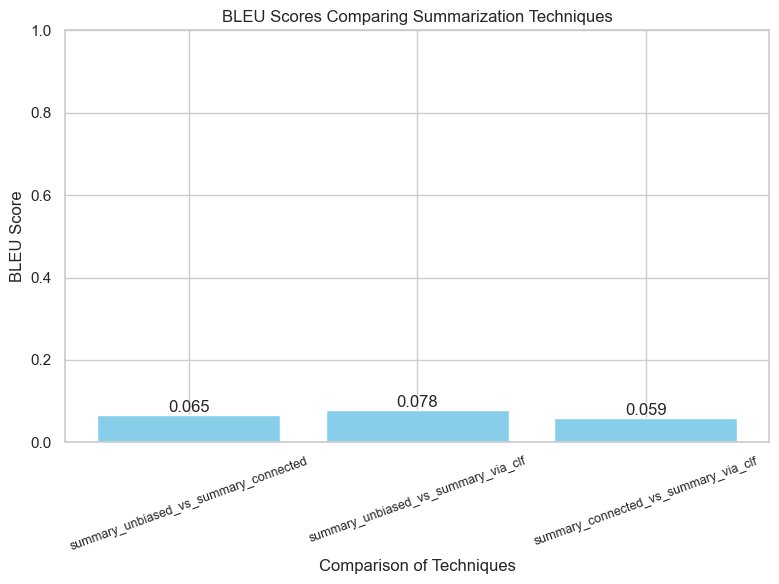

In [89]:
def plot_similarity_scores(scores_dict, ylabel, title):
    

    # Names of the comparison summaries
    labels = list(scores_dict.keys())
    
    # BLEU scores
    scores = [scores_dict[key] for key in labels]
    
    # Position of the bars on the x-axis
    positions = range(len(labels))
    
    # Creating the bar plot
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(positions, scores, color='skyblue')
    
    # Adding labels and title
    ax.set_xlabel('Comparison of Techniques')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=20, fontsize=9)
    ax.set_ylim(0,1)
    
    # Adding the actual value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.3f}", va='bottom', ha='center')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the BLEU scores
ylabel_BLEU = 'BLEU Score'
title_BLEU = 'BLEU Scores Comparing Summarization Techniques'
plot_similarity_scores(bleu_scores, ylabel_BLEU, title_BLEU)

### IMPLEMENT ROUGE SCORES FOR THE SUMMARIES

#### EXAMPLE OF USING ROUGE SCORES

In [79]:
from pprint import pprint

# ROUGE Score
rouge = Rouge()

summary_example_1 = 'Θέλω να πάω βόλτα με το σκύλο αλλά δεν με αφήνει η μαμά'

summary_example_2 = 'η μαμά δεν με αφήνει να παώ βόλτα τον σκύλο αλλά εγώ θέλω'

rouge_score = rouge.get_scores(summary_example_1, summary_example_2)

pprint(rouge_score)

[{'rouge-1': {'f': 0.7199999950079999, 'p': 0.75, 'r': 0.6923076923076923},
  'rouge-2': {'f': 0.3333333283333334,
              'p': 0.3333333333333333,
              'r': 0.3333333333333333},
  'rouge-l': {'f': 0.3199999950080001,
              'p': 0.3333333333333333,
              'r': 0.3076923076923077}}]


In [90]:
# ROUGE Score
rouge = Rouge()
rouge_scores = {}
rouge_scores['summary_unbiased_vs_summary_connected'] = rouge.get_scores(final_summary_74_01_independent, final_summary_74_01_previous_connected)
rouge_scores['summary_unbiased_vs_summary_via_clf'] = rouge.get_scores(final_summary_74_01_independent, final_summary_74_01_classified)
rouge_scores['summary_connected_vs_summary_via_clf'] = rouge.get_scores(final_summary_74_01_previous_connected, final_summary_74_01_classified)

pprint(rouge_scores)

{'summary_connected_vs_summary_via_clf': [{'rouge-1': {'f': 0.27722771777276745,
                                                       'p': 0.27450980392156865,
                                                       'r': 0.28},
                                           'rouge-2': {'f': 0.08766233266254878,
                                                       'p': 0.08823529411764706,
                                                       'r': 0.08709677419354839},
                                           'rouge-l': {'f': 0.2574257375747476,
                                                       'p': 0.2549019607843137,
                                                       'r': 0.26}}],
 'summary_unbiased_vs_summary_connected': [{'rouge-1': {'f': 0.29649595192304623,
                                                        'p': 0.32934131736526945,
                                                        'r': 0.2696078431372549},
                                            'rouge-2

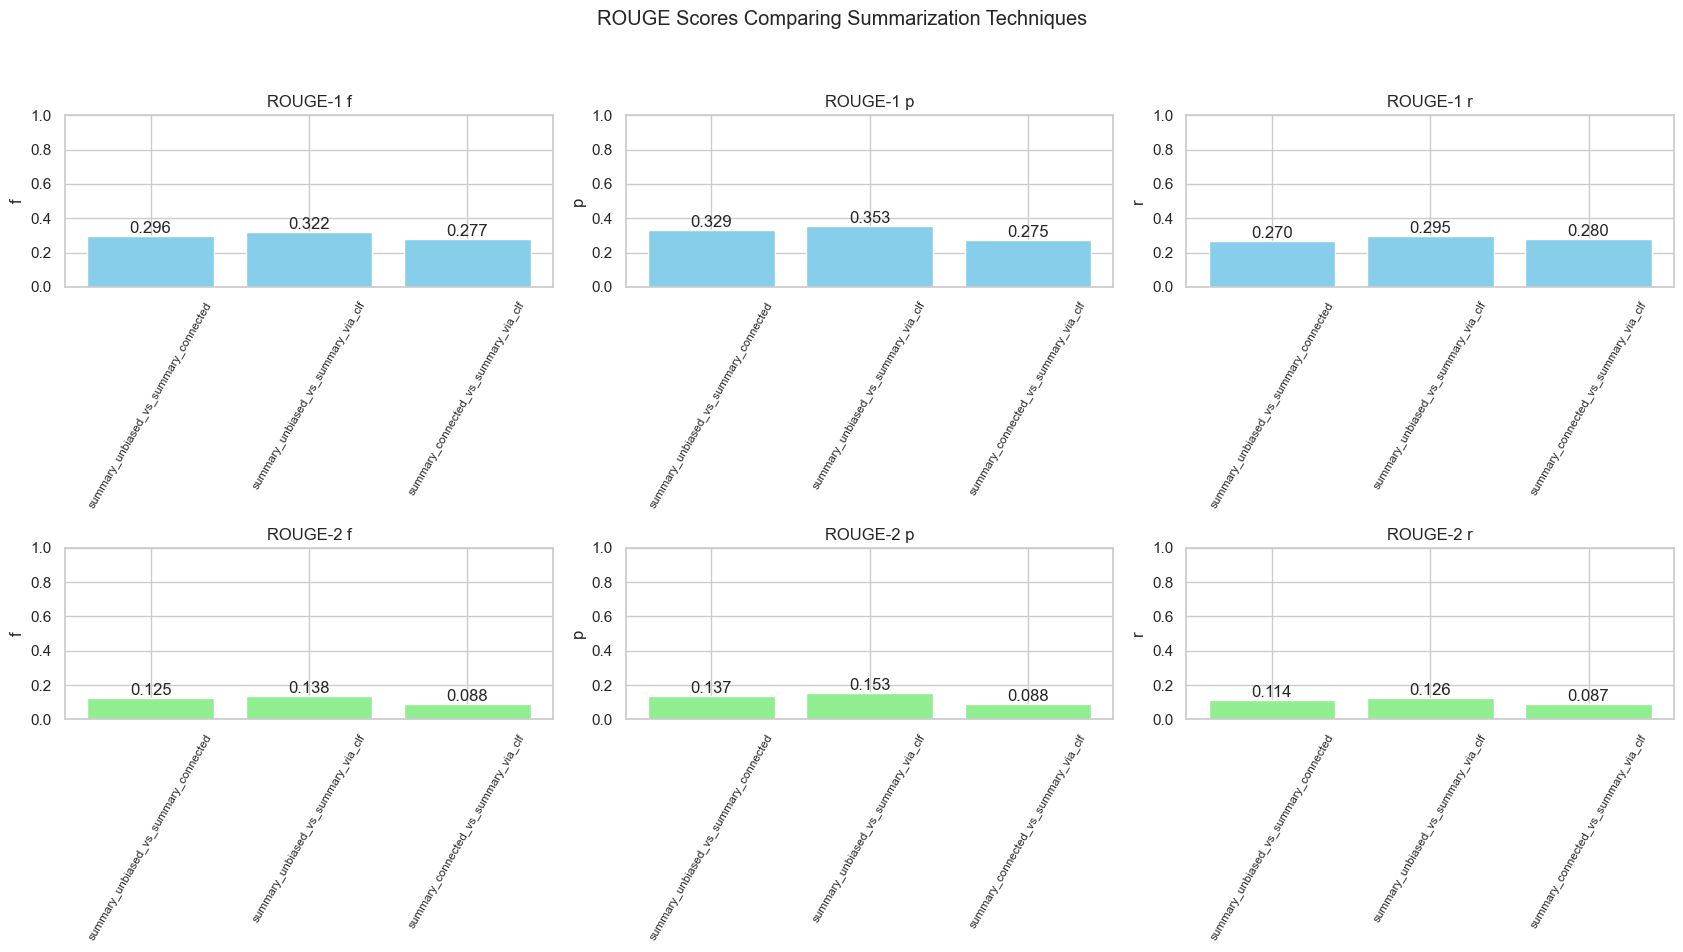

In [98]:
import matplotlib.pyplot as plt

# Extracting ROUGE-1 and ROUGE-2 scores
metrics = ['f', 'p', 'r']  # f-measure, precision, recall
labels = list(rouge_scores.keys())
rouge_1_data = {metric: [] for metric in metrics}
rouge_2_data = {metric: [] for metric in metrics}

for comparison in labels:
    for metric in metrics:
        rouge_1_data[metric].append(rouge_scores[comparison][0]['rouge-1'][metric])
        rouge_2_data[metric].append(rouge_scores[comparison][0]['rouge-2'][metric])

# Position of the bars on the x-axis
positions = range(len(labels))

# Plotting the data
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 10))  # Two rows (ROUGE-1, ROUGE-2), three columns (f, p, r)
fig.suptitle('ROUGE Scores Comparing Summarization Techniques')

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    bars = ax.bar(positions, rouge_1_data[metric], color='skyblue')
    for bar in bars: 
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.3f}", va='bottom', ha='center')
    ax.set_title(f'ROUGE-1 {metric}')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=60, fontsize=8.5)
    ax.set_ylabel(metric)
    ax.set_ylim(0,1)

    ax = axes[1, i]
    bars = ax.bar(positions, rouge_2_data[metric], color='lightgreen')
    for bar in bars: 
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.3f}", va='bottom', ha='center')
    ax.set_title(f'ROUGE-2 {metric}')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=60, fontsize=8.5)
    ax.set_ylabel(metric)
    ax.set_ylim(0,1)

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


### COMPARE THE SUMMARIES VIA COSINE SIMILARITY AND TF-IDF

In [99]:
def greek_tokenizer(document):
    """
    Tokenizer who removes punctuation
    :param document: string which is a text
    :return: tokenized text
    """
    return [token.text for token in nlp(document) if not token.is_space]


# Initialize TfidfVectorizer with the Greek tokenizer
vectorizer = TfidfVectorizer(tokenizer=greek_tokenizer)


X_summaries_comments1_2 = vectorizer.fit_transform([final_summary_74_01_independent, final_summary_74_01_previous_connected])
X_summaries_comments1_3 = vectorizer.fit_transform([final_summary_74_01_independent, final_summary_74_01_classified])
X_summaries_comments2_3 = vectorizer.fit_transform([final_summary_74_01_previous_connected, final_summary_74_01_classified])

cosine_sim_TF_IDF = {}
# Calculate Cosine Similarity
cosine_sim_TF_IDF['summary_unbiased_vs_summary_connected'] = cosine_similarity(X_summaries_comments1_2)[0][1]
cosine_sim_TF_IDF['summary_unbiased_vs_summary_via_clf'] = cosine_similarity(X_summaries_comments1_3)[0][1]
cosine_sim_TF_IDF['summary_connected_vs_summary_via_clf'] = cosine_similarity(X_summaries_comments2_3)[0][1]
for key, value in cosine_sim_TF_IDF.items():
    print(f'Cosine similarity score for the similarity of summaries {key} is: {value:.3f}')

Cosine similarity score for the similarity of summaries summary_unbiased_vs_summary_connected is: 0.745
Cosine similarity score for the similarity of summaries summary_unbiased_vs_summary_via_clf is: 0.786
Cosine similarity score for the similarity of summaries summary_connected_vs_summary_via_clf is: 0.704


C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### PLOT COSINE SIMILARITY SCORES VIA TF-IDF

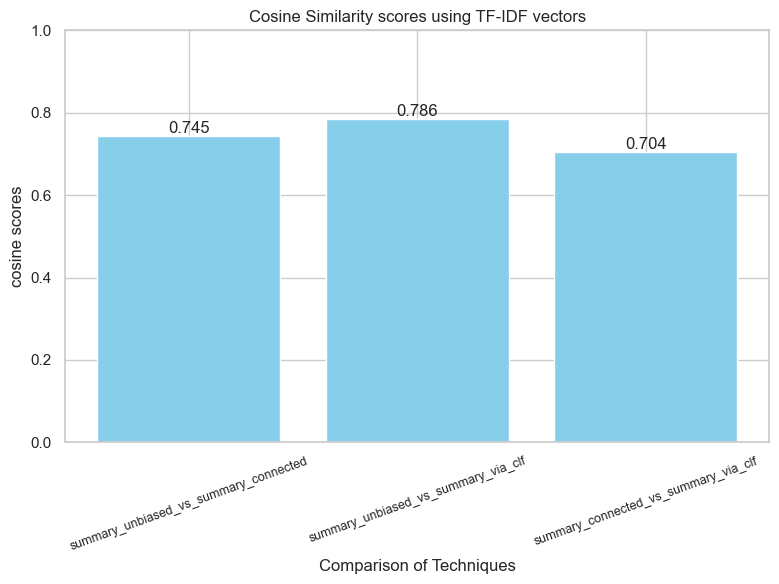

In [100]:
# Plot the cosine similarity scores
ylabel_cos = 'cosine scores'
title_cos = 'Cosine Similarity scores using TF-IDF vectors'
plot_similarity_scores(cosine_sim_TF_IDF, ylabel_cos, title_cos)

### COMPARE THE SUMMARIES VIA COSINE SIMILARITY AND GREEK BERT (MEAN POOLING IN LAST HIDDEN STATE FOR EACH SUMMARY)

In [101]:
%%capture
!pip install transformers==4.38.1
# Check the version of our package *transformer*
import transformers

In [102]:
%%capture
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics torchtext --index-url https://download.pytorch.org/whl/cu118
import torch

In [103]:
print(transformers.__version__)
print(torch.__version__)

4.38.1
2.2.0+cu118


In [104]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

In [105]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Running on GPU.")
    # Put the model on GPU
    model = model.to(device)  # Move the model to the specified device

CUDA is available. Running on GPU.


In [106]:
# Tokenize and encode the texts
input_summary_independent = tokenizer(final_summary_74_01_independent, return_tensors='pt', padding=True, truncation=True)
input_summary_independent.to(device)
input_summary_previous_connected = tokenizer(final_summary_74_01_previous_connected, return_tensors='pt', padding=True, truncation=True)
input_summary_previous_connected.to(device)
input_summary_classified = tokenizer(final_summary_74_01_classified, return_tensors='pt', padding=True, truncation=True)
input_summary_classified.to(device)

# Forward pass through BERT
with torch.no_grad():
    outputs1 = model(**input_summary_independent)
    outputs2 = model(**input_summary_previous_connected)
    outputs3 = model(**input_summary_classified)

# Pool the token-level embeddings
summary1_embedding = torch.mean(outputs1.last_hidden_state, dim=1)
summary2_embedding = torch.mean(outputs2.last_hidden_state, dim=1)
summary3_embedding = torch.mean(outputs3.last_hidden_state, dim=1)

In [108]:
device_cpu = 'cpu'

summary1_embedding_cpu = summary1_embedding.to(device_cpu)
summary2_embedding_cpu = summary2_embedding.to(device_cpu)
summary3_embedding_cpu = summary3_embedding.to(device_cpu)

summary1_embedding_final = np.array(summary1_embedding_cpu)
summary2_embedding_final = np.array(summary2_embedding_cpu)
summary3_embedding_final = np.array(summary3_embedding_cpu)


cosine_sim_BERT = {}
# Calculate Cosine Similarity
cosine_sim_BERT['summary_unbiased_vs_summary_connected'] = cosine_similarity(summary1_embedding_final, summary2_embedding_final)[0][0]
cosine_sim_BERT['summary_unbiased_vs_summary_via_clf'] = cosine_similarity(summary1_embedding_final, summary3_embedding_final)[0][0]
cosine_sim_BERT['summary_connected_vs_summary_via_clf'] = cosine_similarity(summary2_embedding_final, summary3_embedding_final)[0][0]


for key, value in cosine_sim_BERT.items():
    print(f'Cosine similarity score for the similarity of summaries {key}, using BERT tokenizer is: {value:.3f}')

Cosine similarity score for the similarity of summaries summary_unbiased_vs_summary_connected, using BERT tokenizer is: 0.964
Cosine similarity score for the similarity of summaries summary_unbiased_vs_summary_via_clf, using BERT tokenizer is: 0.963
Cosine similarity score for the similarity of summaries summary_connected_vs_summary_via_clf, using BERT tokenizer is: 0.967


### PLOT COSINE SIMILARITY SCORES VIA BERT TOKENIZER

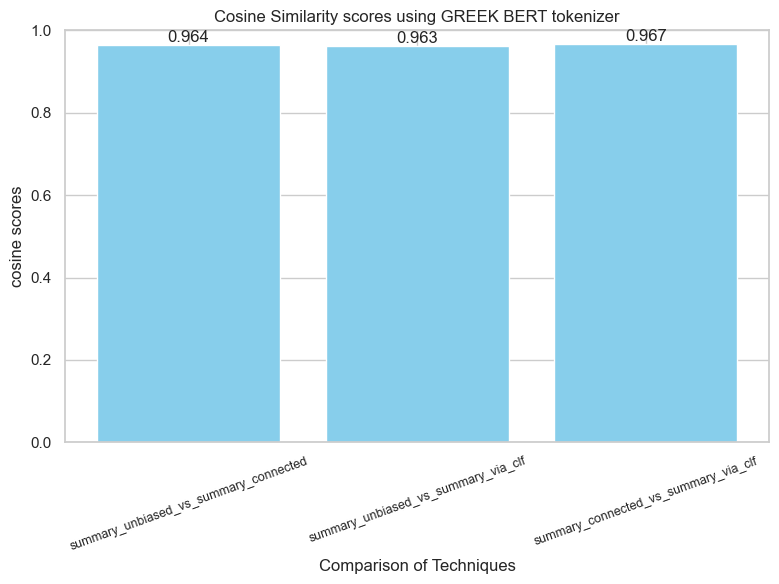

In [109]:
# Plot the cosine similarity scores
ylabel_cos = 'cosine scores'
title_cos = 'Cosine Similarity scores using GREEK BERT tokenizer'
plot_similarity_scores(cosine_sim_BERT, ylabel_cos, title_cos)

## TOPIC EXTRACTION FOR EACH COMMENT

In [112]:
comment = df_74_01.iloc[2]['comments_with_stopwords']
print(comment)

εύχομαι το συγκεκριμένο άρθρο να γίνει και νόμος του κράτους αφού θα δίνει το δικαίωμα σε αξιωματικούς με μεγάλη επαγγελματική εμπειρία και γνώσης να συνεχίσουν να προσφέρουν στις ένοπλες δυνάμεις όταν άλλη συνάδελφοι τους έφευγαν μεταξύ 25 και 30 χρονών υπηρεσίας για να προλάβουν να πάρουν μεγαλύτερη σύνταξη και εφάπαξ


In [205]:
import time

length_coms = len(df_74_01)
keywords_GPT = []
for i in tqdm(range(length_coms)):
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    comment = df_74_01.iloc[i]['comments_with_stopwords']
    prompt = f"""
    Hello my good model. I would like you to implement a topic extraction via keywords, in the comment that I will provide you. 
    The comment is about a law article with title: "Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων". 
    Please do not use more than seven (7) keywords and also I would like the keywords to be in Greek language.
    I will provide you the keywords of previous comments for the same topic, in order to be able to provide similar keywords.
    Here are some examples of how you must create a keyword extraction based on their insights:
    Example comment 1: 
    'εξέλιξη που δίνει την δυνατότητα σε στελέχη να παραμένουν ενεργά να προσφέρουν με την εμπειρία τους και να 
    αποτελούν παράδειγμα προς μίμηση για τους έλληνες αξιωματικούς'
    Answer 1: 
    ['θετικό σχόλιο', 'εμπειρία', 'αξιωματικοί', 'ενεργά', 'προσφορά', 'παράδειγμα', 'εξέλιξη']
    
    Example comment 2: 
    'εύχομαι το συγκεκριμένο άρθρο να γίνει και νόμος του κράτους αφού θα δίνει το δικαίωμα σε αξιωματικούς 
    με μεγάλη επαγγελματική εμπειρία και γνώσης να συνεχίσουν να προσφέρουν στις ένοπλες δυνάμεις όταν άλλη 
    συνάδελφοι τους έφευγαν μεταξύ 25 και 30 χρονών υπηρεσίας για να προλάβουν να πάρουν μεγαλύτερη σύνταξη και εφάπαξ'
    Answer 2: 
    ['θετικό σχόλιο','δικαίωμα', 'εμπειρία', 'προσφορά', 'σύνταξη', 'υπηρεσία']
    Please in your answer provide only the array of keywords.
    Here is the previous keywords: {keywords_GPT[-10:]} 
    Here is the comment: {comment}
    """
    keywords_GPT.append(GPT_prompts.make_prompts(prompt))
    if i==int(length_coms/2):
        time.sleep(20)

  1%|█▏                                                                                                                                            | 1/123 [00:01<03:46,  1.86s/it]

['εξέλιξη', 'ενεργά', 'προσφορά', 'εμπειρία', 'παράδειγμα', 'άξιοματικοί', 'μίμηση']


  2%|██▎                                                                                                                                           | 2/123 [00:03<03:43,  1.85s/it]

['ευχάριστη', 'εξέλιξη', 'συνάδελφοι', 'ενέργεια', 'σύνταξη', 'κατηγορία', 'πολίτες']


  2%|███▍                                                                                                                                          | 3/123 [00:07<05:09,  2.58s/it]

['θετικό σχόλιο', 'δικαίωμα', 'εμπειρία', 'προσφορά', 'σύνταξη', 'υπηρεσία', 'ένοπλες δυνάμεις']


  3%|████▌                                                                                                                                         | 4/123 [00:08<04:25,  2.23s/it]

['εξέλιξη', 'ενεργά', 'προσφορά', 'εμπειρία', 'παράδειγμα', 'αξιωματικοί', 'μίμηση']


  4%|█████▊                                                                                                                                        | 5/123 [00:10<04:02,  2.05s/it]

['εξέλιξη', 'εμπειρία', 'προσφορά', 'υπηρεσίες', 'δυνατότητα', 'ανθρώπους', 'οικογένειες']


  5%|██████▉                                                                                                                                       | 6/123 [00:12<03:43,  1.91s/it]

['πολιτική', 'ηγεσία', 'εμπειρότεροι', 'στελέχη', 'δίκαιο', 'υπηρεσία', 'γνώσεις']


  6%|████████                                                                                                                                      | 7/123 [00:13<03:22,  1.75s/it]

['προσφορά', 'νέοι', 'άνθρωποι', 'εμπειροί', 'μπράβο', 'εξέλιξη', 'μακάρι']


  7%|█████████▏                                                                                                                                    | 8/123 [00:15<03:15,  1.70s/it]

['εξέλιξη', 'ενεργός', 'εμπειρία', 'προσφορά', 'συνάδελφοι', 'αποζημίωση', 'κατηγορία']


  7%|██████████▍                                                                                                                                   | 9/123 [00:17<03:26,  1.81s/it]

['νομοθέτης', 'αξιωματικοί', 'εθνικής καταγωγής', 'υπηρεσία', 'αποστρατεία', 'ηλικία', 'στράτευμα']


  8%|███████████▍                                                                                                                                 | 10/123 [00:19<03:40,  1.95s/it]

['αποζημίωση', 'καθήκοντα', 'επιδόματα', 'κινδύνου', 'ψυχολογική κατάσταση', 'εξουδετέρωσεις', 'καταδύσεις']


  9%|████████████▌                                                                                                                                | 11/123 [00:21<03:28,  1.86s/it]

['εξέλιξη', 'προσφορά', 'εμπειρία', 'αξιωματικοί', 'θετικό σχόλιο', 'μίμηση', 'νόμος']


 10%|█████████████▊                                                                                                                               | 12/123 [00:23<03:41,  2.00s/it]

['πολιτική', 'ηγεσία', 'υπουργείο', 'εθνική άμυνα', 'στελέχη', 'επαγγελματική κατάρτιση', 'συνταξιούχοι']


 11%|██████████████▉                                                                                                                              | 13/123 [00:25<03:33,  1.94s/it]

['κοινωνία', 'σύνταξη', 'επαγγελματική', 'εμπειρία', 'υπηρεσία', 'στράτευμα', 'γνώση']


 11%|████████████████                                                                                                                             | 14/123 [00:27<03:23,  1.86s/it]

['εξέλιξη','ευχάριστη','νόμος','κράτους','μακάρι','παραμείνουν','επιθυμούν']


 12%|█████████████████▏                                                                                                                           | 15/123 [00:28<03:13,  1.79s/it]

['πολιτική', 'ηγεσία', 'έμπειρα', 'στελέχη', 'εργάσιμοι', 'υπηρεσίες', 'κοινωνική']


 13%|██████████████████▎                                                                                                                          | 16/123 [00:30<03:27,  1.94s/it]

['εθνικά ωφέλιμο', 'επαγγελματικά ορθό', 'αξιωματικοί', 'πορεία', 'εθνική άμυνα', 'κοινωνική αδικία', 'ασφαλιστικές εισφορές']


 14%|███████████████████▍                                                                                                                         | 17/123 [00:33<03:34,  2.02s/it]

['επιθυμούν', 'στράτευμα', 'άδικο', 'αξιωματικοί', 'κατηγορία', 'σωμάτων', 'αποφοίτους']


 15%|████████████████████▋                                                                                                                        | 18/123 [00:34<03:11,  1.82s/it]

['έκπληξη', 'υπηρεσία', 'προσφορά', 'όραμα', 'μάρτυρες', 'σύνταξη', 'μισθός']


 15%|█████████████████████▊                                                                                                                       | 19/123 [00:36<03:02,  1.76s/it]

['υπηρεσία', 'γνώσεις', 'εμπειρία', 'στελέχη', 'πρόβλεψη', 'προσόντα', 'εξωτερικό']


 16%|██████████████████████▉                                                                                                                      | 20/123 [00:37<02:58,  1.73s/it]

['υπηρεσία','γνώσεις','εμπειρία','στελέχη','επωφεληθεί','πρόβλεψη','εξωτερικό']


 17%|████████████████████████                                                                                                                     | 21/123 [00:39<02:50,  1.67s/it]

['εφεδρεία', 'ικανά στελέχη', 'προσφορά', 'στράτευμα', 'τερματισμός', 'υποχρεωτική', 'εμπειρία']


 18%|█████████████████████████▏                                                                                                                   | 22/123 [00:41<02:50,  1.68s/it]

['εξέλιξη', 'προσφορά', 'υπηρεσίες', 'κοινωνική', 'αδικία', 'νομοθέτης', 'στρατευμα']


 19%|██████████████████████████▎                                                                                                                  | 23/123 [00:42<02:41,  1.62s/it]

['θετικό σχόλιο', 'μακάρι', 'νόμος', 'προσφορά', 'εμπειρία', 'γνώσεις', 'κράτους']


 20%|███████████████████████████▌                                                                                                                 | 24/123 [00:43<02:36,  1.58s/it]

['αποτυχία', 'οβα', 'διώξει', 'μισθός', 'σύνταξη', 'στράτευμα', 'άρθρο']


 20%|████████████████████████████▋                                                                                                                | 25/123 [00:46<02:48,  1.72s/it]


['οικονομική κρίση', 'στράτευμα', 'παραμονή', 'ρύθμιση', 'αποστρατεία', 'προσφύγων', 'προσόντα']


 21%|█████████████████████████████▊                                                                                                               | 26/123 [00:47<02:54,  1.80s/it]


['οικονομική κρίση', 'στράτευμα', 'παραμονή', 'ρύθμιση', 'αποστρατεία', 'προσφύγων', 'προσόντα']


 22%|██████████████████████████████▉                                                                                                              | 27/123 [00:49<02:47,  1.74s/it]

['νομοσχέδιο', 'στελέχη', 'επιθυμούν', 'εμπειρία', 'γνώση', 'υπηρεσίες', '35 χρόνων']


 23%|████████████████████████████████                                                                                                             | 28/123 [00:51<02:43,  1.72s/it]

['δικαιοσύνη', 'ισονομία', 'νομοσχέδιο', 'αξιωματικοί', 'παράγραφο', 'οικονομική κρίση', 'περίοδος']


 24%|█████████████████████████████████▏                                                                                                           | 29/123 [00:53<02:43,  1.74s/it]

['μέτρο', 'αξιωματικοί', 'ευδοκίμως', 'τακτικές', 'σταδιοδρομία', 'κρίσεις', 'τερματίσαντες']


 24%|██████████████████████████████████▍                                                                                                          | 30/123 [00:54<02:34,  1.67s/it]

['θετική εξέλιξη', 'αναγνώριση', 'εμπειρία', 'γνώση', 'αξιωματικοί', 'νόμος', 'στελέχη']


 25%|███████████████████████████████████▌                                                                                                         | 31/123 [00:55<02:26,  1.59s/it]

['νομοσχέδιο', 'επιθυμούν', 'εμπειρία', 'γνώση', 'υπηρεσίες', 'στελέχη', 'εξωτερικές θέσεις']


 26%|████████████████████████████████████▋                                                                                                        | 32/123 [00:57<02:22,  1.57s/it]

['πολιτική ηγεσία', 'υπηρεσία', 'εμπειρότεροι', 'γνώσεις', 'πατρίδα', 'δικαίωμα', 'παραγωγική']


 27%|█████████████████████████████████████▊                                                                                                       | 33/123 [01:00<03:09,  2.10s/it]

['θετικό σχόλιο', 'δίκαιο', 'εφαρμογή', 'υποχρεωτική', 'επαγγελματική εμπειρία', 'προσφορά', 'γνώση']


 28%|██████████████████████████████████████▉                                                                                                      | 34/123 [01:02<02:55,  1.97s/it]

['εξέλιξη', 'επιθυμούν', 'υπηρεσίες', 'εμπειρία', 'κοινωνική', 'ορίων', 'αποστρατεία']


 28%|████████████████████████████████████████                                                                                                     | 35/123 [01:04<02:54,  1.98s/it]

['κατάργηση', 'υποχρεωτική', 'εφαρμογή', 'αποζημίωση', 'εργαζόμενοι', 'ελεύθερη βούληση', 'εμπειρία']


 29%|█████████████████████████████████████████▎                                                                                                   | 36/123 [01:05<02:37,  1.81s/it]

['υποχρεωτική', 'εφεδρεία', 'στελέχη', 'εμπειρία', 'προσφορά', 'στράτευμα', '35ετίας']


 30%|██████████████████████████████████████████▍                                                                                                  | 37/123 [01:07<02:38,  1.84s/it]

['υποχρεώσεις', 'στελέχη', 'εμπειρία', 'προσφορά', 'ασφαλιστικές εισφορές', 'συνταξιοδότηση', 'κοινωνική αδικία']


 31%|███████████████████████████████████████████▌                                                                                                 | 38/123 [01:09<02:29,  1.75s/it]

['προτεινόμενο', 'σχέδιο', 'νόμος', 'άρθρο', 'εθνικό', 'επαγγελματικό', 'κοινωνικό']


 32%|████████████████████████████████████████████▋                                                                                                | 39/123 [01:11<02:25,  1.74s/it]

['αποκατάσταση', 'αδικία', 'νόμος', 'ένταξη', 'καταταγέντες', 'μέτρο', '1990']


 33%|█████████████████████████████████████████████▊                                                                                               | 40/123 [01:12<02:27,  1.78s/it]

['κοινωνική πολιτική', 'συντάξεις', 'μισθός', 'αποστρατεία', 'προσόντα', 'εμπειρία', 'στελέχη']


 33%|███████████████████████████████████████████████                                                                                              | 41/123 [01:15<02:33,  1.87s/it]


    ['εοθ', 'νομοθεσία', 'αντικτύπων', 'προαγωγή', 'θέσεις διοίκησης', 'κοινωνική αδικία', 'συνταγματάρχες']


 34%|████████████████████████████████████████████████▏                                                                                            | 42/123 [01:16<02:29,  1.85s/it]

['αδικία', 'εξαίρετο', 'πρόωρη αποστράτευση', 'επαναπρόταση', 'εντολές επιθυμούν', 'εύσημο', 'προθέσεις']


 35%|█████████████████████████████████████████████████▎                                                                                           | 43/123 [01:18<02:28,  1.86s/it]

['εξέλιξη', 'συνεχίσουν', 'προσφορά', 'εμπειρία', 'υπηρεσίες', 'κατάταξη', 'αποκατάσταση']


 36%|██████████████████████████████████████████████████▍                                                                                          | 44/123 [01:20<02:27,  1.87s/it]


['εξέλιξη', 'συνεχίσουν', 'προσφορά', 'εμπειρία', 'υπηρεσίες', 'κατάταξη', 'αποκατάσταση']


 37%|███████████████████████████████████████████████████▌                                                                                         | 45/123 [01:22<02:24,  1.86s/it]

['αποστρατευμένοι', 'ανισότητα', 'ισότητα', 'υπουργός', 'επιστροφή', 'ευδοκίμως', 'αποφασιστικότητα']


 37%|████████████████████████████████████████████████████▋                                                                                        | 46/123 [01:24<02:22,  1.85s/it]

['αποστρατευμένοι', 'ευδοκίμως', 'ανισότητα', 'επιστροφή', 'επιθυμούν', 'ευθύνη', 'ευκαιρία']


 38%|█████████████████████████████████████████████████████▉                                                                                       | 47/123 [01:25<02:16,  1.80s/it]

['στράτευμα', 'αποστρατευμένοι', 'επιστροφή', 'μισθός', 'εφάπαξ', 'ειδικές κατηγορίες', 'θέσεις']


 39%|███████████████████████████████████████████████████████                                                                                      | 48/123 [01:27<02:10,  1.74s/it]

['νομοσχέδιο', 'πρόλαβα', 'αναγωνίως', 'υπηρεσίες', 'υπομονή', 'υποκρισία', 'επιθυμούσα']


 40%|████████████████████████████████████████████████████████▏                                                                                    | 49/123 [01:29<02:17,  1.86s/it]

['αποστράτευση', 'επαγγελματική εμπειρία', 'προσφορά', 'κοινωνική πολιτική', 'αξιωματικοί', 'υπηρεσίες', 'αγορά οπλικών συστημάτων']


 41%|█████████████████████████████████████████████████████████▎                                                                                   | 50/123 [01:31<02:10,  1.79s/it]

['επαγγελματικό', 'κοινωνικό', 'ωφέλιμο', 'επίπεδο', 'προκλήσεις', 'ενόπλων δυνάμεων', 'εμπειρία']


 41%|██████████████████████████████████████████████████████████▍                                                                                  | 51/123 [01:33<02:17,  1.91s/it]

['εξέλιξη', 'υπηρεσίες', 'κατάταξη', 'διοίκηση', 'αδικία', 'ανισότητα', 'διοικητικός']


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 52/123 [01:36<02:41,  2.28s/it]

['θετικό σχέδιο', 'εμπειρία', 'προσφορά', 'εργασιακή ισονομία', 'ενόπλες δυνάμεις', 'καταφανής αδικία', 'συναταξιοδώτηση']


 43%|████████████████████████████████████████████████████████████▊                                                                                | 53/123 [01:38<02:29,  2.14s/it]

['νομοσχέδιο', 'δυνατότητα', 'ένοπλες δυνάμεις', 'συνταξιοδοτική πράξη', 'επιστροφή', 'ενεργό υπηρεσία', 'στελέχη']


 44%|█████████████████████████████████████████████████████████████▉                                                                               | 54/123 [01:40<02:19,  2.01s/it]

['νομοσχέδιο', 'αξιωματικοί', 'τακτικές κρίσεις', 'ευδοκίμως', 'πρόωρα', 'θέλησή', 'επιβάλλει']


 45%|███████████████████████████████████████████████████████████████                                                                              | 55/123 [01:42<02:18,  2.04s/it]

['εμπειρία', 'στελέχη', 'προσφορά', 'επαγγελματική κατάρτιση', 'θέσεις', 'τοποθέτηση', 'οικονομικά οφέλη']


 46%|████████████████████████████████████████████████████████████████▏                                                                            | 56/123 [01:44<02:10,  1.95s/it]

['νόμος', 'στελέχη', 'ευδόκιμος', 'δίκαιο', 'σχέδιο', 'ισότιμο', 'επιθυμούν']


 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 57/123 [01:45<02:02,  1.86s/it]

['προτεινόμενο', 'νόμος', 'εξέλιξη', 'συναδέλφους', 'υπηρεσίες', 'εμπειρία', 'κοινωνικά']


 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 58/123 [01:47<02:00,  1.85s/it]

['εξέλιξη', 'συναδέλφους', 'υπηρεσίες', 'κατάταξη', 'αδικία', 'διοικητικός', 'βαθμολογική']


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 59/123 [01:50<02:13,  2.09s/it]

['αδικία', 'κατάταξη', 'νομοθεσία', 'αποκατάσταση', 'ενέργεια', 'μέτρο', 'επιπλέον']


 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 60/123 [01:51<02:01,  1.92s/it]

['αποκατάσταση', 'αδικία', 'κατάταξη', 'νόμος', 'ψαλίδα', 'ενταξη', ' μέτρο']


 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 61/123 [01:54<02:12,  2.13s/it]

['εξέλιξη', 'υπηρεσίες', 'κατάταξη', 'βαθμολογική', 'αποκατάσταση', 'αδικία', 'ισότιμο']
['άρθρο', 'ένστολοι', 'συνταξιοδοτούνται', 'εργασιακός βίος', 'σύνταξη', 'πλήρη συντάξιμα έτη', 'ευδοκίμως τερματίσαντες']


 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 63/123 [02:27<08:16,  8.28s/it]

['γηρασμένο προσωπικό', 'σύνταξη', 'υπηρεσία', 'προσφορά', 'αποστρατεία', 'ενδιαφέρον', 'ενδεχομένως']


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 64/123 [02:29<06:08,  6.25s/it]

['νομοσχέδιο', 'προετοιμασία', 'ευδοκίμως', 'αίτηση', 'εννοείται', 'σκεφτείτε', 'προσταμενοι']


 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 65/123 [02:30<04:39,  4.82s/it]

['κατηγορία', 'προσωπικό', 'εφαρμογή', 'αναδρομικά', 'αξιωματικοί', 'αδικία', 'θέσεις']


 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 66/123 [02:32<03:44,  3.94s/it]

['συγχαρητήρια', 'πολιτική ηγεσία', 'στρατιωτική ηγεσία', 'καιροί', 'υλοποίηση', 'πολιτεία', 'αντίληψη']


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                | 67/123 [02:34<03:03,  3.29s/it]

['σχέδιο', 'νόμος', 'εξέλιξη', 'συναδέλφους', 'επιθυμούν', 'υπηρεσίες', 'κοινωνικά']


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 68/123 [02:35<02:27,  2.68s/it]

['θεματα', 'καρεκλες', 'ρυθμιστουν', 'δικαιουχοι', 'εφαπαξ', 'θεσεις', 'διοικουν']


 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 69/123 [02:37<02:04,  2.30s/it]

['ικανός', 'αξίζει', 'υπηρεσία', 'προφορά', 'απόστρατος', 'καρέκλα', 'σκεπτικό']


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 70/123 [02:39<01:54,  2.16s/it]

['θετικό βήμα', 'έμψυχο δυναμικό', 'αναδιαρθρώσει', 'εμπειρία και γνώσεις', 'συνεισφέροντας', 'συμβαδίζει', 'συνταξιοδότησης']


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 71/123 [02:40<01:43,  1.99s/it]

['αξιωματικοί', 'εμπειρία', 'υπηρεσία', 'αξιοποίηση', 'επιδόματα', 'εκτέλεση', 'αναγκες']


 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 72/123 [02:42<01:37,  1.90s/it]

['νομοσχέδιο', 'αξιωματικοί', 'συνάδελφοι', 'κοινωνικά', 'σωμάτων', 'διακριτικά', 'αποκλειστικά']


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 73/123 [02:44<01:32,  1.85s/it]

['συνάδελφοι', 'υπηρεσίες', 'εξέλιξη', 'βαθμολογική εξέλιξη', 'αδικία', 'αξιοποίηση', 'κλιμάκωση']


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 74/123 [02:47<01:54,  2.34s/it]

['θέσεις', 'αξιωματικοί', 'ενόπλες δυνάμεις', 'οργανικές θέσεις', 'ισότητα', 'επιθυμούν', 'συνταγματάρχης']


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 75/123 [02:49<01:40,  2.09s/it]

['νομοθετήματα', 'προβλήματα', 'επίλυση', 'έναρξη', 'εξέλιξη', 'προκύψει', 'βήματα']


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 76/123 [02:51<01:37,  2.07s/it]

['δικαιοσύνη', 'αξιωματικοί', 'αποστρατεύτηκαν', 'συμπεριλάβει', 'αξιοκρατία', 'νομοσχέδιο', 'διαφορά']


 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 77/123 [02:52<01:27,  1.90s/it]

['σχέδιο', 'νόμος', 'εξέλιξη', 'συναδέλφους', 'επιθυμούν', 'υπηρεσίες', 'στρατιωτικοί']


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 78/123 [02:54<01:26,  1.91s/it]

['αξιοκρατία', 'εξέλιξη', 'βαθμολογική', 'προτάσεις', 'αποφάσεις', 'νομοσχέδιο', 'συνδραμονη']


 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 79/123 [02:57<01:32,  2.10s/it]

['θετικό βήμα','έμψυχο δυναμικό','αναδιαρθρώσει','εμπειρία και γνώσεις','συνεισφέροντας','συμβαδίζει','συνταξιοδότησης']


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 80/123 [02:58<01:23,  1.94s/it]

['ελπίζω', 'εμπειρία', 'επαγγελματική κατάρτιση', 'στελέχη', 'νόμος', 'οικονομικά οφέλη', 'πρόταση']


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 81/123 [03:01<01:31,  2.18s/it]

['υπηρετούν', 'δικαίωμα', 'επιθυμούν', 'κυβέρνηση', 'σχόλια', 'συνάδελφοι', 'προτάσεις']


 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 82/123 [03:02<01:20,  1.96s/it]

['υπηρεσία', 'δικαίωμα', 'αναφορά', 'επιθυμούν', 'συμπλήρωση', 'προσφορά', 'αποστράτευση']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 83/123 [03:04<01:14,  1.86s/it]

['υπηρεσία', 'στρατιωτικοί', 'αποστράτευση', 'οικογένεια', 'πρόσφορα', 'αξιοποίηση', 'διαφορά']


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 84/123 [03:06<01:11,  1.83s/it]

['στελέχη', 'πολιτική ηγεσία', 'αξιοποιηθούν', 'πατρίδα', 'ηλικιακά', 'πρωτοβουλία', 'απόφαση']


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 85/123 [03:07<01:07,  1.76s/it]

['εξέλιξη', 'νόμος', 'ελπίδα', 'ψηφίσει', 'αυτοπροστασία', 'υπουργός', 'μάρτιος']


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 86/123 [03:09<01:04,  1.73s/it]

['νομοσχέδιο', 'δικαιοσύνη', 'αξιωματικοί', 'αποστρατευτεί', 'σύνταγμα', 'ισότητα', 'αποστράτευση']


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 87/123 [03:11<00:59,  1.64s/it]

['υπηρετησει', 'επιτελεια', 'προσφορα', 'μοναδες', 'ειδικοτητες', 'νοοτροπια', 'μισθου']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 88/123 [03:13<01:02,  1.78s/it]

['νομοσχέδιο', 'στελέχη', 'ένοπλες δυνάμεις', 'συνταξιοδοτική πράξη', 'επιστρέψουν', 'ενεργό υπηρεσία', 'υπεθα']


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 89/123 [03:14<00:58,  1.73s/it]

['45 ετών', 'στράτευμα', 'μισθός', 'σύνταξη', 'πρόσληψη', 'καταπολέμηση ανεργίας', 'επικίνδυνο']


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 90/123 [03:16<00:58,  1.76s/it]

['επιθυμεί', 'υπηρεσία', 'καθεστώς', 'εργασιακό', 'επίδομα', 'κινδύνου', 'επικινδυνότητας']


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 91/123 [03:19<01:10,  2.20s/it]


['θετική εξέλιξη', 'συντήρηση', 'αξιόμαχο', 'επαγγελματική εμπειρία', 'εθνικό συμφέρον', 'κοινωνική ανισότητα', 'πολιτική ηγεσία']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 92/123 [03:21<01:02,  2.01s/it]

['δεσμευση', 'αξιωματικοί', 'αποστρατευτηκαν', 'προσφορά', 'θεληση', 'συνταγματαρχες', 'κρίση']


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 93/123 [03:23<00:59,  1.98s/it]

['θετική εξέλιξη', 'εμπειρίες', 'επιθυμούν', 'πολύτιμη γνώση', 'παραγωγική ηλικία', 'σταδιοδρομία', 'ευθύνης']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 94/123 [03:24<00:54,  1.86s/it]

['ανθρώπους', 'αποστρατευτούν', 'προσφορά', 'νέοι', 'υπηρεσίες', 'πρόβληματα', 'προσωπικό']


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 95/123 [03:26<00:50,  1.81s/it]

['νόμος', 'πρωτοβουλία', 'δεσμεύσεις', 'υπηρεσία', 'μεταθέσεις', 'συντάξιμα', 'εργασιακή']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 96/123 [03:28<00:47,  1.75s/it]

['υπουργός', 'έντιμη στάση', 'ευαισθησία', 'συνάδελφοι', 'μαντινάδα', 'πράξεις', 'πρόταση']


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 97/123 [03:29<00:42,  1.64s/it]

['θετικό', 'εμπειρία', 'επανδρωση', 'θέσεις', 'επιτελεία', 'γραμμή', 'νεοτεροι']


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 98/123 [03:31<00:42,  1.69s/it]

['στελέχη', 'υπηρεσία', 'συνεχίσουν', 'παραγωγικές σχολές', 'συντάξεις', 'επιθυμούν', 'εδ καθώς']


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 99/123 [03:33<00:41,  1.75s/it]


['προαγωγή', 'εξέλιξη', 'υπηρεσία', 'αποστρατεύει', 'επόμενος βαθμός', 'εναλλακτικοί όροι', 'νομοσχέδιο']


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 100/123 [03:34<00:38,  1.68s/it]

['υπουργέ', 'στελέχη', 'υπηρεσία', 'παραμονή', 'εδ', 'εφάπαξ', 'μεταθέσεις']


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 101/123 [03:36<00:39,  1.80s/it]

['δικαιοσύνη', 'νόμος', 'αξιωματικοί', 'υπαξιωματικοί', 'αποστρατεύονται', 'συνταξη', 'νομοσχέδιο']


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 102/123 [03:38<00:36,  1.74s/it]

['δικαιοσύνη', 'εφάπαξ', 'συναδέλφοι', 'πολιτική ηγεσία', 'σύνταξη', 'συγχαρητήρια', 'προσφορά']


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 103/123 [03:39<00:33,  1.68s/it]

['νομοσχέδιο', 'ισότητα', 'αξιωματικοί', 'αποστρατευμένοι', 'σύνταγμα', 'ευδοκίμως', 'διαφορά']


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 104/123 [03:41<00:31,  1.68s/it]

['νόμος', 'στελέχη', 'ευδόκιμος', 'παραμένουν', 'πρόβλημα', 'δικαιοσύνη', 'ισότιμο']


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 105/123 [03:43<00:28,  1.60s/it]

['αποσκοπεί', 'υποβιβάσει', 'αλλαγές', 'εισπρακτικό', 'τρικ', 'καταρακωμένο', 'ηθικό']


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 106/123 [03:45<00:30,  1.77s/it]

['νεαρότερα στελέχη', 'αξιολόγηση', 'χαμηλά προσόντα', 'απομάκρυνση', 'συμβούλιο κρίσεων', 'αίτηση', 'παραμονή']


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 107/123 [03:47<00:30,  1.89s/it]

['σχέδιο νόμου', 'συνταξιοδοτικό σύστημα', 'αναπλήρωση', 'ασφαλιστικό νόμο', 'ηλικιακά όρια', 'στρατιωτικοί', 'επιτελεία']


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 108/123 [03:48<00:26,  1.76s/it]

['νόμος', 'εφαρμοστικότητα', 'επιτελεία', 'ρεαλιστικά', 'αξιωματικοί', 'αίτηση', 'πάρεις']


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 109/123 [03:50<00:25,  1.83s/it]

['δεσμεύσεις', 'αξιωματικοί', 'αποχώρηση', 'στρατεύμα', 'πρόβλημα', 'ισότητα', 'συνταγματάρχες']


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 110/123 [03:52<00:23,  1.84s/it]

['δικαίωμα', 'εμπειρία', 'αξιωματικοί', 'προσφορά', 'νόμος', 'νόμος κράτους', 'επαγγελματική εμπειρία']


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 111/123 [03:54<00:21,  1.75s/it]

['πολιτική ηγεσία', 'αναγνωρίζει', 'στελέχη', 'προσφορά', 'σύνταξη', 'αδικία', 'αρνήθηκαν']


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 112/123 [03:55<00:18,  1.72s/it]

['δικαίωμα', 'εργασιακός βίος', 'νομοσχέδιο', 'προβλήματα', 'στρατιωτικό βίο', 'τιμή', 'συνταξιούχοι']


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 113/123 [03:58<00:18,  1.84s/it]

['δικαιοσύνη', 'αξιωματικοί', 'νομοθεσία', 'αποστρατεύσεις', 'εφαρμογή', 'ηλικιακό όριο', 'υπηρεσία']


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 114/123 [03:59<00:15,  1.77s/it]

['νόμος', 'στράτευμα', 'συνταγματάρχης', 'αντισυνταγματική', 'υπουργέ', 'ανεργία', 'προϋπολογισμός']


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 115/123 [04:01<00:13,  1.73s/it]


['νομος', 'υπηρεσία', 'προσφορα', 'ανθρωποι', 'νεα ιδεες', 'αποστρατεύσεις', 'ανεργία']


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 116/123 [04:03<00:12,  1.85s/it]

['νόμος', 'αξιωματικοί', 'αποστρατεύσεις', 'ισότητα', 'δικαιοσύνη', 'δικαιώματα', 'πρόσφατα']


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 117/123 [04:05<00:11,  1.94s/it]

['σχέδιο νόμου', 'αναπλήρωση', 'ασφαλιστικό νόμο', 'ηλικιακά όρια', 'στρατιωτικοί', 'προσαρμογή', 'συνταξιοδοτικό σύστημα']


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 118/123 [04:07<00:09,  1.81s/it]

['υπουργός', 'εφαρμογή', 'πρόληψη', 'κρίσεις', 'γνώση', 'εμπειρία', 'κρίσεις 2017']


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 119/123 [04:08<00:06,  1.72s/it]

['ασφαλιστικό', 'αποστράτωση', 'σύνταξη', 'υπηρεσία', 'εθνική', 'κρίση', 'άρθρο']


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 120/123 [04:10<00:05,  1.78s/it]

['ασφαλιστικό', 'σύνταξη', 'νομοσχέδιο', 'αναπλήρωση', 'ηλικιακά όρια', 'στρατιωτικοί', 'επαγγέλματος']


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 121/123 [04:12<00:03,  1.77s/it]

['αποστρατεύσεις', 'δικαιολογία', 'ανθρώπους', 'προσφορά', 'προβλήματα', 'υπουργές', 'δυναμικοί']


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 122/123 [04:14<00:01,  1.86s/it]

['σχέδιο νόμου', 'παράταση', 'εργασιακός βίος', 'αλλαγές', 'ασφαλιστικό', 'κοινωνική δικαιοσύνη', 'αποστράτευση']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [04:16<00:00,  2.08s/it]

['θετική ρύθμιση', 'στελέχη', 'αποστρατεύονται', 'εμπειρία', 'συντάξιμη υπηρεσία', 'σχέδιο νόμου', 'αξιόμαχο']


### EXTRACT TOPIC/INSIGHT FOR EACH COMMENT

In [13]:
import time
from tqdm import tqdm

length_coms = len(df_74_01)
topic_extraction_GPT = []
for i in tqdm(range(length_coms)):
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    comment = df_74_01.iloc[i]['comments_with_stopwords']
    prompt = f"""
    Γεια σου, αγαπητό μοντέλο. Θα ήθελα να αναλύσεις και να εξάγεις τα ειδικά ζητήματα από το σχόλιο που θα σου παραθέσω. 
    Το σχόλιο αφορά ένα νομικό άρθρο με τίτλο 'Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων'. Θα σου δώσω επίσης 
    τα θέματα και ειδικά ζητήματα από τα 10 προηγούμενα σχόλια για το ίδιο θέμα, ώστε να μπορείς να εξάγεις παρόμοιες αναλύσεις εφόσον 
    απαιτηθεί. Παρακαλώ να παρέχεις μόνο μια λίστα με τα ειδικά ζητήματα/λέξεις-κλειδιά χωρίς επιπλέον σχόλια.
    Προηγούμενα θέματα: {topic_extraction_GPT[-10:]}
    Σχόλιο: {comment}
    """

    topic_extraction_GPT .append(GPT_prompts.make_prompts(prompt))
    if i==int(length_coms/2):
        time.sleep(20)

  1%|█▏                                                                                                                                            | 1/123 [00:03<06:18,  3.11s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- εξέλιξη
- στελέχη
- ενεργά
- παράδειγμα προς μίμηση
- αξιωματικοί


  2%|██▎                                                                                                                                           | 2/123 [00:06<06:47,  3.37s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- συναδέλφους
- 35ετία
- συνεχίσουν
- ενέργεια
- στόματα πολιτών
- κατηγορούν
- συνταξιοδότηση


  2%|███▍                                                                                                                                          | 3/123 [00:09<05:58,  2.98s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- νόμος
- επαγγελματική εμπειρία
- ένοπλες δυνάμεις
- σύνταξη
- εφάπαξ


  3%|████▌                                                                                                                                         | 4/123 [00:13<06:58,  3.52s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- συνάδελφοι
- 35ετία
- εμπειρία
- υπηρεσίες
- ειδικές δυνάμεις
- πολεμικό ναυτικό
- αλεξίπτωτο
- οικονομικό επίδομα
- κατάδυση
- παράδειγμα προς μίμηση


  4%|█████▊                                                                                                                                        | 5/123 [00:17<07:15,  3.69s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
- εξέλιξη
- συναδέλφους
- 35ετία
- εμπειρία
- υπηρεσίες
- ε.δ (ειδικές δυνάμεις)
- οικονομική συγκυρία
- πατρίδα
- π.ν (πολεμικό ναυτικό)


  5%|██████▉                                                                                                                                       | 6/123 [00:21<07:36,  3.91s/it]

- πολιτική ηγεσία
- εμπειρότερα εν ενεργεία στελέχη
- υπηρεσία
- αναγνώριση εμπειρίας και γνώσεων
- δίκαιο αίτημα
- συνέχιση υπηρεσίας
- πολυετή υπηρεσία
- παραγωγική ηλικία


  6%|████████                                                                                                                                      | 7/123 [00:23<06:14,  3.23s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- νέοι
- άνθρωποι
- εμπειροί
- προσφορά


  7%|█████████▏                                                                                                                                    | 8/123 [00:28<07:15,  3.79s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- εξέλιξη
- συνάδελφοι
- 35ετία
- εμπειρία
- ε.δ (ειδικές δυνάμεις)
- αποζημίωση
- επιδόματα κινδύνου
- καταδύσεις
- ψυχολογική κατάσταση
- αδικία


  7%|██████████▍                                                                                                                                   | 9/123 [00:31<06:50,  3.60s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- ηλικία 21 ετών
- υπηρεσία 32 έτη
- αποστρατεία σε ηλικία 53 ετών
- λοχαγός
- υποπλοίαρχος


  8%|███████████▍                                                                                                                                 | 10/123 [00:36<07:11,  3.82s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- αποζημίωση
- επιδόματα κινδύνου
- καταδύσεις
- ψυχολογική κατάσταση
- πλήρη παυση
- εξουδέτερωση
- αμοιβή
- πρόταση


  9%|████████████▌                                                                                                                                | 11/123 [00:39<06:39,  3.57s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- επιδόσεις
- αναβάθμιση
- αναγνώριση
- αναμονή
- αναπτυξιακές δυνατότητες


 10%|█████████████▊                                                                                                                               | 12/123 [00:44<07:48,  4.22s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- πολιτική ηγεσία
- υπουργείο εθνικής άμυνας
- ε.δ (ειδικές δυνάμεις)
- στράτευμα
- συνεχίσουν
- εμπειρία
- επαγγελματική κατάρτιση
- στρατιές νεότατων συνταξιούχων
- κοινή γνώμη
- πρόταση νόμου


 11%|██████████████▉                                                                                                                              | 13/123 [00:49<08:10,  4.46s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- σύνταξη
- ηλικία 52 ετών
- εργαζόμενοι
- εργασία έως 67 ετών
- ε.δ (ειδικές δυνάμεις)
- επαγγελματική εμπειρία
- επαγγελματική παραμονή στο στρατευμα
- γνώση
- υπηρεσίας-προσφοράς


 11%|████████████████                                                                                                                             | 14/123 [00:52<07:00,  3.86s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- εξέλιξη
- μακάρι
- νόμος κράτους


 12%|█████████████████▏                                                                                                                           | 15/123 [00:57<07:47,  4.33s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- πολιτική ηγεσία
- ε.δ (ειδικές δυνάμεις)
- εμπειρότερα εν ενεργεία στελέχη
- υπηρεσία
- προσφορά
- κοινωνική ισονομία
- εργασιακή ισονομία
- εργασιακό βίο
- οικονομική κατάταση
- δίχτυ ασφαλείας
- οικογένειες


 13%|██████████████████▎                                                                                                                          | 16/123 [01:06<09:59,  5.60s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- προτεινόμενο σχέδιο νόμου
- εθνικό επαγγελματικό και κοινωνικό επίπεδο
- ενόπλες δυνάμεις
- μείωση νεοπροσλαμβανόμενων
- εμπειρία 35 ετών
- προσφορά
- ανωτάτα συμβούλια
- ιεραρχική δομή
- αύξηση ορίων ηλικίας
- αποστρατεία 53 ετών
- συναποζημίωση
- ασφαλιστικές εισφορές
- μετοχικά ταμεία
- εθνική οικονομία
- ανθρωποκεντρική πολιτική
- πολιτική ηγεσία
- στελέχη ενόπλων δυνάμεων


 14%|███████████████████▍                                                                                                                         | 17/123 [01:10<09:09,  5.18s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- παραμονή στο στράτευμα
- άδικο
- αξιωματικοί κοινών σωμάτων
- απόφοιτοι ΣΣΑ (Στρατιωτική Σχολή Σωμάτων Αξιωματικών)


 15%|████████████████████▋                                                                                                                        | 18/123 [01:15<08:49,  5.04s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- άτομα χωρίς προσφορά
- όραμα
- ενεργός υπηρεσία
- μάρτυρες
- σύνταξη
- μισθός
- ανταμοιβή €150
- απόφοιτοι ΣΣΑ (Στρατιωτική Σχολή Σωμάτων Αξιωματικών)


 15%|█████████████████████▊                                                                                                                       | 19/123 [01:21<09:32,  5.50s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- πρόβλεψη
- υπηρέτηση στο εξωτερικό
- πνεύμα του νόμου
- επωφεληθεί
- γνώσεις
- εμπειρία
- στελέχη
- τυπικά προσόντα
- εκμεταλλεύτηκε
- χώρα
- όφελος
- εδ (ειδικές δυνάμεις)
- προσόντα
- μόρια
- διαγωνιστούν
- θέσεις εξωτερικού


 16%|██████████████████████▉                                                                                                                      | 20/123 [01:28<10:07,  5.90s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- πρόβλεψη
- υπηρέτηση στο εξωτερικό
- πνεύμα του νόμου
- επωφεληθεί
- γνώσεις
- εμπειρία
- στελέχη
- τυπικά προσόντα
- εκμεταλλεύτηκε
- χώρα
- όφελος
- ειδικές δυνάμεις
- προσόντα
- μόρια
- διαγωνιστούν
- θέσεις εξωτερικού


 17%|████████████████████████                                                                                                                     | 21/123 [01:32<08:58,  5.28s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- υποχρεωτική εφεδρεία
- 35ετία
- ικανά στελέχη
- εμπειρία
- προσφορά στο στράτευμα


 18%|█████████████████████████▏                                                                                                                   | 22/123 [01:39<09:43,  5.78s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- συνέχιση υπηρεσίας πέραν της 35ετίας
- προσφορά εμπειρίας και υπηρεσιών
- αύξηση ορίων ηλικίας
- αποστρατεία στα 53 ετών
- κοινωνική αδικία
- αναπροσαρμογή ηλικιακών ορίων
- διορθωτικά μέτρα για ειδικές κατηγορίες αξιωματικών
- διαφορετική μεταχείριση βάσει ηλικίας και υπηρεσίας


 19%|██████████████████████████▎                                                                                                                  | 23/123 [01:42<08:16,  4.96s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- επιτέλους
- κάτι καλό
- μακάρι
- νόμος
- προσφορά
- εμπειρία
- γνώσεις


 20%|███████████████████████████▌                                                                                                                 | 24/123 [01:45<07:26,  4.51s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- οβα 
- διόψεις αποτυχίας
- απόλυση
- μισθός
- σύνταξη
- εποπ
- άρθρο
- στράτευμα


 20%|████████████████████████████▋                                                                                                                | 25/123 [01:55<10:03,  6.16s/it]

Ειδικά θέματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- οικονομική κρίση
- ηλικιακό όριο 58 ετών
- οικειοθελής παραμονή
- ειδικές δυνάμεις (εδ)
- παραμονή σε εδ
- προθεσμίες
- διαδικασία υποβολής αίτησης
- διαδικασία εξέτασης
- αποστρατεία
- αποστρατευτικός βαθμός
- δικαιοσύνη
- ισονομία
- τρόπος υπηρεσίας μετά την αποστρατεία
- τοποθέτηση στις παραμεθόριες περιοχές
- οικονομικά οφέλη


 21%|█████████████████████████████▊                                                                                                               | 26/123 [02:07<12:34,  7.78s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:

- οικονομική κρίση
- νομοσχέδιο
- υπεθα
- παραμονή
- στελέχη
- οικειοθελής παραμονή
- εδ
- προθεσμίες
- αποστρατεία
- αποστρατευτικός βαθμός
- δικαιοσύνη
- ισονομία
- τοποθέτηση
- παραμεθόριες περιοχές
- οικονομικά οφέλη
- διαδικασία υποβολής αίτησης
- εξέταση
- προσφορά εμπειρίας
- διορθωτικά μέτρα
- επαγγελματική καριέρα
- πρόβλεψη
- ηλικιακά όρια
- συμπληρωματική υπηρεσία
- τακτικές κρίσεις
- προσόντα
- τάξεις εδ


 22%|██████████████████████████████▉                                                                                                              | 27/123 [02:10<10:17,  6.43s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- νομοσχέδιο
- ε.δ (ειδικές δυνάμεις)
- στελέχη
- παραμονή
- προσφορά εμπειρίας
- γνώση
- υπηρεσίες


 23%|████████████████████████████████                                                                                                             | 28/123 [02:15<09:18,  5.88s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:  
- δικαιοσύνη  
- ισονομία  
- νομοσχέδιο  
- άρθρο 1  
- αξιωματικοί έτους 2017  
- παράγραφο 4  
- τερματίσαντες σταδιοδρομία  
- πρόσφατα παρελθόντα  
- οικονομική κρίση  


 24%|█████████████████████████████████▏                                                                                                           | 29/123 [02:24<10:29,  6.70s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- αξιωματικοί
- ηλικιακό όριο 58 ετών
- τακτικές κρίσεις
- ευδοκίμως τερματίσαντες
- αξιωματικούς που πρόσφατα κρίθηκαν
- παράγραφο 4
- πρόωρη τερματισμός
- ισχύει μέτρο
- θέληση αξιωματικών
- τερματισμός σταδιοδρομίας


 24%|██████████████████████████████████▍                                                                                                          | 30/123 [02:28<09:13,  5.95s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- θετική εξέλιξη
- αναγνώριση
- μεγάλη εμπειρία
- γνώση
- νόμος
- στελέχη
- ενεργοί
- παραμείνουν ενεργοί
- προσφέρουν


 25%|███████████████████████████████████▌                                                                                                         | 31/123 [02:33<09:00,  5.87s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Νομοσχέδιο
- Εμπειρία
- Γνώση
- Υπηρεσίες
- Στελέχη
- Ειδικές δυνάμεις (ε.δ)
- Παραμονή
- Πέραν των 35 ετών
- Προσφορά
- Δυνατότητα παραμονής
- Αξιωματούχοι
- Τοποθέτηση σε ειδικές θέσεις
- Άρθρο 1
- Ηλικιακά όρια


 26%|████████████████████████████████████▋                                                                                                        | 32/123 [02:38<08:29,  5.60s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- δίκαιο αίτημα
- εμπειρότερα εν ενεργεία στελέχη
- εδ
- υπηρεσία
- αναγνώριση
- πολυετή υπηρεσία
- εμπειρία
- γνώσεις
- δικαίωμα
- συνέχιση υπηρεσίας
- πατρίδα


 27%|█████████████████████████████████████▊                                                                                                       | 33/123 [02:44<08:26,  5.63s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
- υεθα
- κ. καμμένο
- στρατιωτικοί
- 35ετία
- 58ο έτος
- 40 έτη υπηρεσίας
- εφαρμογή μέτρου
- ηλικιακή σύνταξη
- κοινή λογική
- επαγγελματική εμπειρία
- ε.δ
- προσφορά γνώσεων


 28%|██████████████████████████████████████▉                                                                                                      | 34/123 [02:48<07:30,  5.06s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:

- Πέραν των 35 ετών
- Αύξηση ορίων ηλικίας
- Αποστρατεία
- Συνταξιοδότηση
- Κοινωνική αποδοχή
- Κοινωνική αδικία


 28%|████████████████████████████████████████                                                                                                     | 35/123 [02:54<07:52,  5.37s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- υεθα
- κ. καμμένο
- στρατιωτικοί
- 35ετία
- 58ο έτος
- 40 έτη υπηρεσίας
- εφαρμογή μέτρου
- ηλικιακή σύνταξη
- κοινή λογική
- επαγγελματική εμπειρία
- ε.δ
- προσφορά γνώσεων


 29%|█████████████████████████████████████████▎                                                                                                   | 36/123 [02:57<07:00,  4.83s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- υποχρεωτική εφεδρεία
- τερματισμός
- 35ετία
- ικανά στελέχη
- εμπειρία
- προσφορά
- στράτευμα


 30%|██████████████████████████████████████████▍                                                                                                  | 37/123 [03:05<07:57,  5.55s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Ειδικές δυνάμεις (ε.δ)
- Υποχρεώσεις
- Εμπειρία
- Προκλητικότητα
- Στελέχη
- Πατρίδα
- Πυραμίδα ιεραρχίας
- Παραμονή εκτός οργανικών θέσεων
- Ασφαλιστικές εισφορές
- Ορία συνταξιοδότησης
- Αποστρατεία
- Κοινωνική αδικία


 31%|███████████████████████████████████████████▌                                                                                                 | 38/123 [03:10<07:34,  5.34s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:

- προτεινόμενο σχέδιο νόμου
- εθνικό επαγγελματικό επίπεδο
- κοινωνικό επίπεδο
- εθνικά ωφέλιμο
- ενόπλες δυνάμεις
- εμπειρία 35 ετών
- προσφορά
- εθνική άμυνα


 32%|████████████████████████████████████████████▋                                                                                                | 39/123 [03:13<06:33,  4.68s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- αποκατάσταση αδικίας
- καταταγέντες
- ένταξη στο νόμο 2439/1996


 33%|█████████████████████████████████████████████▊                                                                                               | 40/123 [03:20<07:24,  5.35s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- περικοπή συντάξεων
- μισθός
- αποστρατεία
- ειδικές δυνάμεις (ε.δ)
- νέοι ανθρώποι
- προσόντα και ικανότητες
- συσσωρευμένη εμπειρία
- προσφορά
- πυραμίδα των εδ
- προϋπολογισμός
- απάντηση

βασική κατηγορία: αξιωματικοί εκτός οργανικών θέσεων


 33%|███████████████████████████████████████████████                                                                                              | 41/123 [03:33<10:29,  7.68s/it]

Ειδικά θέματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- ε.θ.
- Ν. 3883/2010
- Στρατός
- Συνταγματάρχες
- Επιτελεία
- Διοίκηση
- Διευθυντές
- Αναγκη
- Ηλικία
- Ειδικότητες
- Κοινωνική πολιτική
- Συνταξιούχοι
- Αξιομαχία
- Ασφαλιστικές εισφορές
- Καριέρα
- Κοινωνική δικαιοσύνη
- Προϊστάμενοι
- Αδικία
- Αποστρατεία
- Νεότερες τάξεις
- Μαχητικές θέσεις
- Καριέρα
- Περιμονή
- Κοινωνική πολιτική
- Κυβέρνηση
- Κοινωνικές αλλαγές
- 58 ετών
- Ηλικιακή απόσταση
- Εργασιακή εμπειρία
- Προσφορά
- Ευκαιρίες
- Στρατιωτική δυναμική
- Πλήρωμα
- Πυραμίδα ιεραρχίας
- Καριέρα εκτός οργανικών θέσεων


 34%|████████████████████████████████████████████████▏                                                                                            | 42/123 [03:40<10:09,  7.52s/it]

Από το παραπάνω σχόλιο μπορούν να αναδειχθούν τα παρακάτω ειδικά ζητήματα/λέξεις-κλειδιά:

- Πικρία
- Αδικία
- Συνταγματάρχες
- Αποστρατεία
- Πρόωρη απόσυρση
- Κρίση
- Συνταγματάρχες που επιθυμούν να επιστρέψουν
- Αναγνώριση εμπειρίας
- Καριέρα συνταγματάρχη εκτός οργανικών θέσεων
- Δημοσιότητα στα μέσα ενημέρωσης

(Παρακαλώ ενημερώστε με περαιτέρω σχόλια αν επιθυμείτε περαιτέρω ανάλυση ή επιπλέον πληροφορίες.)


 35%|█████████████████████████████████████████████████▎                                                                                           | 43/123 [03:52<11:51,  8.89s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- Εξέλιξη
- Επάνω στην ηλικία 35ετών
- Εμπειρία
- Υπηρεσίες
- Ειδικές δυνάμεις (ε.δ)
- Κατάταξη
- Νόμος 2439/1996
- Απόστατεια
- Βαθμολογική εξέλιξη
- Αποκατάσταση αδικίας
- Ισότητα
- Δημοσιονομικό κόστος
- Υπαγωγή
- Διοικητικός βαθμός
- Οικονομικά κλιμάκια
- Ιδιαίτερη μνεία στους καταταγέντες του έτους 1990

Αν επιθυμείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 36%|██████████████████████████████████████████████████▍                                                                                          | 44/123 [04:01<11:42,  8.90s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Εξέλιξη
- Υπηρεσίες ε.δ
- Αύξηση ορίων ηλικίας
- Αποστρατεία
- Συνταξιοδότηση
- Κοινωνική αποδοχή
- Κοινωνική αδικία
- Επιθυμούν να συνεχίσουν πέραν της 35ετίας
- Αδικία για τους εισαχθέντες στις στρατιωτικές σχολές το 1990
- Αποκατάσταση αδικίας
- Υπαξιωματικοί εκτός οργανικών θέσεων
- Εμπειρία και προσφορά υπηρεσιών

Αν επιθυμείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 37%|███████████████████████████████████████████████████▌                                                                                         | 45/123 [04:07<10:22,  7.98s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Αδικία
- Ισότητα
- Αποστράτευση
- Υπουργός
- ΜΜΕ
- Επιστροφή
- Αποδοχές
- 58 χρόνια
- Κατώτεροι των 58
- Επιστροφή στην υπηρεσία
- Ευδοκιμία
- Εκφράσει δημόσια
- Τελευταία 5 χρόνια

Εάν επιθυμείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 37%|████████████████████████████████████████████████████▋                                                                                        | 46/123 [04:15<10:16,  8.00s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Υπουργός
- Αποστράτευση
- Ευδοκιμία
- Κατώτεροι των 58
- Επιστροφή στην υπηρεσία
- Προθεση
- Δέσμευση
- Κυρίου υπουργού
- Εοθ
- Θέληση
- Παραγραφος 4
- Τροποποίηση
- Επαναφορά
- Ισότητα
- Ισονομία
- Δικαιοσύνη

Αν επιθυμείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 38%|█████████████████████████████████████████████████████▉                                                                                       | 47/123 [04:21<09:25,  7.44s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Επιστροφή στις ειδικές δυνάμεις (ε.δ)
- Εφάπαξ
- Μισθός
- Στράτευμα
- Γήρας
- Ανθρώποι εκτός οργανικών θέσεων
- Ασθενείς
- Καθισμένοι
- Στρατιωτική υπηρεσία

Αν επιθυμείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 39%|███████████████████████████████████████████████████████                                                                                      | 48/123 [04:26<08:36,  6.88s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- νομοσχέδιο
- υπομονή
- υπηρεσίες
- προσφορά
- επιστροφή
- κύριος υπουργός
- ευκαιρίες

Εάν επιθυμείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 40%|████████████████████████████████████████████████████████▏                                                                                    | 49/123 [04:34<08:42,  7.06s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Ευδοκιμως
- Αποστρατιωμένοι
- Προσφορά
- Στρατιωτικοί
- Προσφορά εργασίας
- Συνωστισμός στα επιτελεία
- Πρωτογενής εργασία
- Ανακύκλωση διαταγών
- Κοινωνική πολιτική
- Αξιομαχία των ειδικών δυνάμεων
- Κοινωνική πολιτική

Αν χρειάζεστε περισσότερες αναλύσεις ή πληροφορίες, παρακαλώ ενημερώστε με.


 41%|█████████████████████████████████████████████████████████▎                                                                                   | 50/123 [04:40<08:14,  6.77s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- Άρθρο
- Εθνικό επαγγελματικό επίπεδο
- Κοινωνικό επίπεδο
- Εθνικά ωφέλιμο
- Ενόπλες Δυνάμεις
- Νεοπροσλαμβανόμενοι
- Εμπειρία 35 ετών
- Προσφορά
- Εθνική άμυνα


 41%|██████████████████████████████████████████████████████████▍                                                                                  | 51/123 [04:47<08:11,  6.82s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:

- Σειρές κατάταξης
- Ν. 2439/96
- Βαθμολογική εξέλιξη
- Αποκατάσταση αδικίας
- Ισότητα
- Δημοσιονομικό κόστος
- Διοικητικός βαθμός
- Οικονομικά κλιμάκια
- Υπαγωγή
- Καταταγέντες 1990

Αν χρειάζεστε περισσότερες αναλύσεις ή πληροφορίες, παρακαλώ ενημερώστε με.


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 52/123 [04:53<07:39,  6.48s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:

- Προτεινόμενο σχέδιο νόμου
- Εθνικά ωφέλιμο
- Ενόπλες Δυνάμεις
- Εμπειρία 35 ετών
- Προσφορά
- Ισονομία
- Αύξηση ορίων ηλικίας
- Αποστρατεία
- Συναταξιοδώτηση
- Κοινωνική αδικία

Αν χρειάζεστε περισσότερες αναλύσεις ή πληροφορίες, παρακαλώ ενημερώστε με.


 43%|████████████████████████████████████████████████████████████▊                                                                                | 53/123 [04:59<07:40,  6.57s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Ενεργό υπηρεσία
- Συνταξιοδοτική πράξη
- Επιστροφή
- Κατώτεροι των 58
- Αποστρατεία
- Επιθυμούν να συνεχίσουν
- Επαναφορά
- Εκπλήρωση υποχρεώσεων
- Στελέχη
- Οπλισμένες δυνάμεις
- Στην υπηρεσία
- Συνταξιούχοι
- Νομοθεσία

Αν χρειάζεστε περισσότερες αναλύσεις ή πληροφορίες, παρακαλώ ενημερώστε με.


 44%|█████████████████████████████████████████████████████████████▉                                                                               | 54/123 [05:05<07:19,  6.36s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Αξιωματικοί
- Κρίσεις τακτικές
- Πρόωρη αποχώρηση
- Ένοπλες Δυνάμεις
- Τροποποίηση παραγράφου
- Εθνική Άμυνα
- Οικονομική κρίση
- Περίοδος οικονομικής κρίσης
- Μέτρο ευδοκίμως
- Υπουργός Εθνικής Άμυνας


 45%|███████████████████████████████████████████████████████████████                                                                              | 55/123 [05:11<07:03,  6.23s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- Ειδικές Δυνάμεις
- Εμπειρία
- Εθνική Άμυνα
- Επαγγελματική κατάρτιση
- Θέσεις ΕΟΤ
- Επικράτεια
- Παραμεθόριες περιοχές
- Οικονομικά οφέλη
- Υποστήριξη προσωπικού
- Πρόσληψη
- Ευνοϊκή διαδικασία
- Νομοθετική πρόταση
- Τροποποίηση νομοθεσίας
- Κρατικός νόμος


 46%|████████████████████████████████████████████████████████████████▏                                                                            | 56/123 [05:23<08:39,  7.75s/it]

- Προσχέδιο νόμου
- Στελέχη
- Ευδόκιμος
- 35ετια
- 58 ετών
- Ισότιμο
- Αφορά
- Τερματίσει
- Σταδιοδρομία
- Κάτω των 58
- Δίκαιο
- Ευδικιμώς
- Πρόβλημα
- Ισότιμο
- Ακόμη
- Τερματίσει
- Πιστεύω
- Πρόβλημα
- Είδικοι
- Άλλοι
- Πρόβλημα
- Τερματίσει
- Ισότιμο
- Αφορά
- Ευδόκιμος
- Τερματίσαντες
- Κάτω των 58
- Ισότιμο
- Δίκαιο
- Ευδικιμώς
- Τερματίσαντες
- Κάτω των 58
- Νόμος


 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 57/123 [05:28<07:45,  7.05s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- Ειδικές Δυνάμεις
- Εμπειρία
- 35ετία
- Κοινωνικά αποδεκτό
- Αύξηση ορίων ηλικίας
- Κλάδος εργαζομένων


 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 58/123 [05:37<08:14,  7.61s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο:

- Επιθυμούν να συνεχίσουν
- 35ετια
- Εμπειρία
- Υπηρεσίες
- Ειδικές Δυνάμεις
- Σειρές κατάταξης
- Ν. 2439/96
- Βαθμολογική εξέλιξη
- Αποκατάσταση αδικίας
- Ισότητα
- Δημοσιονομικό κόστος
- Διοικητικός βαθμός
- Οικονομικά κλιμάκια
- Υπαγωγή
- Καταταγέντες 1990

Εάν χρειαστείτε περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 59/123 [05:44<07:50,  7.35s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Αποκατάσταση αδικίας
- Καταταγέντες 1990
- N. 2439/96
- Ένταξη
- Ανώτερος νόμος
- Καταταγέντες 1990
- Καταταγέντες 1990
- Ενταξη
- N. 2439/96
- Αποκατάσταση αδικίας

Αν χρειάζεστε περισσότερες αναλύσεις ή πληροφορίες, παρακαλώ ενημερώστε με.


 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 60/123 [05:48<06:40,  6.35s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Αποκατάσταση αδικίας
- Καταταγέντες 1990
- Ένταξη
- N. 2439/96
- Καταταγέντες 1989
- Καταταγέντες 1990


 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 61/123 [05:55<06:48,  6.58s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο που μου παρέχετε:
- Συνεχίσουν
- 35ετία
- Εμπειρία
- Υπηρεσίες
- Ειδικές Δυνάμεις
- Σειρές κατάταξης
- Ν. 2439/96
- Κλιμάκωση
- Βαθμολογική εξέλιξη
- Αποκατάσταση αδικίας
- Ίση αντιμετώπιση

Εάν χρειαστεί περαιτέρω ανάλυση ή πληροφορίες, παρακαλώ ενημερώστε με.
- Συνταξιοδότηση
- Εξέλιξη της ηλικίας συνταξιοδότησης
- Παράταση εργασιακού βίου
- Παιδιά που σπουδάζουν
- Ενσωμάτωση στα Ειδικά Οπλισμένα Τμήματα
- Ευδοκίμως τερματίσαντες
- Τροποποίηση νομοθεσίας
- Ανταποδοτική σύνταξη
- Τοποθέτηση σε άλλο σώμα


 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 63/123 [06:27<10:30, 10.51s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Γηρασμένο προσωπικό
- 2000 uro
- 1000 uro
- Σύνταξη
- 35ετία
- Αποστρατεία
- Αμετάθετο
- Ανάγκη
- Στράτευμα
- Ανχες
- Απόφοιτοι 3ης γυμνασίου
- Προσφορά
- Σοβαρά κριτήρια
- Νομίζω
- Ανάγκη
- Στράτευμα
- Ανχες
- Απόφοιτοι 3ης γυμνασίου
- Προσφέρουν πέραν της 35ετίας
- Συνέχιση μισθού


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 64/123 [06:44<12:25, 12.64s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το σχόλιο:
- Ευδοκίμως τερματίσαντα
- Προετοιμασία
- Εξέλιξη
- Αίτηση
- Νεότεροι προιστάμενοι
- ΕΟΤ
- Καθήκοντα
- Υποδιέστερα
- Στρατηγοί
- Αποστρατευτικός βαθμός
- Αποστρατεία
- Κλείδωμα θέσεων
- Αιτήσεις
- Μονάδες εκστρατείας
- Μ.Υπξκοί
- Αντισυνταγματάρχης
- Ηθική
- Ενσωμάτωση
- Διοικητικός
- Τερματίσαντες
- Ανωτερότερος
- Κατάσταση
- Αρμοδιότητες
- Απονομή
- Μάχιμες
- Υποστράτηγοι
- Βαθμοί
- Αιτιολογία
- Δικαιωματικό
- Εντολή
- Ιεραρχία
- Αυξημένες θέσεις
- Εκτός μάχιμων
- Πολιτικός νόμος
- Συνταξιοδότηση
- Κριτική
- Αποκατάσταση
- Στρατηγοι
- Προσωπικό
- Επιθυμία
- Πρόσληψη
- Αστυνομικός
- Εθνική

Εάν χρειαστείτε επιπλέον ανάλυση ή πληροφορίες, μη διστάσετε να ενημερώσετε.


 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 65/123 [06:51<10:38, 11.01s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Δημιουργία νέας κατηγορίας προσωπικού
- Αναδρομική εφαρμογή
- Συμπλήρωση 35 ετών
- Ευδόκιμοι τερματίσαντες
- Αδικία και προσφυγές
- Καθορισμός θέσεων υπηρεσίας
- Φρουρές εξαιρετικά δυσμενείς
- Απασχόληση προσωπικού
- Περιπλοκές στο θέμα
- Ανταμοιβή προσφοράς εργασίας
- Ανοιχτότητα σε νέες προσφορές


 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 66/123 [06:55<08:26,  8.88s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:

- Πολιτική ηγεσία
- Στρατιωτική ηγεσία
- Πολιτεία
- Υλοποίηση
- Πολιτεία
- Αντίληψη
- Πολιτική
- Στρατιωτική
- Πολιτεία
- Σκέψη
- Σφυγμός
- Καιροί


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                | 67/123 [07:00<07:03,  7.56s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- 35ετία
- Ειδικές Δυνάμεις
- Εμπειρία
- Κοινωνικά αποδεκτό
- Αύξηση ορίων ηλικίας
- Κλάδος εργαζομένων


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 68/123 [07:10<07:44,  8.45s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προσφορά εμπειρίας
- Διαφορά 2100 ευρώ με 1200 ευρώ
- Ρύθμιση θεμάτων καθημερινότητας
- Επιστροφή στις θέσεις και διοίκηση
- Διεύθυνση ή βοηθητικές θέσεις
- Διοίκηση από νεότερους
- Επιστροφή εφαπαξ πληρωμών
- Δικαιούχοι ΣΟΑ και ΚΑΑΥ
- Αγορά καρεκλών για τακτοποίηση θέσεων


 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 69/123 [07:19<07:31,  8.36s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Συνταγματάρχης
- Αποστράτευση
- Ταξιάρχος
- Υποστράτηγος
- Απόφοιτοι
- Επιθυμία
- Καθήκοντα
- Προσφορά
- Ανοιχτότητα
- Ικανότητα
- Σκοτούρες
- Ευθύνες
- Εικόνες
- Καρέκλα
- Συμβόλαιο
- Λάθος
- Ανακληθέντες
- Διάταξη
- Διοίκηση
- Αγκιστρωμένος
- Ανωτατός
- Καρέκλα
- Ευθύνες


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 70/123 [07:24<06:30,  7.37s/it]

- Προτεινόμενο σχέδιο νόμου
- Έμψυχο δυναμικό
- Ενόπλες Δυνάμεις
- Διάθεση της πολιτείας
- Αναδιάρθρωση
- Προβλήματα και ελλείψεις
- Υπηρετούν
- Πατρίδα
- Εμπειρία
- Γνώσεις
- Δικαιούχοι
- Συνεισφορά
- Συνταξιοδότηση
- Νέα δεδομένα
- Υπολοίπους εργαζομένους


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 71/123 [07:34<07:04,  8.16s/it]

Ειδικά Θέματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:

- Ευδοκίμως τερματίσαντες
- Επι 35ετίας παραμονή
- Στράτευμα
- Εμπειρία
- Καθήκοντα
- Ανάγκες υπηρεσίας
- Μονάδες και καταστήματα ΔΜ
- Πρόσφυγες
- Αποσπασμένο προσωπικό
- Αποζημιώσεις
- Επιχειρησιακές θέσεις
- Εξαλλομένο προσωπικό
- Αποστράτευση
- Αποκατάσταση
- Νομοθεσία
- Συνταξιοδότηση
- Υπηρετούμενοι
- Πατρίδα
- Αναδιάρθρωση
- Ενόπλες Δυνάμεις
- Νέα δεδομένα
- Συνταξιοδοτούμενοι


 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 72/123 [07:49<08:47, 10.34s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο:

- Νομοσχέδιο
- Αξιωματικοί κοινών σωμάτων
- Αξιωματικοί
- Αναδρομική εφαρμογή
- Ευδόκιμοι τερματίσαντες
- Αποστρατεία
- Κοινωνική αποδοχή
- Ανάδραση ορίων ηλικίας
- Υπηρεσίες
- Ειδικές Δυνάμεις
- Σχέδιο Νόμου
- Συνταξιοδότηση
- Καθήκοντα
- Προσφορά εργασίας
- Ανοιχτότητα
- Πολιτική ηγεσία
- Στρατιωτική ηγεσία
- Εκτός μάχιμων
- Καρέκλες
- Ευθύνες
- Αποδοχές
- Διεύθυνση
- Καταστήματα
- Αποζημιώσεις
- Εξαλλομένο προσωπικό
- Ανωτατός
- Μονάδες
- Πρόσφυγες
- Επιχειρησιακές θέσεις
- Νομοθεσία


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 73/123 [07:56<07:39,  9.20s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Επέκταση πέραν της 35ετίας
- Εμπειρία
- Υπηρεσίες
- Ηθικό
- Αξιολόγηση κατάταξης
- Άδικη κατάσταση
- Συμπερίληψη προηγούμενων κατατάξεων 1990
- Νόμος 2439/96
- Βαθμολογική ανάπτυξη
- Αποκατάσταση αδικίας
- Ισότητα αντιμετώπισης


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 74/123 [08:12<09:11, 11.25s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το σχόλιο:
- Ισότητα
- Υπουργός Εθνικής Άμυνας
- Αποφάση
- Ανώτατο Συμβούλιο Επιστημόνων
- Αξιωματικοί Κοινών Σωμάτων
- Γνώμη
- Κατά Κλάδο
- Προσωπικοί Αξιωματικοί
- Συνταγματάρχης
- Εθνικά Άμυνα
- Αξιωματικοί Ενόπλων Δυνάμεων

Παρατηρήσεις:
- Το άρθρο δεν αφορά αποκλειστικά αξιωματικούς κοινών σωμάτων αλλά τους συμπεριλαμβάνει για λόγους ισότητας.
- Η απόφαση του υπουργού Εθνικής Άμυνας είναι κρίσιμη για τη θέση των αξιωματικών.
- Το Ανώτατο Συμβούλιο Επιστημόνων εκφράζει γνώμη για την απόφαση.
- Οι αξιωματικοί κοινών σωμάτων αξιολογούνται με βάση την ιεραρχία των βαθμών τους.
- Η έννοια της ισότητας είναι κεντρική στο σχόλιο.


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 75/123 [08:15<07:06,  8.89s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Αρθρο 1
- Προβλήματα
- Παλαιά νομοθετήματα
- Αρθρο 4
- Λύση
- Βήματα μπροστά


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 76/123 [08:26<07:26,  9.51s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προσχέδιο νόμου
- Δικαιοσύνη
- Αξιοκρατία
- Ευδοκίμως
- 35ετία
- Αποστράτευση
- Κατώτερη του 58ου έτους
- Διαφορά
- Διαγραφή
- Υπουργός Εθνικής Άμυνας
- Ακύρωση ενσωμάτωσης
- Νομοσχέδιο
- Δικαιοσύνη
- Αξιοκρατία
- Ισότητα
- Διαφορά
- Ευδομία
- Ανωτάτη ηλικία
- Αναδιορισμός
- Ακύρωση Μετά τον Πάστιν




 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 77/123 [08:31<06:16,  8.19s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- Παραμονή πέραν της 35ετίας
- Ειδικές Δυνάμεις
- Συνταξιοδότηση
- Εμπειρία
- Υπηρεσίες
- Ανωτερότερη ηλικία
- Δικαίωμα παραμονής
- Αξιοπιστία
- Αναγκαιότητα αλλαγής νομοθεσίας


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 78/123 [08:35<05:15,  7.02s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Αξιοκρατία
- Αξιολόγηση
- Βαθμολογική εξέλιξη
- Διοίκηση
- Ισότητα
- Καριέρα
- Νομοσχέδιο
- Προτάσεις βελτίωσης
- Υποβολή προτάσεων


 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 79/123 [08:41<04:51,  6.63s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- Έμψυχο δυναμικό
- Διάθεση της πολιτείας
- Αναδιάρθρωση
- Προβλήματα και ελλείψεις
- Υπηρετούν
- Πατρίδα
- Συνεισφορά
- Εμπειρία
- Γνώσεις
- Συνταξιοδότηση
- Νέα δεδομένα
- Υπολοίπους εργαζομένους


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 80/123 [08:46<04:21,  6.07s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προτεινόμενο σχέδιο νόμου
- Ειδικές Δυνάμεις
- Εμπειρία
- Θέσεις εΟΤ
- Περιφερειακή τοποθέτηση
- Οικονομικά οφέλη
- Νόμος κράτους


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 81/123 [08:54<04:41,  6.70s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Υπηρετούν
- Υποχρεωμένοι
- Υπουργός
- Κυβέρνηση
- Πράξη
- Κοινωνικό κλίμα
- Προτάσεις βελτίωσης
- Δικαιώματα υπηρεσίας
- Συμβολή
- Καλό
- Υπονοούμενα
- Συνάδελφοι
- Σχόλια
- Προέλευση
- Δημιουργία καλών προτάσεων
- Υποψία
- Πίστη στην αλλαγή
- Σωστές προσεγγίσεις
- Ελπίδα για συνεργασία


 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 82/123 [09:03<05:03,  7.40s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Παραμονή στην υπηρεσία
- Συμπλήρωση 58 χρονών ή 40 χρόνια υπηρεσίας
- Δικαίωμα αναφοράς
- Κοινοποίηση
- Αίτηση-αναφορά
- Υπόδειγμα
- Διάστημα υποβολής
- Υλοποίηση άρθρου
- Αποστράτευση
- Αναδρομική ισχύ
- Αναφορές παραμονής
- Αναδρομικά

Αυτά είναι τα ειδικά ζητήματα που προκύπτουν από το σχόλιο που παραθέσατε.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 83/123 [09:10<04:55,  7.38s/it]

Είδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Αποζημίωση
- Οικογένεια
- Παιδιά
- Σπουδές
- Δάνεια
- Υπαξιωματικοί
- Επιστρατευμένοι
- Υπαξιωματική ηθική
- Αποζημίωση Υπαξιωματικών
- Στρατιωτική Υπηρεσία
- Καθήκοντα και αποστολές

Αν ϸέλετε περισσότερες αναλύσεις για παρόμοια θέματα, είμαι εδώ για να σας βοηθήσω.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 84/123 [09:25<06:08,  9.44s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το σχόλιο:
- Απόφαση
- Δυνατότητα
- Άξια στελέχη
- Προσφορά
- Αξιοποίηση
- Ένοπλες Δυνάμεις
- Ηλικιακά
- Υπηρετούν
- Πατρίδα
- Πρωτοβουλία
- Πολιτική Ηγεσία
- Κατάλληλα
- Την πατρίδα
- Πολιτική Ηγεσία
- Επιθυμούν
- Υπηρετούν
- Εφαρμογή
- Κατάλληλα
- Πολιτική Ηγεσία
- Ανάγκη
- Νεώτατοι
- Καταφέρουν
- Πρωτοβουλία
- Πολιτική Ηγεσία
- Αφουγκράστηκε
- Σίγουρα

Αν χρειάζεστε επιπλέον ανάλυση ή βοήθεια σε παρόμοια θέματα, μη διστάσετε να μου ζητήσετε.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 85/123 [09:30<05:07,  8.10s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Νόμος
- Υπουργός
- Αποστρατεία
- Ψηφισμός
- Ελπίδα
- Αυτοεπαγγελματία αποστρατεία
- Εξέλιξη
- Εφαρμογή
- Προλάβουν
- Μάρτιο
- Ευχαριστώ
- Καλή εξέλιξη


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 86/123 [09:35<04:31,  7.33s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο που μου παραθέσατε:
- Νομοσχέδιο
- Ισότητα
- Αξιωματικοί
- Αποστράτευση
- 58 έτη
- Ευδοκίμως
- Διαφορά
- Συμπλήρωση 35 ετών
- Παραμονή έως 58
- Διακριτική μεταχείριση

Αν ϸέλετε περισσότερες αναλύσεις ή βοήθεια σε παρόμοια θέματα, παρακαλώ ενημερώστε με.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 87/123 [09:40<03:59,  6.67s/it]

- Επιτελεία
- Πρωτογενής εργασία
- Επιστροφή
- Μονάδες
- Μαχητικές ειδικότητες
- ΕΟΤ
- Νοοτροπία
- Νόμος
- Διάρκεια εξυπηρέτησης
- Μισθός
- Συντάξεις
- Προσφορά
- Νεοτεροί προϊστάμενοι
- Αποστρατεύση
- Λογής των προσφορών
- Αδικημένοι
- Αφέρεια
- Ζωή χαρισμένη


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 88/123 [09:52<04:42,  8.06s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Νομοσχέδιο
- Επιστροφή
- Στρατιωτική Υπηρεσία
- Συνταξιοδοτική πράξη
- Δικαίωμα επιστροφής
- Ένοπλες Δυνάμεις
- Ιούνιος 2016
- Διακοπή υπηρεσίας
- Ενεργός υπηρεσία
- Στελέχη
- Αναδρομική εφαρμογή
- Αποζημίωση
- Εμπειρία

Αυτά είναι τα ειδικά ζητήματα που προκύπτουν από το σχόλιο που μου παραθέσατε. Αν έχετε ανάγκη περισσότερες πληροφορίες ή βοήθεια σε παρόμοια θέματα, μη διστάσετε να με ρωτήσετε.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 89/123 [10:02<04:55,  8.70s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Στράτευμα
- Καταπολέμηση ανεργίας
- Γήρανση στρατεύματος
- Μισθός
- Σύνταξη
- Επιπλέον εποπ
- Υψηλός μισθός
- Κόστος σύνταξης
- Ασφάλιση σύνταξης
- Επιπλέον ποσό για παραμονή
- Παραμονή μετά τα 35 έτη
- Αυξημένη σύνταξη

Αυτά είναι τα ειδικά ζητήματα που προκύπτουν από το σχόλιο που παραθέσατε. Αν χρειάζεστε επιπλέον ανάλυση ή βοήθεια σε παρόμοια θέματα, μη διστάσετε να με ρωτήσετε.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 90/123 [10:10<04:46,  8.68s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Εργασιακό Καθεστώς Αυξημένου Κινδύνου
- Επίδομα Επικινδυνότητας
- Πτητικό Πτώσεως
- Αλεξιπτωτιστές Υποβρύχιοι
- Καταστροφείς
- Καταδυτικό Εκκαθάρισης Ναρκοπεδίων
- Υπηρεσίες Επιθυμεί να Συνεχίσει
- Δικαιούμενο Επιδόματος

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 91/123 [10:21<04:58,  9.32s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Παραμονή στην ενέργεια
- Συνολικά χρόνια υπηρεσίας
- Αξιοποίηση επαγγελματικής εμπειρίας
- Ανοικτή δυνατότητα υπαγωγής
- Επιλεκτική υπαγωγή
- Αξιολόγηση από τα συμβούλια
- Κοινωνική εναρμόνιση
- Κοινωνική εργασιακή ανισότητα
- Κατάλληλη διατήρηση ασφαλιστικών ταμείων
- Εμπιστοσύνη στην πολιτική ηγεσία

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια σε παρόμοια θέματα, μη διστάσετε να με ρωτήσετε.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 92/123 [10:29<04:31,  8.75s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το παραπάνω σχόλιο:
- Δεσμευση
- Υπουργός
- Ανακοίνωση
- Δημόσιως
- Υλοποίηση
- Αξιωματικοί
- Αποστράτευση
- Προβλήματα
- Πικρία
- Αδικία
- Συνταγματάρχες
- Προωρη αποστρατευση
- Κρίση
- Επιθυμούν
- Επανέλθουν
- ΕΟΘ
- Προθεση
- Επίθυμια


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 93/123 [10:37<04:23,  8.77s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Συναδέλφους
- Πολύτιμη γνώση
- Εμπειρίες
- Σταδιοδρομία
- Παραγωγική ηλικία
- Νεότεροι
- Ευθύνη
- Μετάδοση εμπειρίας και γνώσης
- Θέσεις ευθύνης
- Παρακολούθηση επιστρατευμένων θέσεων

Αν ϸέλετε περισσότερες αναλύσεις για παρόμοια θέματα ή έχετε ανάγκη από επιπλέον πληροφορίες, μη διστάσετε να με ρωτήσετε.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 94/123 [10:45<04:03,  8.39s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Αποστρατεία
- Υπουργός
- Προσφορά
- Νεότεροι
- Προσλάβετε
- Καριέρα
- Χρήματα
- Υφιστάμενους
- Πρόβληματα
- Υπηρεσίες
- Στρατό
- Προσωπικό
- Γραφεία
- Γεμίσουν
- Μονάδες
- Σπηναρχοί
- Νέοι
- Άλλοι
- Οίκος
- Αντικατασταθούν
- Προσλάβετε


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 95/123 [10:52<03:39,  7.86s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο που μου παραθέσατε:
- Κοινωνική αδικία
- Εργασιακή σχέση
- Νόμος
- Πρωτοβουλία
- Δεσμεύσεις
- Αβεβαιότητα
- Εισφορές
- Συντάξιμα
- Μεταθέσεις
- Ιεραρχικό
- Εξηγήσεις
- Ευεργετικά μέτρα


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 96/123 [11:00<03:34,  7.94s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο που μου παρείχατε:
- Υπουργός
- Έντιμη στάση
- Ευαισθησία
- Καταφέρεις
- Σκέψου καλά
- Προσοχή στον λόγο
- Πράξεις
- Μετρούν οι πράξεις
- Συγκεκριμένη πρόταση
- Μαντινάδα
- Εντυπώσεις
- Οι πράξεις είναι που μετρούν
- Πράξη
- Εκτέλεση πρότασης
- Επιρροή εντυπώσεων


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 97/123 [11:06<03:10,  7.32s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Εμπειρία
- Θέσεις γραφείων
- Επιδόματα πτητικά καταδυτικά
- Νεοτεροί αντιμέτωποι σε πρώτη γραμμή
- Αντιδράσεις/γκρίνιες
- Κατανομή θέσεων
- Αδικία

Αν χρειάζεστε επιπλέον ανάλυση ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 98/123 [11:26<04:39, 11.17s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

- Αναδρομική εφαρμογή νομοθεσίας
- Κοινωνική αδικία στις συντάξεις
- Συνθήκες εργασίας σε ειδικές θέσεις
- Αδικία στην αξιολόγηση λόγω ειδικότητας
- Επίδομα κινδύνου για εξειδικευμένες υπηρεσίες
- Παραμονή στην υπηρεσία για οικονομικούς λόγους
- Δημοσιονομική κατάσταση της χώρας
- Εναλλακτικές λύσεις για διασφάλιση παραγωγικότητας
- Δικαιώματα και αποζημιώσεις στις ειδικές θέσεις
- Ασζαλίες στην υπηρεσία και δημόσια προσφορά
- Πρόσθετες υπερωριακές εργασίες σε ειδικές μονάδες
- Κρίσιμη σημασία της εμπειρίας σε εξειδικευμένες υπηρεσίες
- Παρουσία και εμπλοκή στις κοινωνικές ανάγκες και καταστάσεις

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 99/123 [11:31<03:42,  9.27s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Προαγωγή
- Υπηρεσία
- Αποστράτευση
- Ηλικία
- Καταπολέμηση ανεργίας
- Τροποποίηση νομοθεσίας
- Αύξηση παραμονής
- Ευχαριστώ


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 100/123 [11:44<04:01, 10.49s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Παραμονή στην υπηρεσία
- Επικύνδινοι ατροποί
- Σεβασμός
- Πρόσφορα στην υπηρεσία
- Ασφαλιστικές δικλείδες
- Μεταθέσεις
- Ασφαλιστικές εισφορές
- Εφάπαξ
- Αναδρομική εφαρμογή νομοθεσίας
- Κατάθεση
- Σεβασμός προς τα προηγούμενα επιτεύγματα
- Αντικατάσταση επανίδρυση
- Επαίτης
- Επικύνδινοι ατροπόι
- Ασφαλιστικές δικλείδες
- Μεταθέσεις
- Ασφαλιστικές εισφορές
- Εφάπαξ
- Κατάθεση

Εάν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 101/123 [11:51<03:25,  9.34s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
- Δικαιοσύνη
- Αξιωματικοί
- Υπαξιωματικοί
- Αποστράτευση πριν τη συμπλήρωση των 35 ετών υπηρεσίας
- Νόμος Κατρούγκαλου
- Μειωμένη συνταξιοδότηση
- Ανισότητα στη συνταξιοδότηση


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 102/123 [11:57<02:59,  8.57s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Υπουργείο
- Στελέχη
- Αποχώρηση
- Εφαπαξ
- Σύνταξη
- Αρνηθήκαν
- Τιμωρηθούν
- Κρίνονται
- Προσφορά
- Πλοίο
- Εγκαταλείψουν
- Βυθιζόταν
- Αδικία
- Τιμωρηθούν
- Συντάξεις
- Προσφορά
- Τιμωρηθούν
- Προσφορά
- Προσφορά


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 103/123 [12:08<03:05,  9.25s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το σχόλιο:
- Νομοσχέδιο
- Δικαιοσύνη
- Ισότητα
- Αξιωματικοί
- Αποστράτευση
- Σύνταγμα
- Υπηρεσία
- Ανισότητα
- Αποζημιώσεις
- Επιπλέον εργασία
- Διάρκεια υπηρεσίας
- Ευθυνόμενοι
- Αναδρομική εφαρμογή
- Ηλικία αποστρατείας
- Κοινωνική δικαιοσύνη
- Εξασφάλιση δικαιωμάτων
- Εφαρμογή νομοθεσίας
- Κριτήριο ισότητας

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 104/123 [12:20<03:12, 10.12s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Πρόσχεδιο νόμου
- Δικαιοσύνη
- Ευδόκιμοι
- Στελέχη
- Συμπερίληψη
- Σταδιοδρομία
- Ηλικία
- Ισότιμο
- Προβλήματα
- Ανισότητα
- Δικαιοσύνη
- Ευδόκιμοι
- Πρόβλημα
- Ισότιμη
- Σχέδιο νόμου
- Παραμονή
- Αυθόρμητοι
- Ευδόκιμοι
- Ισότιμη
- Ευδικίμως
- Αφαίρεση
- Ακύρωση
- Ισότιμο
- Σχέδιο νόμου
- Δικαιοσύνη
- Κάτω των 58
- Ευδόκιμοι
- Ισότιμο
- Τέρματισαν
- Κάτω των 58
- Πρόβλημα
- Ισότιμο
- Σχέδιο νόμου
- Ευδοκιμμένοι
- Τέρματισαν
- Κάτω των 58
- Ισότιμο
- Σχέδιο νόμου
- Ευδίκιμοι
- Τερματίζοντας
- Κάτω των 58
- Ανισότητα
- Δικαιοσύνη


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 105/123 [12:27<02:45,  9.18s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Εντύπωση
- Εισπρακτικό τρικ
- Υποβιβάσει
- Ηθικό
- Εισαίτερη δυστυχώς
- Αποσκοπεί
- ΥΠοβιβάσει
- Καταρακωμένο
- Αλλαγές
- Υποβιβάζει
- Περαιτέρω
- Υποβάθμιση
- Καταρακωμένο
- Ηθικό
- Εντύπωση
- Αλλαγές
- Χειρότερα


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 106/123 [12:36<02:35,  9.12s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:

- Νεότερα στελέχη
- Απομάκρυνση στελεχών
- Εκθέση αξιολόγησης
- Απομάκρυνση από την υπηρεσία
- Συμβούλιο κρίσεων
- Διοικητής
- Τυπικά προσόντα
- Παράγραφος 2γ
- Αρμόδιο συμβούλιο (ΣΑΓΕ)
- Αίτηση
- Αξιωματικός
- Γνωμοδότηση
- Παραμονή σε υπηρεσία
- 35ετία υπηρεσίας
- Λίαν καλώς
- Άριστα
- Σημειώσεις διαδοχικές


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 107/123 [12:49<02:43, 10.25s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά από το σχόλιο:

- Νέο ασφαλιστικό νόμος 4387/16
- Αναπλήρωση
- Σύνταξη
- Αναδρομικό μέρος
- Υπολογισμός σύνταξης
- Ποσοστά αναπλήρωσης
- Μέγιστο ποσοστό 42%
- Ανταποδοτική αναπλήρωση
- Νέα δεδομένα συνταξιοδοτικού συστήματος
- Υπουργείο Άμυνας
- Αυξημένα ηλικιακά όρια συνταξιοδότησης
- Κρατικοί λειτουργοί
- Εναρμόνιση με απαιτήσεις θεσμών
- Ιδιαιτηρότητα λειτουργήματος-επαγγέλματος στρατιωτικών


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 108/123 [12:55<02:13,  8.91s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο που παρέθεσες είναι:

- Παράγραφος
- Νόμος
- Αξιωματικοί
- Εφαρμοστικότητα
- Επίπεδο επιτελείων
- Αποτελέσματα
- Αίτηση
- Ανεξαρτητως αριθμού αιτήσεων
- Τυπικά προσόντα
- Βαθμολογίες
- Ουσιαστικά προσόντα
- Βαθμολογία
- Λίαν καλώς

Αν χρειάζεστε περισσότερες πληροφορίες ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 109/123 [13:04<02:07,  9.09s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο: 
- Αξιωματικοί
- Αποστράτευση πριν τη συμπλήρωση των 58 ετών υπηρεσίας
- Ισότιμο
- Επανέλθουν ως εοθ
- Κρίσης
- Αποζημιώσεις
- Αναδρομική εφαρμογή
- Κοινωνική δικαιοσύνη
- Εφαρμογή νομοθεσίας
- Τέρματισαν κάτω των 58
- Ανισότητα
- Σύνταξη
- Απομάκρυνση στελεχών
- Εγκαταλείψουν
- Αδικία
- Εντύπωση

Αν χρειάζεστε περισσότερες πληροφορίες ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 110/123 [13:09<01:40,  7.73s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το σχόλιο:
- Νόμος
- Αξιωματικοί
- Επαγγελματική εμπειρία
- Γνώση
- Δικαίωμα
- Κράτος
- Ένοπλες δυνάμεις
- Υπουργός
- Επαγγελματική συνέχεια


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 111/123 [13:14<01:22,  6.91s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Υπουργείο
- Στελέχη
- Προσφορά
- Πλοίο
- Εγκαταλείψουν
- Βυθιζόταν
- Αδικία
- Τιμωρηθούν
- Συντάξεις
- Κρίνονται


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 112/123 [13:24<01:27,  7.99s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:

- Στελέχη
- Ε.Δ. (Ενόπλες Δυνάμεις)
- Συνταξιοδότηση
- Νομοσχέδιο
- Αναστολή συνταξιοδότησης
- Μισθολογικό σύστημα
- Αποστράτους
- Εργασιακός βίος
- Δικαιοσύνη
- Εφαρμογή νομοθεσίας
- Συνταξιούχοι
- Στρατιωτικός βίος
- Πλέον δίκαιος τρόπος
- Μισθολογικό καθεστώς
- Συνταξιοδοτικό καθεστώς
- Κοινωνική ανισότητα
- Όρκος
- Ανθρώποι
- Αναδρομική εφαρμογή

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 113/123 [13:36<01:30,  9.09s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Ανισότητες λόγω ηλικίας σε είσοδο στη σχολή
- Αποστρατεύσεις λόγο ηλικίας
- Εφαρμογή νόμου
- Αναδρομική εφαρμογή νόμου
- Υπερβάλλουσες αποστράτευσεις
- Πλαίσιο δικαιοσύνης
- Καθυστέρηση εφαρμογής δικαίου
- Κίνητρα για άμεση εφαρμογή νόμου
- Κοινωνική δικαιοσύνη
- Ανάγκη ταχείας επίλυσης
- Ελλείψεις στα αξιολογικά κριτήρια
- Εγκλήματα διακριτικής μεταχείρισης
- Απόκλιση από τα πρότυπα
- Ανάγκη εφαρμογής νόμου με ένταση
- Καθυστερημένη διορθωτική δράση


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 114/123 [13:45<01:21,  9.02s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Αντισυνταγματική
- Κόστος
- Ανεργία
- Προϋπολογισμός
- Ανθρώπους
- Επιβάρυνση
- Μελέτη
- Αποστράτευση
- Γεράσμενο προσωπικό
- Ανθρωποινομικά
- Πρώτη γραμμή του πυρός
- Ειδικά θέσεις
- Κόστος-Αποτέλεσμα
- Στρατιώτες
- Γραμμές
- Εποχή
- Γείτονες

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 115/123 [14:00<01:26, 10.78s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:

- Νόμος
- Αποστράτευση
- Συνάδελφοι
- Προσφορά
- Ανθρώπους
- Μυαλά
- Ιδέες
- Υπηρεσία
- Όρεξη
- Δουλειά
- Έτη υπηρεσίας
- Ανεργία
- Χρήματα
- Νέοι ανθρώπους
- Αποστρατευτική ηλικία
- Πρόβλημα ανεργίας
- Γηρασμένο προσωπικό
- Νέοι στρατιώτες
- Νεολαία
- Πρόβλημα ανεργίας
- Κυβερνητική πολιτική
- Επανενεργοποίηση
- Απασχόληση
- Στρατιωτική υπηρεσία
- Στράτευμα
- Επανέλθει
- Αναδρομικές αλλαγές
- Κράτος
- Αξίες
- Ένοπλες Δυνάμεις
- Αλλαγές πολιτικής
- Κοινωνική πολιτική
- Αποδοχή νεωτάτων
- Κατάρτιση
- Αποκλεισμός
- Αποτροπή

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 116/123 [14:15<01:23, 11.94s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Προσχέδιο νόμου
- Δικαιοσύνη
- Αξιωματικούς
- Ισότιμος μεταχείριση
- Αποστράτευση
- Κρίσεις
- Αναδρομική εφαρμογή νόμου
- Ισότιμη επαναφορά στην υπηρεσία (ΕΟΘ)
- Παράγραφος 4
- Ισότητα
- Επιστροφή στην υπηρεσία
- Υπουργός
- Απαιτήσεις δικαιοσύνης
- Τροποποίηση παραγράφου
- Ισόνομια
- Ενσωμάτωση αρχών δικαιοσύνης
- Κυβερνητική πολιτική
- Ανακαίνιση νόμου
- Ισχυρή εφαρμογή
- Αποδοχή νέων

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 117/123 [14:33<01:23, 13.97s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το σχόλιο:
- Εναρμόνιση με απαιτήσεις θεσμών
- Ανισότητα
- Απομάκρυνση στελεχών
- Ανταποδοτική αναπλήρωση
- Ανισότητες λόγω ηλικίας
- Αντισυνταγματική
- Κλίμακα αναπλήρωσης
- Νομοσχέδιο
- Αξίες
- Απασχόληση
- Αποτέλεσμα
- Κοινωνική δικαιοσύνη
- Κυβερνητική πολιτική
- Επαναφορά στην υπηρεσία
- Δίκαιο
- Υπολογισμός σύνταξης
- Κρίση
- Αποζημίωσεις
- Αποκλεισμός
- Ανεργία
- Κοινωνική πολιτική
- Νόμος
- Εφαρμογή νομοθεσίας
- Ένοπλες Δυνάμεις
- Κρίσεις
- Πλήρης ασφάλιστρο
- Στρατιωτικός βίος
- Δικαιοσύνη
- Υπουργείο Άμυνας
- Συνταξιοδότηση
- Προσφορά
- Κράτος
- Ανάπτυξη
- Προστιθέμενη αξία
- Αποδοχές
- Επίπεδο επιτελείων


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 118/123 [14:38<00:55, 11.09s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο:
- Υπουργός
- Εφαρμοσθεί
- Κρίσεις
- Εμπειρία
- Αφοραίν
- Κυριακίδη
- Γνώσεις
- Προσφορά
- 2017
- Υπουργείο
- Προσφέρουν


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 119/123 [14:53<00:49, 12.41s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Νέο ασφαλιστικό ν.
- Επανυπολογισμός
- Παλαιοί αποστράτες
- Ανταποδοτικό μέρος σύνταξης
- Ανταπόδοση
- Διευκρινιστική εγκύκλιο
- Πλήρης εθνική σύνταξη
- Υπολογισμός εθνικής σύνταξης
- Αναπληρωματικό ποσοστό
- Αποζημίωση σύνταξης
- Κοινωνική δικαιοσύνη
- Ανάπτυξη νόμου
- Μεταβατική διάταξη
- Εθνική σύνταξη
- Εύρος ενεργούς υπηρεσίας
- Καταλογισμός εθνικής σύνταξης
- Υπολογισμός ανταποδοτικής σύνταξης
- Παράγραφος 4
- Κρίση
- Ισοτιμία
- Ισονομία
- Ανδρική σύνταξη
- Απομονωμένη αποζημίωση
- Εφαρμογή μείωσης
- Δικαιοσύνη
- Υπουργείο Εργασίας
- Κατώτερη ηλικία
- Νέα νομοθεσία
- Επιβάρυνση σύνταξης
- Ισοπαλία
- Στρατιωτική αναδρομή

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 120/123 [15:10<00:41, 13.69s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Νέο ασφαλιστικό ν.
- Αναπληρωματικό ποσοστό
- Ανταπόδοτικό μέρος σύνταξης
- Υπολογισμός εθνικής σύνταξης
- Υπουργείο Εργασίας
- Αποζημίωση σύνταξης
- Κοινωνική δικαιοσύνη
- Αναδρομική εφαρμογή νόμου
- Καταλογισμός εθνικής σύνταξης
- Υπολογισμός ανταποδοτικής σύνταξης
- Απομονωμένη αποζημίωση
- Εθνική σύνταξη
- Κρίση
- Ισοτιμία
- Επανέλθει
- Ισχυρή εφαρμογή
- Κυβερνητική πολιτική
- Ισονομία
- Ανδρική σύνταξη
- Εύρος ενεργούς υπηρεσίας
- Καθυστερημένη διορθωτική δράση

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 121/123 [15:18<00:24, 12.20s/it]

Ειδικά ζητήματα/λέξεις-κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- Αποστράτευση
- Αναδρομικό μέτρο
- Δικαιολογία
- Αδικία
- Προσφορά
- Πάθος
- Αποδοχές
- Νέοι στρατιώτες
- Προσδοκίες
- Κριτική
- Μονάδες
- Ενίσχυση προσωπικού

Εάν χρειάζεστε περαιτέρω ανάλυση ή βοήθεια, μη διστάσετε να με ρωτήσετε.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 122/123 [15:32<00:12, 12.53s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά από το παραπάνω σχόλιο για το άρθρο 'Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων':

- Συνταξιοδότηση
- Εργασιακός βίος
- Αλλαγές στο ασφαλιστικό συνταξιοδοτικό σύστημα
- Κοινωνική δικαιοσύνη
- Κοινωνικές ανισότητες
- Αναδρομική εφαρμογή νόμου
- Κριτήρια συνταξιοδότησης
- Εθνικά ωφέλιμο μέτρο
- Ευδόκιμη αποστρατεία
- Αίσθημα κοινωνικής δικαιοσύνης
- 35ετή παραμονή στις ε.δ.
- Επιμήκυνση εργασιακού βίου
- Κοινωνική αποδοχή
- Αποζημίωση συντάξεων

Αν χρειάζεστε περισσότερες αναλύσεις ή ερμηνεία σε σχέση με τα ειδικά ζητήματα αυτά, μη διστάσετε να επικοινωνήσετε.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [15:45<00:00,  7.69s/it]

Ειδικά Ζητήματα/Λέξεις-Κλειδιά που προκύπτουν από το παραπάνω σχόλιο:
- επιλογή στελεχών
- ανδρικοί στρατιώτες
- αξιοπρέπεια
- παραμονή στην ενεργό δράση
- μεταβατική διάταξη
- δικαιοσύνη
- ανταποδοτική αναπλήρωση
- αποζημίωση σύνταξης
- εθνική σύνταξη
- κοινωνική δικαιοσύνη
- ανάπτυξη νόμου
- ισοτιμία
- κρίση
- εργασιακός βίος
- αλλαγές στο ασφαλιστικό συνταξιοδοτικό σύστημα
- αναδρομική εφαρμογή νόμου
- κριτήρια συνταξιοδότησης

Αν χρειάζεστε περισσότερες αναλύσεις ή βοήθεια, μη διστάσετε να με ρωτήσετε.


### DO NOT INCLUDE THE WORD KEYWORDS (ΛΕΞΕΙΣ/ΚΛΕΙΔΙΑ) IN THE PROMPT

In [14]:
import time
from tqdm import tqdm

length_coms = len(df_74_01)
topic_extraction_GPT = []
for i in tqdm(range(length_coms)):
    GPT_prompts = PromptingGPT() # Create a new instance of GPT model in each iteration
    comment = df_74_01.iloc[i]['comments_with_stopwords']
    prompt = f"""
    Γεια σου, αγαπητό μοντέλο. Θα ήθελα να αναλύσεις και να εξάγεις τα ειδικά ζητήματα από το σχόλιο που θα σου παραθέσω. 
    Το σχόλιο αφορά ένα νομικό άρθρο με τίτλο 'Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων'. Θα σου δώσω επίσης 
    τα θέματα και ειδικά ζητήματα από τα 10 προηγούμενα σχόλια για το ίδιο θέμα, ώστε να μπορείς να εξάγεις παρόμοιες αναλύσεις εφόσον 
    απαιτηθεί. Παρακαλώ να παρέχεις μόνο μια λίστα με τα ειδικά ζητήματα χωρίς επιπλέον σχόλια.
    Προηγούμενα θέματα: {topic_extraction_GPT[-10:]}
    Σχόλιο: {comment}
    """

    topic_extraction_GPT.append(GPT_prompts.make_prompts(prompt))
    if i==int(length_coms/2):
        time.sleep(20)

  1%|█▏                                                                                                                                            | 1/123 [00:07<15:15,  7.50s/it]

Ειδικά ζητήματα που μπορούν να αναλυθούν από το παραπάνω σχόλιο:
1. Η σημασία της συνεχούς εκπαίδευσης για τα στελέχη.
2. Η αξία της εμπειρίας στη διατήρηση της αξιοπιστίας και της αποτελεσματικότητας των στελεχών.
3. Η σημασία του να είναι τα στελέχη παράδειγμα προς μίμηση για τους άλλους αξιωματικούς.


  2%|██▎                                                                                                                                           | 2/123 [00:14<14:25,  7.15s/it]

Ειδικά ζητήματα από το σχόλιο:
1. Η ευχάριστη εξέλιξη που αφορά τη δυνατότητα συνέχισης σε ενέργεια για στελέχη άνω των 35 ετών.
2. Ταυτόχρονη διατήρηση στην ενεργό δράση παρά την ηλικία των στελεχών.
3. Η αντιμετώπιση αρνητικών κριτικών και κατηγοριών από πολίτες σχετικά με την αποχώρηση για συνταξιοδότηση νωρίς.


  2%|███▍                                                                                                                                          | 3/123 [00:21<14:20,  7.17s/it]

Ειδικά ζητήματα που μπορούν να αναλυθούν από το παραπάνω σχόλιο:

1. Η δυνατότητα συνέχισης υπηρεσίας για αξιωματικούς με μεγάλη επαγγελματική εμπειρία.
3. Η ενδεχόμενη ανάγκη τροποποίησης νομοθεσίας για την επιτροπή αυτής της διάταξης.
4. Η συζήτηση γύρω από το θέμα της συνταξιοδότησης στις ένοπλες δυνάμεις και οι επιπτώσεις της στη λειτουργία τους.


  3%|████▌                                                                                                                                         | 4/123 [00:28<13:38,  6.88s/it]

Ειδικά Ζητήματα από το Σχόλιο: 
1. Δυνατότητα συνέχισης υπηρεσίας για στελέχη άνω των 35 ετών στις ειδικές δυνάμεις του πολεμικού ναυτικού.
2. Πώς θα εξασφαλιστεί η δυνατότητα μετάδοσης εμπειρίας και γνώσεων από τα στελέχη στον ενεργό χώρο χωρίς να υποχρεωθούν να αναλάβουν επικίνδυνες ενέργειες.
3. Πιθανές λύσεις για τη διατήρηση του οικονομικού επιδόματος των στελεχών που επιθυμούν να παραμείνουν ενεργοί και να συνεχίσουν να προσφέρουν υπηρεσίες στην υπηρεσία.


  4%|█████▊                                                                                                                                        | 5/123 [00:34<13:28,  6.85s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Δυνατότητα συνέχισης υπηρεσίας για στελέχη άνω των 35 ετών σε ειδικές δυνάμεις.
2. Πώς να εξασφαλιστεί η μετάδοση εμπειρίας και γνώσεων από τα στελέχη στον ενεργό χώρο χωρίς ανάληψη επικίνδυνων ενεργειών.
3. Πιθανές λύσεις για τη διατήρηση οικονομικού επιδόματος για τα στελέχη που επιθυμούν να παραμείνουν ενεργοί στην υπηρεσία.


  5%|██████▉                                                                                                                                       | 6/123 [00:42<13:57,  7.16s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Η δυνατότητα συνέχισης υπηρεσίας για εμπειρότερα εν ενεργεία στελέχη των εδ.
2. Η αναγνώριση της πολυετούς υπηρεσίας των στελεχών και η σημασία της εμπειρίας και των γνώσεων που έχουν αποκτήσει.
3. Το δικαίωμα των εμπειρότερων στελεχών να συνεχίσουν την υπηρεσία τους σε παραγωγική ηλικία για το κοινό καλό.


  6%|████████                                                                                                                                      | 7/123 [00:50<14:06,  7.29s/it]

Ειδικά θέματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η δυνατότητα ενσωμάτωσης νέων ανθρώπων με εμπειρία στον οργανισμό.
2. Η αναγνώριση της σημασίας της εμπειρίας στην προσφορά από νέους και έμπειρους.
3. Η ελπίδα για ανάλυση και αξιολόγηση της συνεισφοράς των νέων εμπειρών στελεχών.


  7%|█████████▏                                                                                                                                    | 8/123 [00:58<14:49,  7.73s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:
1. Η διασφάλιση της συνέχισης υπηρεσίας για συναδέλφους άνω των 35 ετών με εμπειρία και γνώση που μπορούν να προσφέρουν στις ειδικές δυνάμεις.
2. Η ανάγκη για λογική ρύθμιση σχετικά με την παυσίπονη αποζημίωση αυτών που αποχωρούν από επικίνδυνες επιχειρήσεις, προκειμένου να αποφευχθεί η δυσκολία και η άδικη κατάσταση που μπορεί να προκύψει λόγω αυτής της μετάβασης.


  7%|██████████▍                                                                                                                                   | 9/123 [01:11<17:31,  9.23s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για προβλέψεις του νομοθέτη για τη συνταξιοδότηση αξιωματικών που προέρχονται από εθνική στρατιωτική υπηρεσία (ΕΜΘ) και πληρούν συγκεκριμένα κριτήρια ηλικίας και υπηρεσίας.
2. Η σημασία της διαμόρφωσης διαδικασιών για την αποτελεσματική αποχώρηση και αποστρατεία αξιωματικών σε ηλικίες όπως ο 53χρονος λοχαγός υποπλοίαρχος που παρουσιάζεται ως παράδειγμα.
3. Το θέμα της διαχείρισης της επαγγελματικής πορείας και της δράσης των αξιωματικών του ΕΜΘ που επιθυμούν να παραμείνουν ενεργοί και να συνεχίσουν την υπηρεσία τους μέχρι τη συνταξιοδότησή τους.


  8%|███████████▍                                                                                                                                 | 10/123 [01:18<16:26,  8.73s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Πλήρης παύση αποζημίωσης για αξιωματικούς που λαμβάνουν επιδόματα κινδύνου και εκτελούν επικίνδυνα καθήκοντα.
2. Επιπτώσεις της διακοπής της αποζημίωσης στην ψυχολογική κατάσταση των αξιωματικών.
3. Πρόταση για μείωση της αποζημίωσης κατά το ήμισυ ενώ διατηρείται η εκτέλεση των επικίνδυνων καθηκόντων.


  9%|████████████▌                                                                                                                                | 11/123 [01:28<16:29,  8.83s/it]

Ειδικά Ζητήματα:
1. Η ανάγκη για συνέχιση υπηρεσίας για αξιωματικούς άνω των 35 ετών ακόμη και σε ειδικές δυνάμεις.
2. Πώς να διασφαλιστεί η μετάδοση εμπειρίας και γνώσεων από τα στελέχη στον ενεργό χώρο χωρίς ανάληψη επικίνδυνων ενεργειών.
3. Πιθανές λύσεις για τη διατήρηση οικονομικού επιδόματος για τα στελέχη που επιθυμούν να παραμείνουν ενεργοί και να συνεχίσουν να προσφέρουν υπηρεσίες.


 10%|█████████████▊                                                                                                                               | 12/123 [01:38<17:28,  9.45s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Η πολιτική ηγεσία του υπουργείου εθνικής άμυνας αναπτύσσει λύση για τη διατήρηση των επαγγελματιών στα στρατεύματα.
2. Η ανάγκη να δοθεί δυνατότητα στα στελέχη να συνεχίσουν υπηρεσία αν θελήσουν, διαθέτοντας εμπειρία και επαγγελματική κατάρτιση.
3. Η σημασία της επικοινωνίας και της αμοιβαιότητας μεταξύ κράτους, επιχειρήσεων και στελεχών για την επίτευξη νόμων που να καλύπτουν τις ανάγκες αυτών των επαγγελματιών.


 11%|██████████████▉                                                                                                                              | 13/123 [01:46<16:21,  8.93s/it]

Ειδικά Ζητήματα από το Σχόλιο:
1. Αντίφαση στην ηλικία σύνταξης μεταξύ εργαζομένων σε ειδικές δυνάμεις και των υπολοίπων πολιτών.
2. Ανάγκη για ισότιμη μεταχείριση στην ηλικία συνταξιοδότησης όλων των πολιτών.
3. Ευκαιρία για τα έμπειρα στελέχη να συνεισφέρουν την γνώση τους στο στράτευμα μετά τα 35 έτη υπηρεσίας.


 11%|████████████████                                                                                                                             | 14/123 [01:51<14:03,  7.74s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Η ευχάριστη εξέλιξη που προβάλλεται για τους επιθυμούν να παραμείνουν υπηρεσία και η ελπίδα ότι η προτεινόμενη λύση θα γίνει νόμος προς ενίσχυση της κατάστασής τους.


 12%|█████████████████▏                                                                                                                           | 15/123 [01:58<13:43,  7.63s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Η σημασία της συνέχισης υπηρεσίας για έμπειρα στελέχη στις ειδικές δυνάμεις.
2. Η προσφορά υπηρεσιών και εμπειρίας των στελεχών προς τον ελληνικό λαό.
3. Η ανάγκη για κοινωνική και εργασιακή ισονομία στη διατήρηση των εμπειρών στελεχών σε υπηρεσία.


 13%|██████████████████▎                                                                                                                          | 16/123 [02:06<13:47,  7.74s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η συνέχιση υπηρεσίας εμπειρότερων αξιωματικών άνω των 35 ετών στον τομέα της εθνικής άμυνας.
2. Η αξιολόγηση της πορείας και της συνολικής εμπειρίας των αξιωματικών για την επιλογή των παραμενόντων στην υπηρεσία.
3. Η επίδραση της αποστρατείας σε νεότερες ηλικίες στους ενόπλους δυνάμεις και η συνέχιση της ασφαλιστικής εισφοράς ως οικονομικό όφελος.


 14%|███████████████████▍                                                                                                                         | 17/123 [02:14<13:38,  7.72s/it]

Ειδικά Ζητήματα από το παραπάνω σχόλιο:
1. Η διαμόρφωση δικαιότερων κριτηρίων συμμετοχής στην παραμονή στο στράτευμα μέχρι τα 58 έτη πέραν της κατηγορίας των αξιωματικών κοινών σωμάτων.
2. Η ανάγκη για ισότιμη μεταχείριση όλων των κατηγοριών αξιωματικών όσον αφορά την παραμονή στο στράτευμα.
3. Εξέταση του τρόπου με τον οποίο η παραμονή στην υπηρεσία έως τα 58 έτη επηρεάζει την ισονομία και την αναγνώριση της συνεισφοράς των αξιωματικών στο στράτευμα.


 15%|████████████████████▋                                                                                                                        | 18/123 [02:24<14:37,  8.36s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:

1. Η ανάγκη για αξιολόγηση της συνεισφοράς και των ικανοτήτων των υπηρετούντων στην ενεργό υπηρεσία για να διασφαλιστεί η προσφορά τους.
2. Το ζήτημα της διαχείρισης των ατόμων που δεν είναι πλέον αποδοτικά ή αποτελεσματικά στην υπηρεσία.
3. Η ανάγκη για κατάλληλες διαδικασίες που θα ρυθμίζουν τη μετάβαση από την ενεργή υπηρεσία στη σύνταξη, λαμβάνοντας υπόψη την οικονομική πτυχή και την κατάσταση των ατόμων.


 15%|█████████████████████▊                                                                                                                       | 19/123 [02:34<15:29,  8.94s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για διαγραφή της πρόβλεψης περί μη υπηρεσίας στο εξωτερικό και της αξιοποίησης της εμπειρίας των στελεχών για το γενικό όφελος της χώρας.
2. Η δυνατότητα επωφελούνται η υπηρεσία και η χώρα από τις γνώσεις και την εμπειρία των στελεχών που διαθέτουν τα απαραίτητα προσόντα για υπηρεσία στο εξωτερικό.
3. Η πιθανότητα μείωσης του αριθμού των υποψηφίων που πληρούν τα κριτήρια για θέσεις εξωτερικού εάν διαγραφεί η συγκεκριμένη πρόβλεψη.


 16%|██████████████████████▉                                                                                                                      | 20/123 [02:43<14:58,  8.72s/it]

Ειδικά Ζητήματα από το παραπάνω σχόλιο:
1. Η ανάγκη για διαγραφή της πρόβλεψης περί μη υπηρεσίας στο εξωτερικό.
2. Η αξιοποίηση της εμπειρίας των στελεχών για το γενικό όφελος της χώρας.
3. Η δυνατότητα επωφελούνται η υπηρεσία και η χώρα από τις γνώσεις και την εμπειρία των στελεχών που διαθέτουν τα απαραίτητα προσόντα για υπηρεσία στο εξωτερικό.


 17%|████████████████████████                                                                                                                     | 21/123 [02:49<13:56,  8.20s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Η τερματισμός της υποχρεωτικής εφεδρείας της 35ετίας για ικανά στελέχη με εμπειρία.
2. Η αξιοποίηση της εμπειρίας των στελεχών που επιθυμούν να παραμείνουν υπηρεσία.
3. Η συνεισφορά των έμπειρων στελεχών στο στράτευμα μέσω της συνέχισης υπηρεσίας.


 18%|█████████████████████████▏                                                                                                                   | 22/123 [02:59<14:30,  8.62s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για αποκατάσταση της κοινωνικής αδικίας σχετικά με την αποστρατεία και τη συνταξιοδότηση στα 53 ετών.
2. Η διαφορετική μεταχείριση σε ηλικία απόστρατων ανάλογα με την είσοδό τους στο στράτευμα και την υπηρεσία τους.
3. Η ανάγκη για αναθεώρηση των κριτηρίων συνταξιοδότησης για να αποφευχθεί η κοινωνική αδικία και να διασφαλιστεί η ισότιμη μεταχείριση στρατιωτικών ανεξαρτήτως εισόδου στον στρατό.


 19%|██████████████████████████▎                                                                                                                  | 23/123 [03:05<13:03,  7.84s/it]

Ειδικά Ζητήματα από το παραπάνω σχόλιο:
1. Η επιθυμία για γρήγορη νομοθετική διαδικασία για την ενίσχυση της κατάστασης των υπηρετούντων.
2. Η δυνατότητα ακόμα μεγαλύτερης συνεισφοράς με βάση την εμπειρία και τις γνώσεις των ατόμων στην υπηρεσία.


 20%|███████████████████████████▌                                                                                                                 | 24/123 [03:13<13:09,  7.98s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για αξιολόγηση της απόδοσης των αξιωματικών πριν τα 35 έτη και τυχόν αντιμετώπιση περιπτώσεων απότομης αποχώρησης.
2. Η ιχνηλάτηση των οικονομικών επιπτώσεων της πρότασης για την παροχή σύνταξης και μισθού εποπισθίου στους αποχωρούντες.
3. Η επιρροή του προτεινόμενου μέτρου στην ηλικιακή δομή και την απόδοση του ενεργού προσωπικού στο στράτευμα.


 20%|████████████████████████████▋                                                                                                                | 25/123 [03:29<16:38, 10.19s/it]

Ειδικά Ζητήματα από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα μέχρι τα 58 έτη μετά την αποστρατεία και εκτός οργανικών θέσεων.
2. Η διαδικασία υποβολής αίτησης για παραμονή στην υπηρεσία μετά την αποστρατεία και τα σχετικά κριτήρια.
3. Η ανάγκη τροποποίησης της διαδικασίας παραμονής για να καλύπτονται όσοι έχουν τερματίσει τη σταδιοδρομία τους ευδοκίμως και έχουν αποστρατευθεί.
4. Η ενσωμάτωση στη νομοθεσία πλαίσιο για την προστασία των προσώπων που επιθυμούν να συνεχίσουν την υπηρεσία μετά την αποστρατεία.
5. Η πιθανή μείωση αριθμού προσφυγών με την εν λόγω ρύθμιση στη νομοθεσία.
6. Η πρόταση για θέσεις εκτός οργανικών θέσεων σε ολόκληρη τη χώρα, ειδικά σε παραμεθόριες περιοχές, προκειμένου να διευκολυνθεί η τοποθέτηση προσώπων που έχουν αποστρατευθεί.


 21%|█████████████████████████████▊                                                                                                               | 26/123 [03:48<20:37, 12.76s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα μέχρι τα 58 έτη μετά την αποστρατεία και εκτός οργανικών θέσεων.
2. Η διαδικασία υποβολής αίτησης για παραμονή στην υπηρεσία μετά την αποστρατεία και τα σχετικά κριτήρια.
3. Η ανάγκη τροποποίησης της διαδικασίας παραμονής για να καλύπτονται όσοι έχουν τερματίσει τη σταδιοδρομία τους ευδοκίμως και έχουν αποστρατευθεί.
4. Η ενσωμάτωση στη νομοθεσία πλαίσιο για την προστασία των προσώπων που επιθυμούν να συνεχίσουν την υπηρεσία μετά την αποστρατεία.
5. Η πιθανή μείωση αριθμού προσφυγών με την εν λόγω ρύθμιση στη νομοθεσία.
6. Η πρόταση για θέσεις εκτός οργανικών θέσεων σε ολόκληρη τη χώρα, ειδικά σε παραμεθόριες περιοχές, για τη διευκόλυνση της τοποθέτησης προσώπων που έχουν αποστρατευθεί και τα οικονομικά οφέλη που προκύπτουν.


 22%|██████████████████████████████▉                                                                                                              | 27/123 [03:57<19:01, 11.89s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα πέραν των 35 ετών για στελέχη που επιθυμούν να προσφέρουν την εμπειρία, τη γνώση και τις υπηρεσίες τους.
2. Η ανάγκη για νομοθετική ρύθμιση που θα ευνοεί τη διατήρηση των εμπειρικών στελεχών στις Ενόπλες Δυνάμεις πέραν των συνήθων ηλικιακών ορίων.
3. Η σημασία της συνεισφοράς και της εμπειρίας των επαγγελματιών στον στρατό ως μέσο ενίσχυσης της υπηρεσίας και της αποδοτικότητας.


 23%|████████████████████████████████                                                                                                             | 28/123 [04:14<21:03, 13.30s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Αξιολόγηση των προκριθέντων αξιωματικών που τερμάτισαν τη σταδιοδρομία τους πρόωρα κατά την περίοδο της οικονομικής κρίσης.
2. Συμπερίληψη στο νομοσχέδιο στην παράγραφο 4 του άρθρου 1 των αξιωματικών του έτους 2017 και αυτών που τερμάτισαν ευδοκίμως την σταδιοδρομία τους πρόωρα, χωρίς τη δική τους θέληση, κατά την περίοδο των πρόσφατων οικονομικών κρίσεων.
3. Διασφάλιση της ισότιμης μεταχείρισης και της δικαιοσύνης μέσω της ενσωμάτωσης των αξιωματικών με τα χαρακτηριστικά που αναφέρθηκαν στη νομοθεσία.
4. Καθιέρωση νομοθετικής διέλευσης που θα αποκαθιστά τη δικαιοσύνη και ισονομία για τους αξιωματικούς που τερμάτισαν πρόωρα την σταδιοδρομία τους λόγω των οικονομικών κρίσεων.


 24%|█████████████████████████████████▏                                                                                                           | 29/123 [04:29<21:51, 13.95s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα μέχρι τα 58 έτη για αξιωματικούς που τερμάτισαν τη σταδιοδρομία τους πρόωρα κατά τις τακτικές κρίσεις του 2016.
2. Η ανάγκη για έννομη ρύθμιση που θα ευνοεί τη διατήρηση των εμπειρικών αξιωματικών που τερμάτισαν ευδοκίμως τη σταδιοδρομία τους πρόωρα.
3. Η ασφάλιση της ισότιμης μεταχείρισης και της δικαιοσύνης μέσω της ενσωμάτωσης των αξιωματικών που τερμάτισαν πρόωρα λόγω οικονομικών κρίσεων στη νομοθεσία.
4. Η θέσπιση νομοθετικής διάταξης που θα αποκαθιστά τη δικαιοσύνη και ισονομία για τους αξιωματικούς που τερμάτισαν πρόωρα τη σταδιοδρομία τους λόγω οικονομικών κρίσεων.


 24%|██████████████████████████████████▍                                                                                                          | 30/123 [04:36<18:11, 11.74s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Αναγνώριση της μεγάλης εμπειρίας και γνώσης των αξιωματικών των ε.δ.
2. Δυνατότητα παραμονής στο στράτευμα για στελέχη που επιθυμούν να παραμείνουν ενεργοί και να προσφέρουν την εμπειρία και τις υπηρεσίες τους.


 25%|███████████████████████████████████▌                                                                                                         | 31/123 [04:41<14:52,  9.71s/it]

Ειδικά ζητήματα που προέκυψαν από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα για στελέχη πέραν των 35 ετών που επιθυμούν να προσφέρουν την εμπειρία, τη γνώση και τις υπηρεσίες τους.


 26%|████████████████████████████████████▋                                                                                                        | 32/123 [04:51<15:04,  9.94s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για αναγνώριση της μεγάλης εμπειρίας και γνώσης των εν ενεργεία στελεχών των εδ και η δυνατότητα συνέχισης υπηρεσίας σε παραγωγική ηλικία.
2. Η ανάγκη για νομοθετικές ρυθμίσεις που θα επιτρέπουν την παραμονή στο στράτευμα των επαγγελματιών μετά τη συμπλήρωση συγκεκριμένης ηλικίας, βασιζόμενες στην εμπειρία και τη γνώση που έχουν αποκτήσει.
3. Η σημασία της συνέχισης υπηρεσίας των εμπειρότερων στελεχών στον στρατό για την ενίσχυση της υπηρεσίας και της αποδοτικότητας του στρατεύματος.


 27%|█████████████████████████████████████▊                                                                                                       | 33/123 [04:58<13:27,  8.97s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα πέραν των 35 ετών για επαγγελματίες με εμπειρία.
2. Η ανάγκη για ρύθμιση που θα επιτρέπει τη διατήρηση εμπειρικών στελεχών στις Ενόπλες Δυνάμεις.
3. Η συνεισφορά και η εμπειρία των επαγγελματιών ως μέσο ενίσχυσης της υπηρεσίας και της αποδοτικότητας στο στράτευμα.


 28%|██████████████████████████████████████▉                                                                                                      | 34/123 [05:08<13:38,  9.20s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα πέραν των 35 ετών για στελέχη που επιθυμούν να παραμείνουν ενεργοί και να προσφέρουν την εμπειρία τους και τις υπηρεσίες τους.
2. Η διαφορετική μεταχείριση σε θέματα συνταξιοδότησης ανάλογα με την ομάδα προσωπικού.
3. Η ανάγκη για δίκαιη και ισότιμη μεταχείριση σε θέματα συνταξιοδότησης και παραμονής στο στράτευμα, λαμβάνοντας υπόψη την κοινωνική δικαιοσύνη.


 28%|████████████████████████████████████████                                                                                                     | 35/123 [05:20<14:40, 10.00s/it]

Ειδικά Ζητήματα από το παραπάνω σχόλιο:
1. Η δυνατότητα παραμονής στο στράτευμα πέραν της ηλικίας των 35 ετών για ενεργούς στρατιωτικούς με επαγγελματική εμπειρία.
2. Η εφαρμογή μέτρων που να ευνοούν τη διατήρηση εμπειρικών στελεχών στο στρατό μετά την αποστρατεία.
3. Η ανάγκη για δίκαιη μεταχείριση σε θέματα συνταξιοδότησης και παραμονής στο στράτευμα, λαμβάνοντας υπόψη την κοινωνική δικαιοσύνη και ισότητα.
4. Η αναγνώριση της συνεισφοράς και της γνώσης των επαγγελματιών στο στρατό ως μέσο ενίσχυσης της υπηρεσίας και αύξησης της αποδοτικότητας.


 29%|█████████████████████████████████████████▎                                                                                                   | 36/123 [05:30<14:32, 10.03s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Τερματισμός της υποχρεωτικής εφεδρείας των 35 ετών για έμπειρα στελέχη.
2. Ανάγκη αξιολόγησης και αναγνώρισης της εμπειρίας και της συνεισφοράς των ειδικών στελεχών στο στράτευμα.
3. Ευνοϊκές ρυθμίσεις για τη συνέχιση υπηρεσίας των ικανών στελεχών για το στράτευμα μετά τα 35 έτη.
4. Ανάγκη διαχείρισης και αναθεώρησης της πολιτικής σχετικά με τη συνταξιοδότηση στον στρατό, λαμβάνοντας υπόψη την εμπειρία και τις ικανότητες των ατόμων.


 30%|██████████████████████████████████████████▍                                                                                                  | 37/123 [05:38<13:42,  9.56s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η ενίσχυση των Ενόπλων Δυνάμεων με εμπειρικά στελέχη που μπορούν να προσφέρουν στην πατρίδα.
2. Διατήρηση εμπειρικών στελεχών εκτός οργανικών θέσεων.
3. Ενίσχυση μετοχικών ταμείων μέσω των ασφαλιστικών εισφορών από εμπειρικά στελέχη.
4. Κοινωνική δικαιοσύνη σχετικά με τη συνταξιοδότηση και την αποστρατεία, αναφερόμενη στην ηλικία των 53 ετών.


 31%|███████████████████████████████████████████▌                                                                                                 | 38/123 [05:49<13:49,  9.76s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Αποτελεσματική προσέγγιση στην ενίσχυση των Ενόπλων Δυνάμεων με εμπειρικά στελέχη.
2. Αναγνώριση της αξίας και συνεισφοράς των εμπειρικών στελεχών.
3. Ανάγκη προσέγγισης της στρατιωτικής υπηρεσίας με κριτήρια εμπειρίας και διάθεσης προσφοράς.
4. Συνέχιση υπηρεσίας των εμπειρικών στελεχών για ενίσχυση της εθνικής άμυνας.
5. Διατήρηση εμπειρικών στελεχών εκτός οργανικών θέσεων για αποτελεσματική λειτουργία των Ενόπλων Δυνάμεων.


 32%|████████████████████████████████████████████▋                                                                                                | 39/123 [05:51<10:44,  7.67s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Αποκατάσταση αδικίας για καταταγέντες το 1990 με την ένταξή τους στο νόμο 2439/1996.


 33%|█████████████████████████████████████████████▊                                                                                               | 40/123 [06:03<12:09,  8.79s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η διατήρηση μεγαλύτερου μισθού ως κύριο ζήτημα για την μη αποστρατεία των αξιωματικών.
2. Η ανάγκη εφαρμογής πολιτικών που θα επιτρέπουν την παραμονή εμπειρικών στελεχών στα Ενόπλα Δυνάμεις.
3. Η αναζήτηση ισορροπίας μεταξύ της ανάγκης για νέους ανθρώπους με προσόντα και της αξιοποίησης της συσσωρευμένης εμπειρίας των στελεχών.
4. Η ανάγκη να ληφθούν υπόψη οι προϋπολογιστικές παράμετροι και η πρόβλεψη της πυραμίδας των ενόπλων δυνάμεων για το μέλλον.


 33%|███████████████████████████████████████████████                                                                                              | 41/123 [06:28<18:52, 13.81s/it]

Ειδικά Ζητήματα από το παραπάνω σχόλιο:
1. Ανάγκη διευκρίνισης σχετικά με τον χαρακτηρισμό ΕΟΘ από το ν. 3883/2010 και τον αντίκτυπό του στην καθημερινότητα.
2. Αύξηση του αριθμού των συνταγματαρχών και η πιθανή επίπτωση λόγω προαγωγών στις τάξεις ΣΣΕ 91, 92 και 93.
3. Ομαδοποίηση των στελεχών στις επιτελείς λόγω έλλειψης θέσεων διοίκησης και η συζήτηση σχετικά με την αποτελεσματικότητα της συνεισφοράς τους.
4. Αμφισβήτηση της διατήρησης της προσφοράς των ΕΟΘ στον στρατό υπό το πρίσμα της διαχείρισης της εργασίας και των προαγωγών.
5. Ανησυχία σχετικά με τη διοίκηση και τη θέση των ΕΟΘ στο μέλλον, καθώς και η ενδεχόμενη επιστροφή τους σε θέσεις διοίκησης και η διαφοροποίηση των βοηθητικών θέσεων.
6. Αναζήτηση ισορροπίας ανάμεσα σε νέους στρατιώτες και εμπειρικούς ΕΟΘ όσον αφορά στις μαχιμές θέσεις και τις ειδικότητες.
7. Ανάγκη για διαφοροποίηση στη στρατιωτική υπηρεσία με βάση την εμπειρία και τη διάθεση προσφοράς, καθώς και η εξέταση της πρόβλεψης της πυραμίδας των Ενόπλων Δυνάμεων γ

 34%|████████████████████████████████████████████████▏                                                                                            | 42/123 [06:36<16:22, 12.13s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η διατήρηση της ισοτιμίας και δικαιοσύνης σε θέματα συνταξιοδότησης και επανένταξης στον στρατό μετά από πρόωρη αποστρατεία.
2. Η επέκταση του μέτρου που επιτρέπει συνταγματάρχες να επιστρέψουν ως ΕΟΘ έως την ηλικία των 58 ετών.
3. Η σημασία της προθεσμίας από το 2017 για την επιστροφή ως ΕΟΘ των παλαιότερων συνταγματαρχών σύμφωνα με τις δηλώσεις του υπουργού.


 35%|█████████████████████████████████████████████████▎                                                                                           | 43/123 [06:50<16:50, 12.63s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:

1. Ανάγκη συνέχισης υπηρεσίας ενεργών στρατιωτικών πέραν των 35 ετών για διατήρηση εμπειρικών στελεχών.
2. Ανάγκη ενδελεχούς αξιολόγησης και αναγνώρισης της εμπειρίας και συνεισφοράς των επαγγελματιών στο στράτευμα.
3. Κλιμάκωση της βαθμολογικής εξέλιξης με συμπερίληψη καταταγέντων του 1990 στον ν. 2439/96 για αποκατάσταση δικαιοσύνης και ισότιμης μεταχείρισης.
4. Υπαγωγή των καταταγέντων του 1990 στον ν. 2439/96 χωρίς δημοσιονομικό κόστος καθώς ο διοικητικός βαθμός είναι ανεξάρτητος από τα οικονομικά κλιμάκια.

Ευχαριστώ για την προσοχή και είμαι στη διάθεσή σας για οποιαδήποτε άλλη βοήθεια ή διευκρίνιση.


 36%|██████████████████████████████████████████████████▍                                                                                          | 44/123 [07:00<15:30, 11.78s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:
1. Ανάγκη επέκτασης της δυνατότητας παραμονής στο στράτευμα πέραν των 35 ετών για επαγγελματίες στρατιωτικούς.
2. Ανάγκη αποκατάστασης κοινωνικής δικαιοσύνης σχετικά με τη συνταξιοδότηση και παραμονή στο στράτευμα με βάση την εμπειρία και συνεισφορά.
3. Επίλυση αδικιών για εισαχθέντες στις στρατιωτικές σχολές υπαξιωματικών το 1990 και έπειτα.

Εάν χρειάζεστε περισσότερες αναλύσεις ή διευκρινίσεις, παρακαλώ ενημερώστε με.


 37%|███████████████████████████████████████████████████▌                                                                                         | 45/123 [07:14<16:15, 12.51s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Αποκατάσταση δικαιοσύνης και ισότιμης μεταχείρισης για όλους τους αποστρατευμένους κάτω των 58 ετών τα τελευταία χρόνια που επιθυμούν να επιστρέψουν στο στράτευμα.
2. Ανάγκη εξασφάλισης κοινωνικής δικαιοσύνης σε θέματα συνταξιοδότησης και επανένταξης στο στρατό με βάση την εμπειρία και συνεισφορά όλων των αποστρατευμένων.
3. Επίλυση αδικιών για τους υπαξιωματικούς που εισήχθησαν στις στρατιωτικές σχολές το 1990 και έπειτα, σύμφωνα με τις δηλώσεις του υπουργού που παρουσιάζονται στα μέσα μαζικής ενημέρωσης.


 37%|████████████████████████████████████████████████████▋                                                                                        | 46/123 [07:25<15:33, 12.12s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:
1. Υλοποίηση της πρόθεσης και δέσμευσης του κυρίου υπουργού για την επιστροφή όσων αποστρατεύτηκαν ως ευθύνη του συστήματος και είναι κάτω των 58 ετών, εάν επιθυμούν να επιστρέψουν.
2. Ανάγκη τροποποίησης της παραγράφου 4 προκειμένου να παρέχεται το δικαίωμα επαναφοράς ως ΕΟΘ για ισότητα, ισονομία και δικαιοσύνη για όσους αξιωματικούς έχουν αποστρατευτεί ευθύς ως ευθύνη του συστήματος και βρίσκονται κάτω των 58 ετών.

Ευχαριστώ για την προσοχή σας. Είμαι εδώ για οποιαδήποτε άλλη βοήθεια ή διευκρίνιση.


 38%|█████████████████████████████████████████████████████▉                                                                                       | 47/123 [07:38<15:33, 12.28s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Επιστροφή του εφάπαξ και του μισθού στους επανενταγμένους στις ΕΔ.
2. Κριτική προσέγγιση στην επιστροφή στις Ένοπλες Δυνάμεις και απόρριψη χωρίς αυτή την επιστροφή.
3. Η σημασία της ηλικίας και της εμπειρίας στη σύνθεση του στρατεύματος.
4. Το θέμα της ποιότητας του προσωπικού των Ενόπλων Δυνάμεων ως παράγοντας αξιοπιστίας και αποτελεσματικότητας.
5. Η ανάγκη για ανανέωση και αποτελεσματική διαχείριση του προσωπικού των ΕΔ.

Αν χρειάζεστε περισσότερες αναλύσεις ή διευκρινίσεις, παρακαλώ ενημερώστε με.


 39%|███████████████████████████████████████████████████████                                                                                      | 48/123 [07:51<15:41, 12.55s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη ενημέρωσης και διαφάνειας σχετικά με την εφαρμογή νομοθεσίας σχετικά με την υπηρεσία στον στρατό.
2. Αδικία που μπορεί να ανακύπτει λόγω απροσδιοριστίας ή αλλαγών στη νομοθεσία σχετικά με τη στρατιωτική υπηρεσία.
3. Η σημασία της πρόβλεψης και της ενημέρωσης ως προς τις μελλοντικές ρυθμίσεις για την υπηρεσία στον στρατό.
4. Ανάγκη διασφάλισης της δικαιοσύνης και ισότητας σε θέματα συνταξιοδότησης και στρατιωτικής υπηρεσίας.
5. Αντιμετώπιση της ανάγκης για αλλαγές ή ευκαιρίες επανενταγμένων ατόμων στον στρατό.

Εάν χρειάζεστε περισσότερες αναλύσεις ή διευκρινίσεις, παρακαλώ ενημερώστε με.


 40%|████████████████████████████████████████████████████████▏                                                                                    | 49/123 [08:08<17:01, 13.80s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για διευκρίνιση σχετικά με την επιστροφή των αποστρατευμένων στο στράτευμα, ιδίως σε σχέση με το ποσοστό των επιστρεφόντων.
2. Αμφιβολίες σχετικά με την προσφορά και τη συνεισφορά των στρατιωτικών στους οποίους αναφέρεται το σχόλιο.
3. Εξέταση του συνωστισμού στις επιτελείς και του υφιστάμενου εργασιακού κλίματος στον στρατό.
4. Ανάγκη για ανανέωση στη διαχείριση του προσωπικού και στην εφαρμογή πολιτικών ώστε να είναι πιο αποτελεσματική και κινητοποιητική.
5. Αντίδραση για την πρόταση απόσυρσης των αξιωματικών ΕΟΘ και πρόταση αξιοποίησης των πόρων για την πρόσληψη νέου προσωπικού ή την απόκτηση νέων εξοπλισμών.


 41%|█████████████████████████████████████████████████████████▎                                                                                   | 50/123 [08:23<17:11, 14.14s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:

1. Η ανάγκη διατήρησης εμπειρικών στελεχών στα Ενόπλα Δυνάμεις υπερ της μείωσης των νεοπροσλαμβανομένων με εμπειρία 35 ετών.
2. Η ανάγκη ενίσχυσης των ενόπλων δυνάμεων με στελέχη με δεδομένη εμπειρία 35 ετών και διάθεση προσφοράς για την εθνική άμυνα.
3. Η αξιολόγηση των προκλήσεων που αντιμετωπίζουν οι ενόπλες δυνάμεις λόγω της αποψίλωσης του προσωπικού.
4. Η σημασία της εμπειρίας και της προσφοράς των στελεχών σε όποια θέση κληθούν να υπηρετήσουν στην εθνική άμυνα.
5. Η ανάγκη αξιολόγησης του σχεδίου νόμου όσον αφορά τη συμβολή του στην αποτελεσματική λειτουργία και ενίσχυση των ενόπλων δυνάμεων.


 41%|██████████████████████████████████████████████████████████▍                                                                                  | 51/123 [08:38<17:27, 14.55s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη επέκτασης της δυνατότητας παραμονής στο στράτευμα πέραν των 35 ετών για επαγγελματίες στρατιωτικούς.
2. Ανάγκη αποκατάστασης κοινωνικής δικαιοσύνης σχετικά με τη συνταξιοδότηση και παραμονή στο στράτευμα με βάση την εμπειρία και συνεισφορά.
3. Επίλυση αδικιών για εισαχθέντες στις στρατιωτικές σχολές υπαξιωματικών το 1990 και έπειτα.

Εάν επιθυμείτε επιπλέον ανάλυση ή διευκρινίσεις, παρακαλώ ενημερώστε με.


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 52/123 [08:52<16:50, 14.23s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο για το νομικό άρθρο με τίτλο 'Ειδικές κατηγορίες αξιωματικών Εκτός Οργανικών Θέσεων':

1. Ανάγκη διατήρησης εμπειρικών στελεχών στα Ενόπλα Δυνάμεις μετά την ηλικία των 35 ετών για την αποτελεσματική εθνική άμυνα.
2. Αποκατάσταση κοινωνικής δικαιοσύνης σχετικά με τη συνταξιοδότηση και αποστρατεία των στελεχών των στρατιωτικών δυνάμεων σε νεαρή ηλικία.
3. Αντιμετώπιση της κοινωνικής αδικίας που προκαλείται από την πρόωρη αποστρατεία και τη συνακολουθούσα συνταξιοδότηση στην ηλικία των 53 ετών.


 43%|████████████████████████████████████████████████████████████▊                                                                                | 53/123 [09:02<15:08, 12.99s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη επιστροφής των αποστρατευμένων στις Ενόπλες Δυνάμεις που ανήκουν στην κατηγορία από τον Ιούνιο του 2016 έως σήμερα και επιθυμούν επιστροφή στην ενεργό υπηρεσία.
2. Ανάγκη εκδόσης συνταξιοδοτικής πράξης για τους προαναφερθέντες στελέχη προκειμένου να είναι δυνατή η επιστροφή τους στην ενεργό υπηρεσία στις Ενόπλες Δυνάμεις.

Εάν χρειάζεστε περισσότερες αναλύσεις ή εξηγήσεις, παρακαλώ ενημερώστε με.


 44%|█████████████████████████████████████████████████████████████▉                                                                               | 54/123 [09:20<16:38, 14.48s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη τροποποίησης της παραγράφου 4 του νομοσχεδίου για να συμπεριληφθούν οι αξιωματικοί του έτους 2017 και όσοι κρίθηκαν χωρίς την θέλησή τους και πρόωρα ευδοκίμως τερματίσαντες την σταδιοδρομία τους κατά τη διάρκεια των τακτικών κρίσεων των πρόσφατων ετών.
2. Δέσμευση του κ. υπουργού εθνικής άμυνας σε σχέση με την τροποποίηση της παραγράφου 4 του νομοσχεδίου και επανεξέταση των αξιωματικών που επηρεάζονται από αυτήν.
3. Ανάγκη για διαφάνεια και ενημέρωση σχετικά με την εφαρμογή των νομικών διατάξεων σχετικά με τη στρατιωτική υπηρεσία και τις κρίσεις των αξιωματικών των προηγούμενων ετών.
4. Ανάγκη εξεύρεσης λύσης για την ανακύπτουσα κοινωνική αδικία που προκαλείται από τις πρόωρες αποχωρήσεις των αξιωματικών κατά τη διάρκεια των τακτικών κρίσεων.


 45%|███████████████████████████████████████████████████████████████                                                                              | 55/123 [09:32<15:23, 13.58s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη πρόβλεψης θέσεων ΕΟΘ σε όλη την επικράτεια για την παραμονή στις Ενόπλες Δυνάμεις και την ευκολότερη τοποθέτησή τους.
2. Ανάγκη εξασφάλισης οικονομικών οφελών για την χώρα μέσω της διατήρησης εμπειρικών στελεχών στις Ενόπλες Δυνάμεις.
3. Ανάγκη άμεσης επικύρωσης της πρότασης ως νόμο για την αποτελεσματική λειτουργία των Ενόπλων Δυνάμεων.

Αν χρειάζεστε περισσότερες αναλύσεις ή διευκρινίσεις, παρακαλώ ενημερώστε με.


 46%|████████████████████████████████████████████████████████████████▏                                                                            | 56/123 [09:49<16:25, 14.71s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για δικαιοσύνη και ισότητα στο προσχέδιο νόμου όσον αφορά τη διατήρηση στελεχών μέχρι την ηλικία των 58 ετών.
2. Ανάγκη να συμπεριληφθούν όλοι οι ευδόκιμα τερματίσαντες με 35ετία και είναι κάτω των 58 ετών στο προτεινόμενο σχέδιο νόμου, όχι μόνο οι πρόσφατοι τερματίσαντες.
3. Ανάγκη για ισότητα μεταξύ όλων των στελεχών που έχουν τερματίσει ευδόκιμως και επιθυμούν να παραμείνουν στην υπηρεσία.
4. Ανάγκη εξασφάλισης ότι η νομοθεσία θα είναι δίκαιη και θα αφορά ολόκληρο το φάσμα των ευδόκιμα τερματίσαντων κάτω των 58 ετών.
5. Ανάγκη εξεύρεσης λύσης για τη διασφάλιση ίσων ευκαιριών και δικαιωμάτων για όλους τους ενδιαφερόμενους αξιωματικούς.

Αυτά είναι τα ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο. Εάν χρειάζεστε περισσότερες διευκρινίσεις, μη διστάσετε να ενημερώσετε.


 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 57/123 [10:07<17:22, 15.79s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη επέκτασης των ορίων ηλικίας για παραμονή στις Ενόπλες Δυνάμεις πέραν των 35 ετών.
2. Εκτίμηση της κοινωνικής αποδοχής του προτεινόμενου σχεδίου νόμου και της αύξησης των ορίων ηλικίας σε άλλους κλάδους εργαζομένων.
3. Διασφάλιση ίσων ευκαιριών και δικαιωμάτων για τους αξιωματικούς που επιθυμούν να παραμείνουν στις Ενόπλες Δυνάμεις μετά την ηλικία των 35 ετών.
4. Αξιολόγηση των πλεονεκτημάτων και των προκλήσεων που σχετίζονται με την διατήρηση εμπειρικών στελεχών στις Ενόπλες Δυνάμεις.
5. Ανάγκη διασφάλισης της αποτελεσματικής υλοποίησης και εφαρμογής του προτεινόμενου σχεδίου νόμου για την αντιμετώπιση των αναγκών και των απαιτήσεων των στελεχών στις Ενόπλες Δυνάμεις.


 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 58/123 [10:16<14:44, 13.61s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη επέκτασης της δυνατότητας παραμονής στο στράτευμα πέραν των 35 ετών για επαγγελματίες στρατιωτικούς.
2. Ανάγκη αποκατάστασης κοινωνικής δικαιοσύνης σχετικά με τη συνταξιοδότηση και παραμονή στο στράτευμα με βάση την εμπειρία και συνεισφορά.
3. Επίλυση αδικιών για εισαχθέντες στις στρατιωτικές σχολές υπαξιωματικών το 1990 και έπειτα.


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 59/123 [10:26<13:36, 12.76s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη αποκατάστασης της αδικίας για τους καταταγέντες το 1990 μέσω της ένταξής τους στο νόμο 2439/1996.
2. Απαίτηση για την ενσωμάτωση των καταταγεγεντών του 1990 στον παραπάνω νόμο για να διορθωθεί η κατάστασή τους.
3. Ανάγκη να δοθεί η δέουσα προσοχή στα ζητήματα δικαιοσύνης και ισότητας στην εφαρμογή του μέτρου.
4. Αναζήτηση λύσης για την ανακάλυψη των αδικιών που υφίστανται οι καταταγέντες του 1990 και η ευκαιρία να διορθωθούν αυτές οι ανωμαλίες.


 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 60/123 [10:40<13:38, 12.99s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη αποκατάστασης της αδικίας για τους καταταγέντες το 1990 μέσω της ένταξής τους στο νόμο 2439/1996.
2. Απαίτηση για την ενσωμάτωση των καταταγεγεντών του 1990 στον παραπάνω νόμο για να διορθωθεί η κατάστασή τους.
3. Ανάγκη να δοθεί η δέουσα προσοχή στα ζητήματα δικαιοσύνης και ισότητας στην εφαρμογή του μέτρου.
4. Αναζήτηση λύσης για την ανακάλυψη των αδικιών που υφίστανται οι καταταγέντες του 1990 και η ευκαιρία να διορθωθούν αυτές οι ανωμαλίες.
5. Κλείσιμο της ψαλίδας μεταξύ καταταγέντων 1989 και 1990.


 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 61/123 [10:55<14:06, 13.65s/it]

Ειδικά θέματα και ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη εξέτασης και ενδεχόμενης επέκτασης της δυνατότητας παραμονής στο στράτευμα μετά την ηλικία των 35 ετών για επαγγελματίες στρατιωτικούς.
2. Ανάγκη συμπερίληψης στον νόμο 2439/1996 των αξιωματικών που ανήκουν στις σειρές κατάταξης του έτους 1990, με σκοπό την κλιμάκωση της βαθμολογικής εξέλιξης και την αποκατάσταση της υφιστάμενης αδικίας.
3. Ανάγκη αναγνώρισης της ισοτιμίας και δικαιοσύνης μεταξύ των καταταγέντων του 1990 και των προηγούμενων σειρών κατάταξης, προς την εξασφάλιση ίσων ευκαιριών και μεταχείρισης.

Αυτά είναι τα ειδικά θέματα που προκύπτουν από το παραπάνω σχόλιο.
Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για παράταση του εργασιακού βίου των ευδοκίμως τερματισάντων το 2017 και μετά, ώστε να ενσωματωθούν στους ΕΟΘ μετά τη συμπλήρωση των 35 πλήρων συνταξιοδοτικών ετών.
2. Ανάγκη για διασφάλιση της ανταποδοτικότητας της σύνταξης και πρόβλεψης για πιθανή τοποθέτηση σε άλλο σώμ

 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 63/123 [11:45<18:42, 18.71s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:

1. Ανάγκη εξέτασης και αντιμετώπισης των οικονομικών κινήτρων που επηρεάζουν την αποφυγή αποστρατεύσεων και τη διατήρηση εμπειρικού προσωπικού.
2. Ανάγκη αξιολόγησης του κριτηρίου παραμονής στην υπηρεσία με βάση τα επαγγελματικά ενδιαφέροντα και την ευκολία προσφοράς στο στρατιωτικό περιβάλλον.
3. Ανάγκη εξέτασης του ρόλου των χρηματικών ανταμοιβών στη διασφάλιση ισότιμων ευκαιριών και μεταχείρισης μεταξύ των αξιωματικών.
4. Ανάγκη αντιμετώπισης του προβλήματος της πρόωρης αποχώρησης εμπειρικού προσωπικού κατά τη διάρκεια των κρίσεων και εξεύρεσης λύσεων για τη διατήρησή τους.
5. Ανάγκη διασφάλισης της διαφάνειας και δικαιοσύνης στις διαδικασίες επιλογής και διατήρησης προσωπικού μέσα στις Ενόπλες Δυνάμεις.


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 64/123 [11:59<16:59, 17.28s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για την προετοιμασία των αξιωματικών που επιθυμούν να επανέλθουν στην υπηρεσία για άλλα 5 έτη μετά την αποχώρησή τους.
2. Ανάγκη για σαφήνεια σχετικά με την ανάγκη των νεότερων προισταμένων και την κατάλληλη τοποθέτηση των αξιωματικών που επιστρέφουν στην υπηρεσία.
3. Ανάγκη αποτελεσματικής προετοιμασίας των συναδέλφων για την τοποθέτηση των αποστρατευμένων αξιωματικών σε ανάλογες θέσεις.
4. Ανάγκη για μη διάκριση μεταξύ υποστράτηγων, ταξιάρχων και συνταγματαρχών ως προς τη δυνατότητα παραμονής στην υπηρεσία μετά τη συμπλήρωση των 35 ετών υπηρεσίας.

Αν χρειάζεστε περισσότερες διευκρινίσεις, μη διστάσετε να ενημερώσετε.


 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 65/123 [12:20<17:53, 18.50s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ενδεχόμενη δημιουργία μιας νέας κατηγορίας προσωπικού στις Ενόπλες Δυνάμεις λόγω της εφαρμογής του μέτρου.
2. Ανάγκη για αναδρομική εφαρμογή του μέτρου για όλους τους αξιωματικούς που έχουν ή δεν έχουν συμπληρώσει 35 ετη υπηρεσίας και επιθυμούν να παραμείνουν στις Ενόπλες Δυνάμεις.
3. Καθορισμός των θέσεων υπηρεσίας με ιδιαίτερους όρους, όπως σε φρουρές ή περιοχές με εξαιρετικά δυσμενείς συνθήκες, για τους ενδιαφερόμενους αξιωματικούς.
4. Πιθανή πολυπλοκότητα και αμφιβολίες που μπορεί να δημιουργηθούν από το θέμα, με αντίθετα αποτελέσματα από αυτά που προσδοκούνται.
5. Ανάγκη διασφάλισης της διαφάνειας και της αγωγής προς όσους επιθυμούν να επιστρέψουν στην υπηρεσία ή να συνεχίσουν να προσφέρουν, κρατώντας τις πόρτες ανοικτές για αυτήν τη δυνατότητα.


 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 66/123 [12:36<16:49, 17.72s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη αναγνώρισης και εκτίμησης των προσπαθειών της πολιτικής και στρατιωτικής ηγεσίας σε περιόδους δυσκολίας.
2. Ανάγκη ενίσχυσης της εμπιστοσύνης του λαού προς την κυβέρνηση και τις Ενόπλες Δυνάμεις μέσω της σωστής αντιμετώπισης των τρεχουσών προκλήσεων.
3. Ανάγκη περαιτέρω ανάπτυξης της επικοινωνίας μεταξύ της πληθυσμιακής βάσης και των αρχών για τη διασφάλιση της αμοιβαίας κατανόησης και υποστήριξης.
4. Ανάγκη συνέχισης της συνεργασίας και συντονισμού μεταξύ πολιτικών και στρατιωτικών αρχών για τη σταθερότητα και την ασφάλεια της χώρας.
5. Ανάγκη διατήρησης της ευαισθησίας της πολιτείας στις ανάγκες και τις επιθυμίες του λαού για μια δίκαιη και ανθρωπιστική κοινωνία.


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                | 67/123 [12:50<15:32, 16.65s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη εξέτασης της κοινωνικής αποδοχής και αποδοχής του προτεινόμενου σχεδίου νόμου για επέκταση της παραμονής στις Ενόπλες Δυνάμεις πέραν των 35 ετών.
2. Διασφάλιση ίσων ευκαιριών και δικαιωμάτων για τους αξιωματικούς που επιθυμούν να παραμείνουν στις Ενόπλες Δυνάμεις μετά την ηλικία των 35 ετών.
3. Ανάγκη διασφάλισης αποτελεσματικής υλοποίησης και εφαρμογής του προτεινόμενου σχεδίου νόμου για την αντιμετώπιση των αναγκών και απαιτήσεων των στελεχών στις Ενόπλες Δυνάμεις.


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 68/123 [13:06<15:03, 16.42s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:
1. Ανάγκη ρύθμισης της διαφοράς στις αποδοχές των αξιωματικών για τη διαφάνεια και την ισότητα.
2. Ανάγκη επανατοποθέτησης και διοίκησης των επαγγελματιών στρατιωτικών που επηρεάζονται από το μέτρο.
3. Ανάγκη για διαφάνεια και ισοτιμία στην αντιμετώπιση των θεμάτων που προκύπτουν από το άρθρο.
4. Ανάγκη αντιμετώπισης των θεμάτων διακυβέρνησης και διοίκησης των καταταγέντων στρατιωτικών.
5. Ανάγκη πραγματοποίησης αξιολόγησης και ρύθμισης του συνόλου των θεμάτων και αναστοχασμός για τις προοπτικές και ανάγκες των αξιωματικών στις Ενόπλες Δυνάμεις.


 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 69/123 [13:23<14:48, 16.46s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη εξέτασης της διορθωτικής διάταξης που επιτρέπει τη διατήρηση στελεχών με χαμηλότερο βαθμό υπηρεσίας σε υψηλότερες θέσεις.
2. Απορία για τον τρόπο λειτουργίας της διάταξης που επιτρέπει τη διατήρηση συνταγματάρχη με πενταετές συμβόλαιο και έλλειψη ευθυνών.
3. Διαφωνία με την προοπτική της αξιοποίησης τους σε σημαντικό ρόλο μετά την αποστράτευση χωρίς εκ νέου αξιολόγηση.
4. Ανησυχία για τις συνέπειες στην απόδοση του προσωπικού και την αποτελεσματικότητα των Ενόπλων Δυνάμεων από αυτήν την πρακτική.
5. Ανάγκη αξιολόγησης της διαφάνειας και της διαχείρισης του προσωπικού στο πλαίσιο των προτεινόμενων μέτρων.


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 70/123 [13:41<15:08, 17.14s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη αναδρομικής εφαρμογής του προτεινόμενου σχεδίου νόμου για όλους τους αξιωματικούς που επιθυμούν να παραμείνουν στις Ενόπλες Δυνάμεις, ανεξάρτητα από τη συμπλήρωση των 35 ετών υπηρεσίας.
2. Καθορισμός σαφών κριτηρίων για την τοποθέτηση των αξιωματικών που επιθυμούν να συνεχίσουν την υπηρεσία τους μετά την αποχώρηση τους και διασφάλιση ίσων ευκαιριών.
3. Ανάγκη εξέτασης των προϋποθέσεων και των όρων υπηρεσίας σε ειδικές θέσεις, όπως σε περιοχές με δυσμενείς συνθήκες, για τους ενδιαφερόμενους αξιωματικούς.
4. Ανάγκη εξεύρεσης λύσεων για την αύξηση της αποτελεσματικότητας και απόδοσης του προσωπικού που θα παραμείνει στις Ενόπλες Δυνάμεις μετά τη συμπλήρωση των 35 ετών υπηρεσίας.
5. Διασφάλιση διαφάνειας, ισοτιμίας και ισότιμης μεταχείρισης των αξιωματικών στην επιλογή και διατήρησή τους στις Ενόπλες Δυνάμεις.


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 71/123 [13:59<15:01, 17.34s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη εξέτασης της επέκτασης της παραμονής στο στρατευμα μετά τη συμπλήρωση των 35 ετών για επαγγελματίες στρατιωτικούς.
2. Ανάγκη εμπέδωσης της συνέχισης παραμονής για 5 έτη και μέχρι τα 58 έτη για τους ανωτέρους αξκούς και τη δυνατότητα αξιοποίησης της εμπειρίας τους για την κάλυψη τρέχουσων υπηρεσιακών αναγκών.
3. Ανάγκη διαφανούς διοίκησης και αμοιβής του εξειδικευμένου προσωπικού που θα παραμείνει στο στρατό μετά τη συμπλήρωση 35 ετών υπηρεσίας.
4. Ανάγκη διατήρησης της ανταποδοτικότητας της σύνταξης και πρόβλεψης για πιθανή τοποθέτηση σε άλλο σώμα εάν απαιτείται.
5. Ανάγκη διασφάλισης ίσων ευκαιριών και μεταχείρισης για τους αξιωματικούς που επιθυμούν να παραμείνουν στο στρατό μετά την ηλικία των 35 ετών.


 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 72/123 [14:16<14:39, 17.24s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Καθορισμός της εφαρμογής του νομοσχεδίου μόνο για τους αξιωματικούς κοινών σωμάτων και μην επηρεασθούν οι υπόλοιποι αξιωματικοί.
2. Ανάγκη για σαφήνεια όσον αφορά την εφαρμογή του νομοσχεδίου και τη διάκριση μεταξύ διαφόρων κατηγοριών αξιωματικών.
3. Ανάγκη για αντιμετώπιση τυχόν παρεξηγήσεων ή ασάφειες σχετικά με το πεδίο εφαρμογής του νομοσχεδίου και τους πλήρως ενδιαφερόμενους αξιωματικούς.
4. Ανάγκη για διαφάνεια στην επικοινωνία και πληροφόρηση των αξιωματικών σχετικά με το περιεχόμενο και τις επιπτώσεις του νομοσχεδίου.
5. Ανάγκη διευκρίνισης και ενημέρωσης του προσωπικού για τον ακριβή σκοπό και τους ωφελούμενους από το νομοσχέδιο.


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 73/123 [14:30<13:32, 16.24s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη συμπερίληψης των σειρών αξιωματικών κατάταξης του έτους 1990 στον νόμο 2439/96 για εξισορρόπηση και ίση αντιμετώπιση με τις προηγούμενες σειρές.
2. Ανάγκη για κλιμάκωση της βαθμολογικής εξέλιξης και αποκατάστασης υφιστάμενης αδικίας στο πλαίσιο της συμπερίληψης των αξιωματικών του 1990.
3. Ηθικός παράγοντας για εξίσωση της μεταχείρισης των ενδιαφερομένων συναδέλφων που επιθυμούν να παραμείνουν στις Ενόπλες Δυνάμεις.
4. Ανάγκη διορθωτικών μέτρων για αντιμετώπιση υπαρχουσών αδικιών και εξάλειψη διακρίσεων στην πρόσβαση.
5. Ανάγκη εξασφάλισης ίσων ευκαιριών και διαύγειας στις διαδικασίες που αφορούν τη διοίκηση και προαγωγή του προσωπικού των Ενόπλων Δυνάμεων.


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 74/123 [14:48<13:45, 16.84s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για σαφήνεια σχετικά με την επέκταση της παραμονής στο στρατό μετά τη συμπλήρωση των 35 ετών για επαγγελματίες στρατιωτικούς.
2. Διασφάλιση ίσων ευκαιριών και δικαιωμάτων για τους αξιωματικούς των κοινών σωμάτων των Ενόπλων Δυνάμεων σε σχέση με τους υπόλοιπους αξιωματικούς για λόγους ισότητας.
3. Ανάγκη διαφάνειας στη διοίκηση και αμοιβή του εξειδικευμένου προσωπικού που θα παραμείνει στο στρατό μετά τη συμπλήρωση των 35 ετών υπηρεσίας.
4. Ανάγκη διευκρίνισης του πεδίου εφαρμογής του νομοσχεδίου και τη διάκριση μεταξύ διαφόρων κατηγοριών αξιωματικών για αποφυγή παρεξηγήσεων.
5. Ανάγκη ενημέρωσης και εκπαίδευσης του προσωπικού σχετικά με το περιεχόμενο και τις επιπτώσεις του νομοσχεδίου για διασφάλιση ίσης μεταχείρισης.


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 75/123 [15:05<13:24, 16.77s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη επίλυσης προβλημάτων που προέκυψαν από παλαιά νομοθετήματα, όπως αναφέρεται στο άρθρο 1.
2. Ανάγκη αντιμετώπισης των προβλημάτων που προκύπτουν από το άρθρο 4, προκειμένου να αποφευχθούν πιθανές πολυπλοκότητες και αμφιβολίες.
3. Εξασφάλιση διαφάνειας και αποτελεσματικής αντιμετώπισης των προβλημάτων σχετικά με την εφαρμογή των νομοθετημάτων.
4. Ενδυνάμωση της διαδικασίας επίλυσης προβλημάτων που αναφέρονται σε παλαιότερα νομοθετήματα για βέλτιστα αποτελέσματα.
5. Διασφάλιση ισότιμης μεταχείρισης των προβλημάτων που προκύπτουν από διαφορετικά νομικά θέματα.


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 76/123 [15:17<11:58, 15.29s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη να συμπεριληφθούν οι αξιωματικοί που έχουν τερματίσει τη σταδιοδρομία τους μετά τα 35 έτη υπηρεσίας ανεξαρτήτως θέλησής τους και είναι κάτω των 58 ετών στο προσχέδιο νόμου.
2. Διαφορά μεταξύ εκείνων που αποστρατεύτηκαν τα τελευταία χρόνια και δεν έχουν διαγραφεί με αυτούς που αποχώρησαν ευδοκίμως χωρίς τη θέλησή τους πριν από 2-3 χρόνια και είναι κάτω των 58 ετών.
3. Ανάγκη για διασφάλιση δικαιοσύνης και ισότητας στο νομοσχέδιο υπό την ηγεσία του κ. υπουργού που επιβάλλει δικαιοσύνη και αξιοκρατία.


 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 77/123 [15:36<12:41, 16.56s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για ισότιμη μεταχείριση των στρατιωτικών όσον αφορά τη συνταξιοδότηση και τη δυνατότητα παραμονής μετά την ηλικία των 35 ετών.
2. Διαχείριση των εμπειριών και των υπηρεσιών των αξιωματικών που επιθυμούν να παραμείνουν πέραν της 35ετίας για την αποτελεσματικότερη λειτουργία των Ενόπλων Δυνάμεων.
3. Ανάγκη για διαφάνεια και ευθύνη στη διαμόρφωση των κριτηρίων που θα καθορίσουν ποιοι αξιωματικοί θα μπορούν να παραμείνουν μετά την ηλικία των 35 ετών.
4. Ανάγκη για διερεύνηση των επιπτώσεων από την υιοθέτηση του προτεινόμενου σχεδίου νόμου στη συνολική λειτουργία και αποτελεσματικότητα των Ενόπλων Δυνάμεων.
5. Ανάγκη για ενεργό εμπλοκή των ενδιαφερομένων μερών και διαλόγου για την καλύτερη κατανόηση και υποστήριξη του προτεινόμενου σχεδίου νόμου.


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 78/123 [15:46<10:58, 14.64s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη ομαλότητας και βελτίωσης του εργασιακού βίου με κλίμα αξιοκρατίας και αξιοπιστίας.
2. Ανάγκη βελτίωσης του συστήματος βαθμολογικής εξέλιξης, μεταθέσεων και αξιολόγησης.
3. Ανάγκη λήψης ιδεών και προτάσεων βελτίωσης από όλους τους συναδέλφους.
4. Ανάγκη διαφάνειας και ισότιμης μεταχείρισης σε όλες τις αποφάσεις και προτάσεις.
5. Ανάγκη υποβολής ενυπογράφων προτάσεων στο υπουργείο για βελτίωση του νομοσχεδίου.


 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 79/123 [16:03<11:07, 15.16s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Θετική αντίδραση στο προτεινόμενο σχέδιο νόμου και αναγνώριση του ως θετικού βήματος για το έμψυχο δυναμικό των ενόπλων δυνάμεων.
2. Διάθεση της πολιτείας να ασχοληθεί και να αναδιαρθρώσει ουσιαστικά και ρεαλιστικά προβλήματα και ελλείψεις στον τομέα των ενόπλων δυνάμεων.
3. Ανάγνωση του προτεινόμενου σχεδίου ως ενθάρρυνση για όσους επιθυμούν να παραμείνουν υπηρετώντας τη χώρα τους και συνεισφέροντας με εμπειρία και γνώσεις τους.
4. Ανάγκη επίλυσης προβλημάτων και εξισορρόπησης στον τομέα της συνταξιοδότησης και της υπηρεσίας των στρατιωτικών.
5. Συμβαδίζει με τα νέα δεδομένα στα όρια της συνταξιοδότησης των υπολοίπων εργαζομένων, προσφέροντας ίσες ευκαιρίες και ανάπτυξη στον τομέα.


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 80/123 [16:21<11:24, 15.93s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Προβλέψεις για τη δημιουργία θέσεων Ειδικών Ολοκληρωμένων Ταμείων σε όλη την επικράτεια και κυρίως στις παραμεθόριες περιοχές για την διευκόλυνση της τοποθέτησης των αξιωματικών.
2. Διασφάλιση οικονομικών οφελών τόσο για το προσωπικό που παραμένει στις Ενόπλες Δυνάμεις μετά τη συμπλήρωση των 35 ετών υπηρεσίας, όσο και για τις περιοχές που θα φιλοξενήσουν τις νέες θέσεις.
3. Ανάγκη για ταχεία μετατροπή της πρότασης σε νομοσχέδιο προς ψήφιση για τη δικαιολόγηση του χρόνου αναμονής και εφαρμογής της πρότασης.
4. Εξασφάλιση διαφάνειας και ισότιμης μεταχείρισης σε όλη τη διαδικασία αποφάσεων και τοποθετήσεων σχετικά με την παραμονή των αξιωματικών στο στρατό.
5. Διεξαγωγή ενημερωτικών προγραμμάτων για το προσωπικό που επηρεάζεται από την πρόταση νόμου, προκειμένου να κατανοήσουν καλύτερα το περιεχόμενο και τις επιπτώσεις της.


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 81/123 [16:30<09:43, 13.89s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη διασαφήνισης των συνθηκών υποχρέωσης υπηρεσίας για όλους τους αξιωματικούς.
2. Ανάγκη για δικαιοσύνη και ισότιμη μεταχείριση σε όσους επιθυμούν να συνεχίσουν την υπηρεσία τους.
3. Ανάγκη για διαφάνεια και συμβολή όλων με σωστές προτάσεις για βελτίωση του νόμου.
4. Ανάγκη ενημέρωσης και εκπαίδευσης του προσωπικού σχετικά με τις αλλαγές που προτείνονται.
5. Ανάγκη συνεισφοράς σε εποικοδομητικό διάλογο για καλύτερη κατανόηση και υποστήριξη του νόμου.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 82/123 [16:49<10:30, 15.39s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για σαφήνεια σχετικά με τη διαδικασία και τις προϋποθέσεις για παραμονή στην υπηρεσία έως τη συμπλήρωση των 58 ετών ή των 40 ετών υπηρεσίας.
2. Ανάγκη θέσπισης σαφούς πλαισίου για την υποβολή αιτήσεων-αναφορών για παραμονή, συμπεριλαμβανομένου ενός υποδείγματος αίτησης.
3. Ανάγκη επαρκούς χρονικού πλαισίου για υποβολή αιτήσεων-αναφορών για παραμονή και ταχείας επεξεργασίας τους.
4. Ανάγκη άμεσης υλοποίησης του νόμου και πιθανής αναδρομικής εφαρμογής για διασφάλιση ίσης μεταχείρισης για όλους τους ενδιαφερόμενους.
5. Ανάγκη για ευθύνη και διαφάνεια στη διαχείριση των αιτήσεων-αναφορών και ενημέρωση του προσωπικού για τυχόν αλλαγές ή εξελίξεις.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 83/123 [17:09<11:19, 16.99s/it]

Ειδικά ζητήματα που προκύπτουν από το σχόλιο:
1. Ανάγκη εξεύρεσης λύσης για τη μείωση των αποδοχών των αξιωματικών που έχουν συμπληρώσει τα 35 χρόνια υπηρεσίας, προκειμένου να αποφευχθούν δυσχέρειες.
2. Ανάγκη διασφάλισης ισότιμης μεταχείρισης των αξιωματικών σχετικά με τη συνταξιοδότηση και την οικονομική τους κατάσταση μετά την αποχώρηση από τον στρατό.
3. Ανάγκη να ληφθούν υπόψη τα οικογενειακά και οικονομικά ζητήματα των αξιωματικών κατά τη διαδικασία λήψης αποφάσεων για τη συνταξιοδότησή τους.
4. Ανάγκη για διαφάνεια, δικαιοσύνη και σεβασμό των δικαιωμάτων των αξιωματικών σε όλη τη διαδικασία λήψης αποφάσεων.
5. Ανάγκη εξέτασης των επιπτώσεων των αποφάσεων που λαμβάνονται στην ψυχολογική και επαγγελματική κατάσταση των αξιωματικών και των οικογενειών τους.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 84/123 [17:29<11:37, 17.88s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για σαφείς κανόνες και διαδικασίες για την παραμονή στην υπηρεσία μετά την ηλικία των 35 ετών, προκειμένου να διασφαλιστεί ομαλή μετάβαση και αξιοποίηση των επαγγελματικών πόρων.
2. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαδικασία λήψης αποφάσεων, ώστε να διασφαλιστεί η ισότιμη μεταχείριση των αξιωματικών.
3. Ενίσχυση των μέτρων για την ενημέρωση και εκπαίδευση του προσωπικού σχετικά με τα νέα νομοσχέδια και τις επιπτώσεις τους.
4. Ανάγκη για συμμετοχή των ενδιαφερομένων μερών σε διάλογο για τη βελτίωση των προτεινόμενων μέτρων.
5. Διασφάλιση αποφάσεων που να λαμβάνουν υπόψη τις ειδικές ανάγκες και εμπειρίες των εν λόγω αξιωματικών, προκειμένου να εξασφαλιστεί η αποτελεσματική λειτουργία των Ενόπλων Δυνάμεων.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 85/123 [17:39<09:42, 15.32s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για γρήγορη ψήφιση του νόμου για να εφαρμοστεί άμεσα.
2. Ανάγκη εξερεύνησης της επίδρασης του νόμου σε αυτούς που έφυγαν τον Μάρτιο με αυτεπάγγελτη αποστρατεία.
3. Ανάγκη για εφαρμογή διαδικασιών και κριτηρίων ώστε να διασφαλιστεί η διαφάνεια και η ισότιμη μεταχείριση στην εφαρμογή του νόμου.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 86/123 [17:58<10:10, 16.50s/it]

Ειδικά ζητήματα που προκύπτουν από το σχόλιο περιλαμβάνουν:

1. Ανάγκη για ισότιμη μεταχείριση όλων των αξιωματικών κάτω των 58 ετών που έχουν αποστρατευτεί σύμφωνα με το νομοσχέδιο.
2. Ανάγκη διαφάνειας και ισότιμης μεταχείρισης ανάμεσα σε αξιωματικούς που έχουν συμπληρώσει τα 35 έτη υπηρεσίας και μπορούν να παραμείνουν μέχρι τα 58 έτη και αυτούς που αποστρατεύτηκαν προηγουμένως και είναι ακόμα κάτω των 58 ετών.
3. Ανάγκη εξερεύνησης των δυνητικών ανισοτήτων και επιπτώσεων στην εφαρμογή του νομοσχεδίου στη λειτουργία των Ενόπλων Δυνάμεων.
4. Ανάγκη εξεύρεσης λύσης για τη δημιουργία νομικών μέσων που θα διασφαλίζουν την ισότιμη μεταχείριση όλων των αξιωματικών ως προς τη συνταξιοδότηση και την παραμονή στην υπηρεσία μέχρι τα 58 έτη.
5. Ανάγκη για διαφάνεια στη διαδικασία λήψης αποφάσεων και υιοθέτησης μέτρων, με στόχο τη συνεργασία και συναίνεση των ενδιαφερομένων μερών για τη βελτίωση του νομοσχεδίου.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 87/123 [18:18<10:28, 17.46s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση των μονάδων και στις μαχητικές ειδικότητες, που πιθανόν να μην μπορούν να καλυφθούν από τους επιστρέφοντες αξιωματικούς.
2. Η αποτρεπτική νοοτροπία που επιβάλλεται στους επιστρέφοντες με το νόμο και το ενδεχόμενο αδικίας, που μπορεί να επηρεάσει τη συμβολή τους και την καλόπιστη συμπεριφορά τους.
3. Η απόστρεφη από τους νεότερους προϊσταμένους και η ανάγκη για ενίσχυση και υποστήριξη των επιστρεφόντων αξιωματικών κατά τη διάρκεια της υπηρεσίας τους.
4. Η ανάγκη για σαφείς κανόνες και διαδικασίες για τη μετάβαση και την αξιοποίηση των επαγγελματικών πόρων των επιστρεφόντων αξιωματικών.
5. Η ανάγκη για καλύτερη ενημέρωση και εκπαίδευση του προσωπικού σχετικά με τις νέες διατάξεις και την εφαρμογή του νόμου, προκειμένου να εξασφαλιστεί η συνεργασία και η καλή λειτουργία των Ενόπλων Δυνάμεων.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 88/123 [18:34<10:05, 17.29s/it]

Ειδικά Ζητήματα που Προκύπτουν από το σχόλιο:
1. Ανάγκη επιλύσης του θέματος επαναφοράς στην ενεργό υπηρεσία των στελεχών που αποχώρησαν από τις ενόπλες δυνάμεις μετά τον Ιούνιο του 2016 και επιθυμούν να επιστρέψουν.
2. Ανάγκη θέσπισης σαφών κανόνων και διαδικασιών για τη διαχείριση των αιτημάτων επαναφοράς στην υπηρεσία και την εφαρμογή τους.
3. Ανάγκη διερεύνησης των νομικών και διοικητικών πτυχών που σχετίζονται με την επιστροφή του προσωπικού στην ενεργό υπηρεσία.
4. Ανάγκη διασφάλισης ισότιμης μεταχείρισης και διαφάνειας σε κάθε βήμα της διαδικασίας επαναφοράς στην υπηρεσία.
5. Ανάγκη παροχής ενημερωτικών προγραμμάτων και υποστήριξης προς τα στελέχη που επιθυμούν να επιστρέψουν, προκειμένου να κατανοήσουν καλύτερα τις διαδικασίες και τις επιπτώσεις της επαναφοράς στην υπηρεσία.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 89/123 [18:49<09:20, 16.50s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Αποτελεσματική διαχείριση της μείωσης των αποδοχών των αξιωματικών μετά τη συμπλήρωση των 35 ετών υπηρεσίας.
2. Ισότιμη μεταχείριση των αξιωματικών σε σχέση με την σύνταξη και την οικονομική τους κατάσταση.
3. Διαφάνεια και διασφάλιση ισότιμης μεταχείρισης στη διαδικασία παραμονής στην υπηρεσία μετά τα 35 έτη.
4. Παροχή οικονομικής αποζημίωσης στους αξιωματικούς που επιλέγουν να παραμείνουν μετά τα 35 έτη υπηρεσίας.
5. Ενημερωτικά προγράμματα και υποστήριξη για τα στελέχη που επιθυμούν να παραμείνουν στην υπηρεσία μετά τα 35 έτη.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 90/123 [19:06<09:05, 16.54s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Δικαιοσύνη και ισότιμη μεταχείριση στην απόφαση για τη χορήγηση επιδόματος επικινδυνότητας ανάλογα με τις υπηρεσιακές ανάγκες.
2. Διαφάνεια στις διαδικασίες αξιολόγησης και απόφασης για την εφαρμογή επιδόματος επικινδυνότητας σε εργαζόμενους μετά τα 35 έτη υπηρεσίας.
3. Ανάγκη για σαφή καθορισμό των κριτηρίων και παραμέτρων που πρέπει να ληφθούν υπόψη για τη χορήγηση ή μη του επιδόματος επικινδυνότητας.
4. Ανάγκη εξέτασης του κατά πόσον η απόρριψη του επιδόματος επικινδυνότητας μπορεί να επηρεάσει τη συνέχιση της υπηρεσίας και την υποστήριξη των αξιωματικών.
5. Ανάγκη για συνεννόηση και σαφή ενημέρωση των ενδιαφερομένων στελεχών σχετικά με τα δικαιώματα και τις υποχρεώσεις τους σε περίπτωση μη χορήγησης του επιδόματος.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 91/123 [19:24<09:01, 16.93s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για αξιολόγηση της επίδρασης της παραμονής στην υπηρεσία των στελεχών που έχουν συμπληρώσει 35 έτη υπηρεσίας στη γενική αποτελεσματικότητα των ενόπλων δυνάμεων.
2. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαδικασία λήψης αποφάσεων σχετικά με την υπαγωγή των στελεχών στο νέο νομοσχέδιο.
3. Ανάγκη για εκπαίδευση του προσωπικού σχετικά με τις νέες διατάξεις και τις επιπτώσεις τους στην υπηρεσία.
4. Ανάγκη για διασφάλιση ισότιμης μεταχείρισης και διαφάνειας σε όλη τη διαδικασία αξιολόγησης και εφαρμογής του νέου νόμου.
5. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για να κατανοήσουν καλύτερα τις αλλαγές και τις απαιτήσεις της νέας νομοθεσίας.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 92/123 [19:41<08:51, 17.15s/it]

Ειδικά θέματα που προκύπτουν από το παραπάνω σχόλιο:

1. Υλοποίηση της δέσμευσης του κ. υπουργού για την αποφυγή αποχωρήσεων κάτω των 58 ετών χωρίς τη θέλησή τους.
2. Ενίσχυση της ισότιμης μεταχείρισης των συνταγματαρχών που αποχώρησαν πρόωρα και επιθυμούν επιστροφή μέχρι την ηλικία των 58 ετών.
3. Διασφάλιση δικαιοσύνης και διαφάνειας σε όλη τη διαδικασία της επιστροφής των προσωπικών στελεχών στην υπηρεσία.
4. Εξασφάλιση αποτελεσματικής υλοποίησης των μέτρων που θα επιτρέψουν στους αξιωματικούς την παραμονή έως τα 58 ετών, όπως και την επιστροφή των πρόωρα αποχωρήσαντων.
5. Ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για την κατανόηση και την αποδοχή των νέων μέτρων που θα υλοποιηθούν.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 93/123 [20:02<09:08, 18.28s/it]

Ειδικά θέματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για σαφείς κανόνες και διαδικασίες που θα ενθαρρύνουν την παραμονή στην υπηρεσία μετά την ηλικία των 35 ετών προκειμένου να διασφαλιστεί η ομαλή μετάβαση και αξιοποίηση των επαγγελματικών πόρων.
2. Ανάγκη για μέτρα ενημέρωσης και εκπαίδευσης του προσωπικού σχετικά με τα νέα νομοσχέδια και τις επιπτώσεις τους, προκειμένου να διασφαλιστεί η καλύτερη κατανόηση και συνεργασία για την επιτυχή εφαρμογή των μέτρων.
3. Ανάγκη για συνεχή διάλογο, συνεργασία και συναίνεση μεταξύ των ενδιαφερομένων μερών προς βελτίωση των προτεινόμενων μέτρων.
4. Ανάγκη για διαφάνεια, δικαιοσύνη και ισότιμη μεταχείριση σε όλη τη διαδικασία λήψης αποφάσεων που αφορούν τη συνταξιοδότηση και παραμονή στην υπηρεσία.
5. Ανάγκη για εξέταση των επιπτώσεων των αποφάσεων στην επαγγελματική και ψυχολογική κατάσταση των αξιωματικών και των οικογενειών τους, προκειμένου να διασφαλιστεί η αποτελεσματική λειτουργία των Ενόπλων Δυνάμεων.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 94/123 [20:24<09:16, 19.19s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση της παραμονής στην υπηρεσία μετά την ηλικία των 35 ετών και τη διαδικασία αποχώρησης ή παραμονής των αξιωματικών.
2. Ανάγκη για ισότιμη μεταχείριση όλων των ανθρώπων στην υπηρεσία, ανεξαρτήτως ηλικίας, με βάση τις επιδόσεις και την επαγγελματική ικανότητα.
3. Ανάγκη για επαρκή ενημέρωση και εκπαίδευση του προσωπικού σχετικά με τους νέους κανόνες και τις επιπτώσεις τους στη λειτουργία και την αποστρατεία από τις Ενόπλες Δυνάμεις.
4. Ανάγκη για αξιολόγηση των επιπτώσεων των πιθανών αποχωρήσεων σε σχέση με το υπάρχον προσωπικό και την αποτελεσματική λειτουργία της υπηρεσίας.
5. Ανάγκη για συνεννόηση και συνεργασία με τους ενδιαφερόμενους φορείς για τη βελτίωση των πολιτικών που αφορούν την πρόσληψη και τη διαχείριση του προσωπικού.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 95/123 [20:44<09:11, 19.69s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Η ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση των μονάδων και των μαχητικών ειδικοτήτων με σκοπό την ισότιμη μεταχείριση όλων των αξιωματικών.
2. Η ανάγκη για εξήγηση του λόγου των μέτρων που προτείνονται στο νομοσχέδιο, όπως οι εφάπαξ εισφορές, τα συντάξιμα, οι μεταθέσεις, οι υπηρεσίες και τα καθήκοντα, προκειμένου να αποφευχθεί το αίσθημα αβεβαιότητας στους ενδιαφερόμενους.
3. Η ανάγκη για συνεργασία και συναίνεση στην εξέταση των νέων μέτρων, προκειμένου να βελτιωθεί η διαδικασία λήψης αποφάσεων σχετικά με τη συνταξιοδότηση και την παραμονή στην υπηρεσία.
4. Η ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό προκειμένου να κατανοήσουν και να αποδεχθούν τα νέα μέτρα που εισάγονται.
5. Η ανάγκη για ανάλυση των επιπτώσεων των μέτρων στην επαγγελματική και ψυχολογική κατάσταση των αξιωματικών και των οικογενειών τους, προκειμένου να διασφαλιστεί η ομαλή λειτουργία των Ενόπλων Δυνάμεων.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 96/123 [21:06<09:05, 20.22s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για συνέπεια μεταξύ των λόγων και των πράξεων των υπουργών σχετικά με τη διαχείριση θεμάτων που αφορούν τους αξιωματικούς.
2. Η ανάγκη για συνεχή παρακολούθηση και επικοινωνία με τους ενδιαφερόμενους φορείς για την πρακτική εφαρμογή των προτάσεων και των αποφάσεων στην πραγματική λειτουργία.
3. Η ανάγκη για διαφάνεια στη διαδικασία μετατροπής προτάσεων σε πράξεις και για αξιολόγηση των αποτελεσμάτων που θα έχουν στην κοινότητα των αξιωματικών.
4. Η ανάγκη για στήριξη και ενίσχυση των προσπαθειών που καταβάλλονται προς τη βελτίωση της κατάστασης των αξιωματικών και την εξασφάλιση της διαφάνειας και δικαιοσύνης. 
5. Η ανάγκη για εκπαίδευση και ευαισθητοποίηση του προσωπικού σχετικά με τους κανόνες και τις διαδικασίες που αφορούν τα θέματα των αξιωματικών, προκειμένου να διασφαλιστεί η συνεργασία και η αποτελεσματική υλοποίηση των μέτρων.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 97/123 [21:16<07:30, 17.33s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Η ανάγκη για αξιολόγηση του πώς η επιστροφή εμπειρογνωμόνων στην υπηρεσία επηρεάζει τη διάρκεια υπηρεσίας των νεότερων αξιωματικών.
2. Η ανάγκη για σαφείς κανόνες και διαδικασίες που να διασφαλίζουν την ίση μεταχείριση όλων των αξιωματικών σε θέματα πρόσληψης και επιλογής θέσεων εργασίας.
3. Η ανάγκη για διαφάνεια στη μετάβαση των αξιωματικών σε θέσεις γραφείου ή επιτελείων, χωρίς επιδράσεις στις αποδοχές τους λόγω εξιδάνικευσης.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 98/123 [21:35<07:25, 17.82s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση της παραμονής στην υπηρεσία μετά την ηλικία των 35 ετών και τη διαδικασία αποχώρησης ή παραμονής των αξιωματικών.
2. Ανάγκη για ισότιμη μεταχείριση όλων των ανθρώπων στην υπηρεσία, ανεξαρτήτως ηλικίας, με βάση τις επιδόσεις και την επαγγελματική ικανότητα.
3. Ανάγκη για επαρκή ενημέρωση και εκπαίδευση του προσωπικού σχετικά με τους νέους κανόνες και τις επιπτώσεις τους στη λειτουργία και την αποστρατεία από τις Ενόπλες Δυνάμεις.
4. Ανάγκη για αξιολόγηση των επιπτώσεων των πιθανών αποχωρήσεων σε σχέση με το υπάρχον προσωπικό και την αποτελεσματική λειτουργία της υπηρεσίας.
5. Ανάγκη για συνεννόηση και συνεργασία με τους ενδιαφερόμενους φορείς για τη βελτίωση των πολιτικών που αφορούν την πρόσληψη και τη διαχείριση του προσωπικού.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 99/123 [21:53<07:08, 17.86s/it]

Ειδικά ζητήματα που προκύπτουν από το σχόλιο:
1. Ανάγκη για τροποποίηση του αρθρου για την προαγωγή στον επόμενο βαθμό, προκειμένου να επιτραπεί η προαγωγή αξιωματικών που δεν έχουν ακόμα συμπληρώσει τα 55 έτη ηλικίας ή τα 35 έτη υπηρεσίας.
2. Ανάγκη για ενίσχυση της ευελιξίας στις προϋποθέσεις προαγωγής προκειμένου να αποφεύγεται η πρόωρη αποστρατεία των αξιωματικών λόγω ηλικίας.
3. Ανάγκη για ανάλυση των επιπτώσεων της πρόωρης αποχώρησης στη λειτουργία και αποδοτικότητα των Ενόπλων Δυνάμεων.
4. Ανάγκη για διαφάνεια και δικαιοσύνη στις διαδικασίες προαγωγής και αξιολόγησης του προσωπικού.
5. Ανάγκη για συνεχή επαγγελματική ανάπτυξη και υποστήριξη των αξιωματικών που δεν έχουν ακόμα την ηλικία ή τα χρόνια υπηρεσίας για προαγωγή.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 100/123 [22:02<05:49, 15.19s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για σεβασμό προς τα στελέχη άνω των 35 ετών και αντιμετώπιση χωρίς εκδικητικότητα από την πλευρά της κρατικής αρχής.
2. Ανάγκη για εφαρμογή ασφαλιστικών δικλείδων όπως μεταθέσεις, ασφαλιστικές εισφορές, εφάπαξ μέτρα κλπ προκειμένου να αποφευχθούν επικίνδυνοι ατροποί και να διασφαλιστεί η δίκαιη μεταχείριση των εν λόγω προσώπων.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 101/123 [22:14<05:12, 14.21s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:
1. Δικαιοσύνη στη μετάβαση μετά τα 35 χρόνια υπηρεσίας ανάμεσα σε προερχόμενους από αξιωματικούς και υπαξιωματικούς.
2. Αποστράτευση πριν τη συμπλήρωση των 35 ετών υπηρεσίας για υπαξιωματικούς και οι επιπτώσεις στις συντάξεις.
3. Εφαρμογή του νόμου Κατρούγκαλου σχετικά με την υπολειπόμενη συνταξιοδοτική απαίτηση.
4. Ανάγκη για ισότιμη μεταχείριση σε θέματα συνταξιοδότησης.
5. Επίπτωση των νόμων στις συντάξεις και στην οικονομική κατάσταση των αξιωματικών.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 102/123 [22:29<05:04, 14.50s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:
1. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση της παραμονής στην υπηρεσία μετά την ηλικία των 35 ετών.
2. Ανάγκη για ισότιμη μεταχείριση των αξιωματικών, ανεξαρτήτως ηλικίας, σε θέματα συνταξιοδότησης.
3. Ανάγκη για την εφαρμογή δίκαιων κριτηρίων αξιολόγησης και αναγνώρισης της προσφοράς των αξιωματικών.
4. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για την κατανόηση των αλλαγών στις συνταξιοδοτικές πολιτικές.
5. Ανάγκη για σαφή κριτήρια αξιολόγησης της συνεισφοράς και ανταμοιβής των αξιωματικών στο πλαίσιο της παραμονής στην υπηρεσία.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 103/123 [22:41<04:31, 13.57s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:

1. Ανάγκη για ισότιμη μεταχείριση όλων των αξιωματικών σε θέματα συνταξιοδότησης, ανεξαρτήτως του χρόνου αποχώρησής τους ή της ηλικίας τους.
2. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση της παραμονής στην υπηρεσία μετά την ηλικία των 35 ετών, ώστε να μην υπάρχουν ανισότητες λόγω του χρόνου αποστρατείας.
3. Ανάγκη για εφαρμογή δικαιότερων κριτηρίων για την επιλογή ποιους αξιωματικούς επηρεάζουν οι νέες νομοθετικές αλλαγές.
4. Ανάγκη για ανάλυση των επιπτώσεων των διαφορών στη μεταχείριση των αξιωματικών σε σχέση με την ισότιμη εφαρμογή του νόμου.
5. Ανάγκη για εκπαίδευση και ευαισθητοποίηση του προσωπικού σε θέματα ισότητας και δικαιοσύνης στην υπηρεσία.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 104/123 [22:56<04:25, 13.95s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για δικαιοσύνη και ισότιμη μεταχείριση όλων των στελεχών που επιθυμούν να παραμένουν στην υπηρεσία μέχρι τα 58 έτη, περιλαμβάνοντας όσους έχουν τερματίσει τη σταδιοδρομία τους νωρίτερα στα 35 έτη.
2. Ανάγκη για εξετάσεις των διαφορών μεταξύ αυτών που τερμάτισαν με 35 έτη και επιθυμούν να παραμείνουν, και αυτών που έχουν ήδη αποχωρήσει ευδόκιμα πριν από λίγα χρόνια και είναι κάτω των 58 ετών.
3. Ανάγκη για δίκαιες και ισότιμες διατάξεις στο προσχέδιο νόμου που να καλύπτουν όλους τους ευδόκιμα αποχωρήσαντες κάτω των 58 ετών για δικαιοσύνη και ισορροπία.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 105/123 [23:08<04:00, 13.38s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση των μέτρων που εφαρμόζονται.
2. Ανάγκη για εξήγηση του σκοπού και των επιπτώσεων των νέων μέτρων.
3. Ανάγκη για συνεργασία και συναίνεση στη λήψη αποφάσεων που επηρεάζουν τους αξιωματικούς.
4. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό.
5. Ανάγκη για ανάλυση των επιπτώσεων των μέτρων στην επαγγελματική και ψυχολογική κατάσταση των αξιωματικών και των οικογενειών τους.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 106/123 [23:20<03:42, 13.08s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για σωστή τοποθέτηση νεαρότερων στελεχών σε μονάδες υπόψιν των επιτελείων υπηρεσίες.
2. Απαιτείται η συνταγογράφηση έκθεσης αξιολόγησης από τον κάθε διοικητή μέχρι την 31η Δεκεμβρίου κάθε έτους.
3. Διευκρίνιση της παραγράφου 2γ σχετικά με τον τρόπο λειτουργίας και τη λήψη αποφάσεων από το αρμόδιο συμβούλιο.
4. Ανάγκη για διαφάνεια και δικαιοσύνη στη διαχείριση των μέτρων και την εφαρμογή τους.
5. Επισήμανση της σημασίας της αξιολόγησης των επιπτώσεων στην επαγγελματική και ψυχολογική κατάσταση των αξιωματικών και των οικογενειών τους.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 107/123 [23:34<03:31, 13.24s/it]

Ειδικά ζητήματα από το σχόλιο:

1. Αναπροσαρμογή του συνταξιοδοτικού συστήματος με τον νέο ασφαλιστικό νόμο 4387/16 και τη μείωση του αναπληρωτικού μέρους της σύνταξης σε ποσοστό 42% για όλους τους στρατιώτες με 40 χρόνια υπηρεσίας.
2. Ανάγκη για εναρμόνιση του στρατιωτικού συνταξιοδοτικού συστήματος με τις απαιτήσεις των θεσμών για αύξηση των ηλικιακών ορίων συνταξιοδότησης.
3. Ανάγκη για διασφάλιση δικαιοσύνης και ισορροπίας στις συνταξιοδοτικές διατάξεις των στρατιωτικών, λαμβάνοντας υπόψη την ειδική φύση της υπηρεσίας τους.
4. Ανάγκη για σεβασμό και αντιμετώπιση των στρατιωτών σύμφωνα με τις νέες νομοθετικές αλλαγές, αποφεύγοντας οποιαδήποτε ανισότητα ή αδικία.
5. Ανάγκη για εφαρμογή διαφανών διαδικασιών και ενημερωτικών προγραμμάτων ώστε οι στρατιώτες να κατανοούν πλήρως τις αλλαγές στο συνταξιοδοτικό σύστημα.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 108/123 [23:49<03:28, 13.90s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για διαφάνεια και δικαιοσύνη στην εφαρμογή του νέου νομοθετικού πλαισίου σε επίπεδο επιτελείων.
2. Ανάγκη για ισότιμη μεταχείριση των αξιωματικών που υποβάλλουν αίτηση παραμονής στην κατηγορία ΕΟΘ άνευ διακρίσεων και με βάση τα πραγματικά κριτήρια.
3. Ανάγκη για επαρκή εκτίμηση των ουσιαστικών προσόντων και της βαθμολόγησης των αξιωματικών που υποβάλλουν αίτηση παραμονής στην εν λόγω κατηγορία.
4. Ανάγκη για αντιμετώπιση των αιτήσεων παραμονής βάσει τυπικών προσόντων και αντικειμενικών κριτηρίων αξιολόγησης.
5. Ανάγκη για πλήρη και λεπτομερή πληροφόρηση του προσωπικού σχετικά με την εφαρμογή του νέου νομικού πλαισίου και τις συνέπειές του.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 109/123 [24:04<03:18, 14.16s/it]

Ειδικά ζητήματα από το παραπάνω σχόλιο:
1. Υλοποίηση της υπόσχεσης του κ. υπουργού για τη μη αποχώρηση των αξιωματικών κάτω των 58 ετών χωρίς την θέλησή τους από το στρατεύμα.
2. Ανάγκη για ομοιομορφία και ισοτιμία στη μεταχείριση των αξιωματικών ως προς το νόμο περί αποχώρησης και παραμονής στην υπηρεσία.
3. Επίδραση της ισότιμης εφαρμογής του νόμου για τους παλαιούς συνταγματάρχες που αποστρατεύτηκαν προηγουμένως πριν από τα χρόνια της κρίσης.
4. Διασφάλιση διαφάνειας και δικαιοσύνης στη διαχείριση των μέτρων που θα εφαρμοστούν.
5. Ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για τον κατανόηση των αλλαγών που θα επέλθουν στο συνταξιοδοτικό σύστημα.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 110/123 [24:19<03:08, 14.47s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:
1. Αναγνώριση και δικαιώματα για αξιωματικούς με μεγάλη επαγγελματική εμπειρία και γνώσης να παραμένουν στις ένοπλες δυνάμεις μετά τα 35 έτη.
2. Ανάγκη για επίβλεψη και διασφάλιση της συνέχισης της προσφοράς των εν λόγω αξιωματικών στον τομέα της άμυνας.
3. Ανάγκη για δικαιότερες και σαφέστερες διαδικασίες για την επιλογή και παραμονή των αξιωματικών μετά τα 35 έτη υπηρεσίας.
4. Ανάγκη για ισότιμη μεταχείριση και αξιολόγηση όλων των αξιωματικών στο πλαίσιο αυτής της νέας νομοθεσίας.
5. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για την κατανόηση και εφαρμογή των αλλαγών που επιφέρει ο νέος νόμος.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 111/123 [24:31<02:45, 13.78s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:
1. Ανάγκη για δικαιοσύνη και ισότιμη μεταχείριση των στελεχών που επιθυμούν να παραμένουν στην υπηρεσία μετά τα 35 έτη υπηρεσίας.
2. Ανάγκη για αναγνώριση της προσφοράς των στελεχών και την δίκαιη αντιμετώπισή τους σε θέματα σύνταξης.
3. Ανάγκη για διαφάνεια και δικαιοσύνη στις διαδικασίες που αφορούν την παραμονή στην υπηρεσία μετά την ηλικία των 35 ετών.
4. Ανάγκη για σαφείς κριτήρια αξιολόγησης και αναγνώρισης της προσφοράς των στελεχών.
5. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη ώστε το προσωπικό να κατανοήσει τις αλλαγές και τις συνέπειές τους.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 112/123 [24:46<02:36, 14.19s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Σχόλιο:
1. Ανάγκη για δικαιοσύνη και ισότιμη μεταχείριση των στελεχών των Ε.Δ. ως προς τη συνταξιοδότηση και την παράταση του εργασιακού βίου.
2. Ανάγκη για ενσωμάτωση των αποστράτων στο νέο μισθολογικό και συνταξιοδοτικό καθεστώς με δέοντα κριτήρια δικαιοσύνης.
3. Ανάγκη για σοβαρή αντιμετώπιση των προβλημάτων των στελεχών και των αποστράτων από το κράτος.
4. Ανάγκη για διάλογο και συνεργασία ώστε να εξασφαλιστεί η διαφάνεια και ισορροπία στις αλλαγές που επιφέρει το νομοσχέδιο.
5. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για την κατανόηση των αλλαγών και των επιπτώσεών τους.

Αυτά είναι τα ειδικά ζητήματα που προκύπτουν από το δοθέν σχόλιο.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 113/123 [24:56<02:07, 12.74s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για ισότιμη μεταχείριση σε θέματα συνταξιοδότησης ανεξάρτητα από την ηλικία εισόδου στη σχολή.
2. Αντιμετώπιση των αδικιών στην αποχώρηση αξιωματικών λόγω ηλικίας, με δικαιοσύνη και ισορροπία.
3. Αποφυγή διακρίσεων σε βάρος αξιωματικών λόγω ηλικίας στο πλαίσιο του συνταξιοδοτικού νόμου.
4. Εφαρμογή του νόμου με διαφάνεια και δικαιοσύνη για όλους τους αξιωματικούς.
5. Ανάγκη για άμεση εφαρμογή του νέου νόμου προκειμένου να διορθώσει τυχόν αδικίες και καθυστερήσεις.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 114/123 [25:09<01:56, 12.91s/it]

Ειδικά ζητήματα από το σχόλιο:

1. Αδικία στη διάκριση μεταξύ των αξιωματικών με βάση τον βαθμό του συνταγματάρχη.
2. Αντίκριση της διακριτικής μεταχείρισης μεταξύ των στρατιωτών ως προς τη συνταξιοδότηση.
3. Απαιτούμενη διαφάνεια όσον αφορά το κόστος και τη χρηματοδότηση της παραμονής αξιωματικών στο στράτευμα.
4. Ανάγκη για μελέτη που θα αποδείξει την ανάγκη και τη σχέση κόστους-αποτελέσματος για την πρόσληψη νέων στρατιωτών.
5. Ενημερωτικά προγράμματα και υποστήριξη για να κατανοηθούν οι αλλαγές στο στρατιωτικό σύστημα και οι επιπτώσεις σε προσωπικό και οικογένειες.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 115/123 [25:25<01:50, 13.84s/it]

Ανάλυση και ειδικά ζητήματα από το παραπάνω σχόλιο:

1. Αίτημα για μη εφαρμογή του νόμου περί συνταξιοδότησης για αξιωματικούς με μεγάλη εμπειρία και νέες ιδέες.
2. Πρόβλημα αδικίας στη μεταχείριση όσων αξιωματικών που προσφέρουν πολλά και επιθυμούν να παραμείνουν στο στρατό.
3. Αντίδραση στον περιορισμό του χρόνου που πρέπει να περιμένουν για συνταξιοδότηση οι αξιωματικοί με μακρά υπηρεσία.
4. Πρόταση να προσληφθούν νέοι αντί για την παραμονή γηραιών αξιωματικών στο στράτευμα.
5. Επιθυμία για αποφυγή της γήρανσης των στρατιωτικών δυνάμεων και αναβάθμιση του προσωπικού με νέους ανθρώπους.

Αυτά είναι τα ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 116/123 [25:45<01:49, 15.61s/it]

Ειδικά Ζητήματα που Προκύπτουν από το Παραπάνω Σχόλιο:
1. Ανάγκη για ισότιμη μεταχείριση των αξιωματικών που έχουν αποστρατευτεί στις τακτικές κρίσεις, ανεξάρτητα από το χρόνο αποχώρησής τους και την ηλικία τους.
2. Ανάγκη για τροποποίηση της παραγράφου 4 του νομοσχεδίου ώστε να προβλέπει τη δυνατότητα επιστροφής στην υπηρεσία ως ΕΟΘ για τους αξιωματικούς που αποστρατεύτηκαν ευδοκίμως και είναι κάτω των 58 ετών.
3. Ανάγκη για δικαιοσύνη, ισόνομία και ισότιμη μεταχείριση όλων των αξιωματικών στο πλαίσιο του νομοσχεδίου.
4. Ανάγκη για διαφάνεια και ανάληψη δράσης από τον κ. υπουργό για την εφαρμογή ισότιμων μέτρων προς όλους τους ενδιαφερόμενους.
5. Ανάγκη για ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό προκειμένου να κατανοήσουν τις αλλαγές και τις συνέπειές τους που θα επιφέρει το νέο νομοσχέδιο.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 117/123 [26:03<01:38, 16.48s/it]

Ειδικά ζητήματα από το δοθέν σχόλιο:

1. Ανάγκη για δίκαιη μεταχείριση όλων των αξιωματικών που επιθυμούν να παραμείνουν στην υπηρεσία έως τα 58 έτη, συμπεριλαμβάνοντας και εκείνους που έχουν τερματίσει τη σταδιοδρομία τους ευδόκιμα με 35 έτη υπηρεσίας.
2. Ανάγκη για ισορροπημένη αντιμετώπιση στον υπολογισμό του αναπληρωτικού μέρους της σύνταξης με τη μείωση στο ποσοστό 42% και την εφαρμογή των νέων ηλικιακών ορίων.
3. Ανάγκη για διαφάνεια και ισοτιμία στις διαδικασίες αξιολόγησης και επιλογής των αξιωματικών που επιθυμούν να παραμείνουν στην υπηρεσία μετά τα 35 έτη υπηρεσίας.
4. Ανάγκη για πλήρη ενημέρωση του προσωπικού σχετικά με τις αλλαγές στο συνταξιοδοτικό σύστημα και τις επιπτώσεις τους.
5. Ανάγκη για εφαρμογή διαφανών διαδικασιών ώστε να διασφαλιστεί η ισότιμη μεταχείριση όλων των αξιωματικών και η αποφυγή τυχόν ανισοτήτων.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 118/123 [26:12<01:11, 14.25s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Ανάγκη για άμεση εφαρμογή της υπόσχεσης του κ. υπουργού σχετικά με τη μη αποχώρηση αξιωματικών κάτω των 58 ετών χωρίς τη θέλησή τους από το στρατεύμα.
2. Ανάγκη για πλήρη ενημέρωση και δράση ώστε οι αξιωματικοί που επιθυμούν να επιστρέψουν μετά τις κρίσεις του 2017 να μπορούν να προσφέρουν τις γνώσεις και την εμπειρία τους στο στρατευμένο.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 119/123 [26:25<00:55, 13.76s/it]

Ειδικά Ζητήματα που Προκύπτουν από το παραπάνω σχόλιο:
1. Υπολογισμός της αναπληρωτικής σύνταξης των παλαιοτέρων αποστράτων με ποσοστά αναπλήρωσης και ισοτιμία στις πληρωμές σύνταξης.
2. Ανάγκη για δίκαιη αντιμετώπιση όλων των αποστράτων που επιθυμούν πλήρη εθνική σύνταξη και αναπληρωτική σύνταξη.
3. Εφαρμογή ισορροπημένης μεταχείρισης για όλους τους αποστράτους ανεξάρτητα από τον χρόνο αποχώρησής τους και την ηλικία τους.
4. Απαίτηση για επέκταση της μεταβατικής διάταξης της παραγράφου 4 του νόμου περί ασφαλιστικών συστημάτων και επανυπολογισμού σύνταξης.
5. Ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για την κατανόηση και εφαρμογή των αλλαγών στον υπολογισμό των συντάξεών τους.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 120/123 [26:39<00:41, 13.94s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Υπολογισμός της αναπληρωτικής σύνταξης με ποσοστά αναπλήρωσης έως 42% μετά την εφαρμογή του νέου ασφαλιστικού νόμου 4387/16.
2. Ανάγκη για ισοτιμία και δικαιοσύνη στη μεταχείριση όλων των αξιωματικών σε θέματα συνταξιοδότησης και αναπληρωτικής σύνταξης.
3. Διαφάνεια στις διαδικασίες και ισότιμη αντιμετώπιση σε θέματα επιστροφής στην υπηρεσία μετά τις αποστρατεύσεις.
4. Ενημερωτικά προγράμματα και υποστήριξη προς το προσωπικό για τις αλλαγές στο συνταξιοδοτικό σύστημα.
5. Εφαρμογή διαφανών διαδικασιών προκειμένου να διασφαλιστεί η ισότιμη μεταχείριση όλων των αξιωματικών.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 121/123 [26:49<00:25, 12.56s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:
1. Αίτημα για ισότιμη μεταχείριση όλων των αξιωματικών σε θέματα συνταξιοδότησης και παραμονής στην υπηρεσία.
2. Κριτική στην πρόταση παράτασης της υπηρεσίας χωρίς ουσιαστική προσφορά από ορισμένους αξιωματικούς.
3. Προτροπή για αποφυγή εισροής νέων αξιωματικών και επιμένουσα ανάγκη για ενθάρρυνση νέων με δύναμη και πάθος.
4. Αντίθεση στο μέτρο που προκαλεί αίσθηση αδικίας και προβλήματα στις μονάδες.
5. Επισήμανση ότι η διατήρηση ανθρώπινου δυναμικού με πάθος και δύναμη είναι προτεραιότητα απέναντι στην απλή παράταση της υπηρεσίας.  


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 122/123 [27:07<00:14, 14.36s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για παράταση του εργασιακού βίου των στρατιωτικών με γνώμονα τις αλλαγές στο ασφαλιστικό συνταξιοδοτικό σύστημα.
2. Επιμήκυνση της υπηρεσίας των αξιωματικών μετά την αποστρατεία τους και απαίτηση για ισότιμη μεταχείριση με άλλες κατηγορίες εργαζομένων.
3. Αίτημα για αποφυγή συνταξιοδότησης νέων αξιωματικών με εμπειρία και όρεξη για προσφορά στην εθνική υπηρεσία.
4. Επιθυμία για αναγνώριση των συναδέλφων που παρέμειναν στην υπηρεσία για 35 χρόνια και επιθυμούν επιμήκυνση της υπηρεσίας τους.
5. Ανάγκη για επιβράβευση όλων των αξιωματικών που επιλέγουν να προσφέρουν στη χώρα με πάθος και εμπειρία μέσω παράτασης του εργασιακού τους βίου.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [27:23<00:00, 13.36s/it]

Ειδικά ζητήματα που προκύπτουν από το παραπάνω σχόλιο:

1. Ανάγκη για διατήρηση αξιόλογων στελεχών στον στρατό με πολύτιμη εμπειρία που επιθυμούν να παραμείνουν στην υπηρεσία ξεπερνώντας το κανονικό όριο ηλικίας για συνταξιοδότηση.

2. Ανάγκη για διασφάλιση της ισότιμης μεταχείρισης των αξιωματικών σε θέματα παραμονής στην υπηρεσία και διαλειτουργικής επιλογής των πλέον κατάλληλων στελεχών.

3. Ανάγκη για διαφάνεια στις διαδικασίες του σχεδίου νόμου και για αντιμετώπιση του μεταβατικού κενού που προκαλείται από προηγούμενες αποστρατείες.



In [142]:
print(df_74_01.iloc[17]['comments_with_stopwords'])

δυσάρεστη έκπληξη θα παραμένουν στην ενεργό υπηρεσία άτομα τα οποία δεν έχουν να προσφέρουν τίποτα άτομα με κανένα όραμα γινόμαστε κάθε ημέρα μάρτυρες τέτοιων γεγονότων εφόσον θέλουν να παραμείνουν και να προσφέρουν όπως αυτοί λένε θα πρέπει να μένουν οχι με τον μισθό που ελάμβαναν στην ενέργεια αλλα με την σύνταξή τους 150 ευρώ


In [113]:
import re

topic_extract_GPT_final = []
for topic in topic_extraction_GPT:
    _, line2 = topic.split(":", 1)
    
    # Split the string into sentences
    sentences = re.split(r'\d+\.', line2)

    topic_extract_GPT_final.append(sentences[1:])


### STORE THE RESULTS IN THE .CSV FILE

In [136]:
# Pad the list with NaN values to reach a total of 2123 elements
# Convert all elements to a common type (e.g., string)
topic_extract_GPT_final = [str(element) for element in topic_extract_GPT_final]

values_to_pad = len(data_summaries_df) - len(topic_extract_GPT_final)
topic_extract_GPT_padded = np.pad(topic_extract_GPT_final, (0, values_to_pad), constant_values=np.nan)

In [138]:
data_summaries_df['topics_per_comments'] = topic_extract_GPT_padded
data_summaries_df.to_csv('summarization_results.csv', index=False)

In [114]:
print(len(topic_extract_GPT_final))
print(topic_extract_GPT_final[0:5])

123
[[' Η σημασία της συνεχούς εκπαίδευσης για τα στελέχη.\n', ' Η αξία της εμπειρίας στη διατήρηση της αξιοπιστίας και της αποτελεσματικότητας των στελεχών.\n', ' Η σημασία του να είναι τα στελέχη παράδειγμα προς μίμηση για τους άλλους αξιωματικούς.'], [' Η ευχάριστη εξέλιξη που αφορά τη δυνατότητα συνέχισης σε ενέργεια για στελέχη άνω των 35 ετών.\n', ' Ταυτόχρονη διατήρηση στην ενεργό δράση παρά την ηλικία των στελεχών.\n', ' Η αντιμετώπιση αρνητικών κριτικών και κατηγοριών από πολίτες σχετικά με την αποχώρηση για συνταξιοδότηση νωρίς.'], [' Η δυνατότητα συνέχισης υπηρεσίας για αξιωματικούς με μεγάλη επαγγελματική εμπειρία.\n', ' Η ενδεχόμενη ανάγκη τροποποίησης νομοθεσίας για την επιτροπή αυτής της διάταξης.\n', ' Η συζήτηση γύρω από το θέμα της συνταξιοδότησης στις ένοπλες δυνάμεις και οι επιπτώσεις της στη λειτουργία τους.'], [' Δυνατότητα συνέχισης υπηρεσίας για στελέχη άνω των 35 ετών στις ειδικές δυνάμεις του πολεμικού ναυτικού.\n', ' Πώς θα εξασφαλιστεί η δυνατότητα μετάδοσης

In [57]:
# Concatenate strings within each sublist
topic_extract_concatenated = [' '.join(sublist) for sublist in topic_extract_GPT_final]

[' Η ευχάριστη εξέλιξη που αφορά τη δυνατότητα συνέχισης σε ενέργεια για στελέχη άνω των 35 ετών.\n', ' Ταυτόχρονη διατήρηση στην ενεργό δράση παρά την ηλικία των στελεχών.\n', ' Η αντιμετώπιση αρνητικών κριτικών και κατηγοριών από πολίτες σχετικά με την αποχώρηση για συνταξιοδότηση νωρίς.']


C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


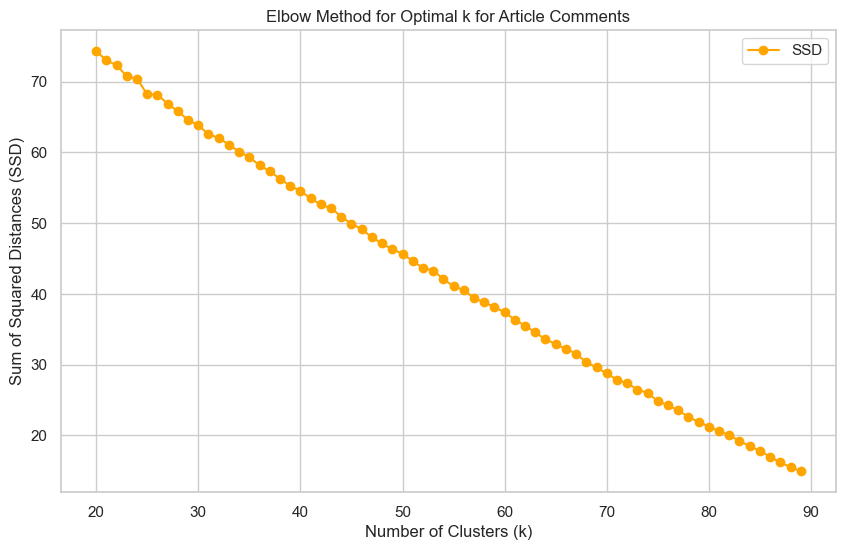

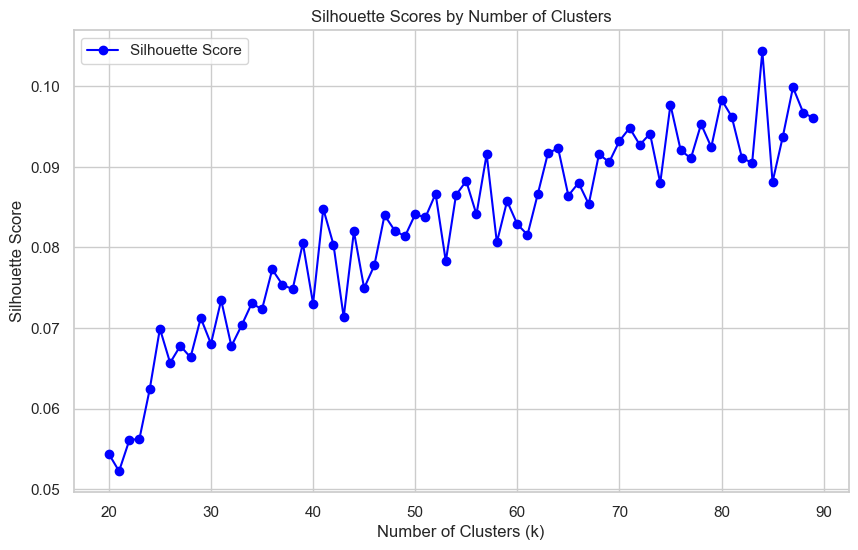

In [53]:
# Initialize TfidfVectorizer with the Greek tokenizer
vectorizer = TfidfVectorizer(tokenizer=greek_tokenizer)
X_topic_comments = vectorizer.fit_transform(topic_extract_concatenated)


k_values = range(20, 90)

calc_kmeans(X_comments, k_values)

In [60]:
lemmatized_topic_GPT = [lemmatize_keywords(keywords) for keywords in topic_extract_GPT_final]

# Concatenate strings within each sublist
lemmatized_topic_concatenated = [' '.join(sublist) for sublist in lemmatized_topic_GPT]

In [61]:
from sklearn.metrics.pairwise import cosine_similarity


X_topic_comments = vectorizer.fit_transform(lemmatized_topic_concatenated)
# Calculate Cosine Similarity
cosine_sim = cosine_similarity(X_topic_comments)

# Apply Thresholding
thresholds = [0.1*i for i in range (1, 6)]
clusters_all_thres = []


for threshold in thresholds:
    clusters = {}
    cluster_id = 0
    for idx, row in enumerate(cosine_sim):
        existing_cluster = next((cluster for cluster, members in clusters.items() if idx in members), None)
        if existing_cluster is not None:
            continue
        clusters[cluster_id] = {idx}
        similar_indices = np.where(row > threshold)[0]
        for i in similar_indices:
            if i != idx:
                clusters[cluster_id].add(i)
        cluster_id += 1
    clusters_all_thres.append(clusters)

# Output clusters
for i, clusters in enumerate(clusters_all_thres):
    threshold = (i+1) * 0.1
    print(f'For threshold {threshold:.1f} the number of topics is: {len(clusters)}')

C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


For threshold 0.1 the number of topics is: 1
For threshold 0.2 the number of topics is: 3
For threshold 0.3 the number of topics is: 14
For threshold 0.4 the number of topics is: 39
For threshold 0.5 the number of topics is: 70


### CONVERT THE RESULTS INTO A LIST

In [206]:
import ast

def extract_array(keywords):
    # Check if ':' is in the string and split accordingly
    if ':' in keywords:
        _, array_string = response_string.split(': ', 1)
    else:
        array_string = keywords

    # Strip any leading/trailing whitespace that might cause issues
    array_string = array_string.strip()

    # Use ast.literal_eval to safely convert string to list
    try:
        result_array = ast.literal_eval(array_string)
    except ValueError as e:
        print("Error evaluating the array:", e)
        return None

    return result_array

print(len(keywords_GPT))
print('------------------------------------------------------------------------------------------------------------')

# Create the final array of keywords of GPT 
keywords_GPT_final = [extract_array(keywords) for keywords in keywords_GPT]
print(keywords_GPT_final[:10])

123
------------------------------------------------------------------------------------------------------------
[['εξέλιξη', 'ενεργά', 'προσφορά', 'εμπειρία', 'παράδειγμα', 'άξιοματικοί', 'μίμηση'], ['ευχάριστη', 'εξέλιξη', 'συνάδελφοι', 'ενέργεια', 'σύνταξη', 'κατηγορία', 'πολίτες'], ['θετικό σχόλιο', 'δικαίωμα', 'εμπειρία', 'προσφορά', 'σύνταξη', 'υπηρεσία', 'ένοπλες δυνάμεις'], ['εξέλιξη', 'ενεργά', 'προσφορά', 'εμπειρία', 'παράδειγμα', 'αξιωματικοί', 'μίμηση'], ['εξέλιξη', 'εμπειρία', 'προσφορά', 'υπηρεσίες', 'δυνατότητα', 'ανθρώπους', 'οικογένειες'], ['πολιτική', 'ηγεσία', 'εμπειρότεροι', 'στελέχη', 'δίκαιο', 'υπηρεσία', 'γνώσεις'], ['προσφορά', 'νέοι', 'άνθρωποι', 'εμπειροί', 'μπράβο', 'εξέλιξη', 'μακάρι'], ['εξέλιξη', 'ενεργός', 'εμπειρία', 'προσφορά', 'συνάδελφοι', 'αποζημίωση', 'κατηγορία'], ['νομοθέτης', 'αξιωματικοί', 'εθνικής καταγωγής', 'υπηρεσία', 'αποστρατεία', 'ηλικία', 'στράτευμα'], ['αποζημίωση', 'καθήκοντα', 'επιδόματα', 'κινδύνου', 'ψυχολογική κατάσταση', 'εξουδετέ

### IMPLEMENT LEMMATIZATION IN THE KEYWORDS

In [18]:
import spacy

nlp = spacy.load('el_core_news_sm')

def lemmatize_keywords(keywords):
    """
    Lemmatize a list of keywords
    :param keywords: list of tokenized words
    :return: list of lemmatized tokens
    """
    doc = nlp(" ".join(keywords)) 
    return [token.lemma_ for token in doc]


# Lemmatize the keywords
lemmatized_GPT = [lemmatize_keywords(keywords) for keywords in keywords_GPT_final]

In [208]:
print(lemmatized_GPT[121])

['σχέδιο', 'νόμος', 'παράταση', 'εργασιακός', 'βίος', 'αλλαγή', 'ασφαλιστικός', 'κοινωνικός', 'δικαιοσύνη', 'αποστράτευση']


### FREQUENCY DISTRIBUTION FOR GPT KEYWORD EXTRACTION

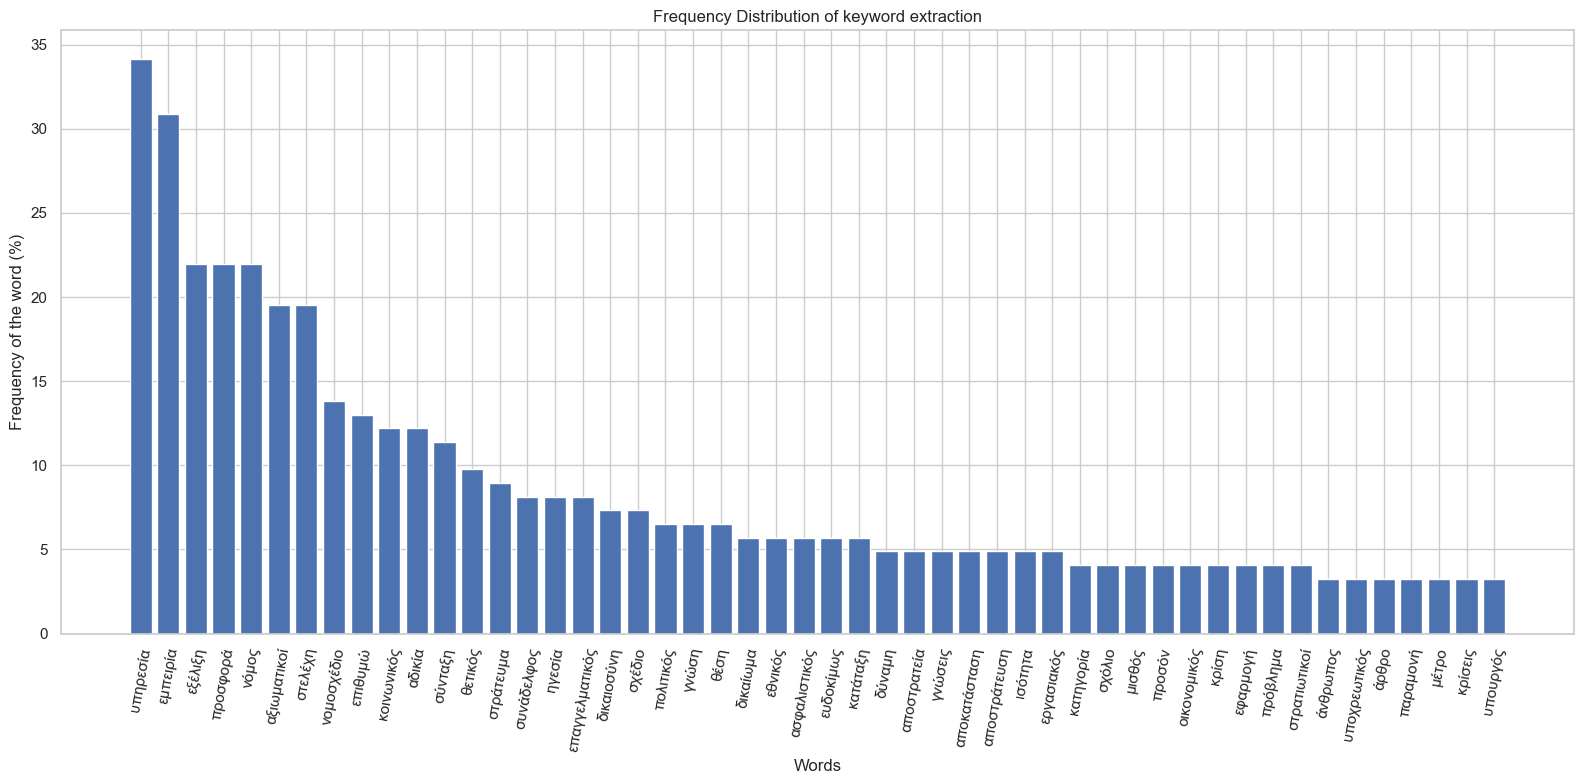

In [209]:
from collections import Counter

joined_keywords_GPT = [word.lower() for sublist in lemmatized_GPT for word in sublist]

# Counting the frequency of each keyword
keyword_GPT_frequency = Counter(joined_keywords_GPT)
most_common_keyword_50 = keyword_GPT_frequency.most_common(50)

def plot_most_common_keywords(most_common_words):
    """
    Calculate the most common token in an article in our dataset
    :param most_common_words: Counter for words (strings)
    :return: plot of the most common words
    """
    # Figure and plot size
    fig = plt.figure(figsize=(16, 8))
    
    # Plot the most frequent stopwords
    plt.bar([word for word, count in most_common_words], [100*count/len(lemmatized_GPT) for word, count in most_common_words])
    plt.xlabel('Words')
    plt.ylabel('Frequency of the word (%)')
    plt.title('Frequency Distribution of keyword extraction')
    plt.xticks(rotation=80)

    plt.tight_layout()
    plt.show()     


plot_most_common_keywords(most_common_keyword_50)


### IMPLEMENT COSINE SIMILARITY WITH THRESHOLDING FOR THE KEYWORDS

In [168]:
print(lemmatized_GPT[1])
print(lemmatized_GPT[121])

['ευχάριστη', 'εξέλιξη', 'συναδέλφος', 'κλείσει', 'ενέργεια', 'στόματα', 'πολίτης']
['προτεινόμενος', 'νόμος', 'σχέδιο', 'εργασιακός', 'βίος', 'συνταξιοδοτικός', 'εθνικός', 'ωφέλιμο', 'αποζημίωσης', 'κοινωνικός', 'δικαιοσύνη']


In [335]:
import numpy as np
from pprint import pprint


# Convert each sublist of comments into a single string
vectorized_lemmatized_GPT_comments = [" ".join(doc) for doc in lemmatized_GPT]

X_keyword_comments = vectorizer.fit_transform(vectorized_lemmatized_GPT_comments)

# Calculate Cosine Similarity
cosine_sim = cosine_similarity(X_keyword_comments)

# Apply Thresholding
thresholds = [0.1*i for i in range (1, 6)]
clusters_all_thres = []


for threshold in thresholds:
    clusters = {}
    cluster_id = 0
    for idx, row in enumerate(cosine_sim):
        existing_cluster = next((cluster for cluster, members in clusters.items() if idx in members), None)
        if existing_cluster is not None:
            continue
        clusters[cluster_id] = {idx}
        similar_indices = np.where(row > threshold)[0]
        for i in similar_indices:
            if i != idx:
                clusters[cluster_id].add(i)
        cluster_id += 1
    clusters_all_thres.append(clusters)

# Output clusters
for i, clusters in enumerate(clusters_all_thres):
    threshold = (i+1) * 0.1
    print(f'For threshold {threshold:.1f} the number of topics is: {len(clusters)}')

C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


For threshold 0.1 the number of topics is: 27
For threshold 0.2 the number of topics is: 55
For threshold 0.3 the number of topics is: 85
For threshold 0.4 the number of topics is: 101
For threshold 0.5 the number of topics is: 107


### KEYWORD EXTRACTION VIA TEXT RANK ALGORITHM (BASED ON PAGERANK)

In [14]:
# Install the required libraries if you haven't already
# !pip install nltk networkx

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import networkx as nx

# Make sure you have downloaded the Greek stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

# Function to preprocess text for Greek
def preprocess_text_greek(text):
    # Tokenize text into sentences
    sentences = sent_tokenize(text, language='greek')
    
    # Tokenize each sentence into words
    words = [word_tokenize(sentence) for sentence in sentences]
    
    # Remove stopwords and punctuation, and convert to lowercase
    stopwords_gr = set(stopwords.words('greek'))
    punctuation = set(string.punctuation)
    processed_words = []
    for word_list in words:
        filtered_words = [word.lower() for word in word_list if word.lower() not in stopwords_gr and word.lower() not in punctuation]
        processed_words.append(filtered_words)
    
    return processed_words

# Function to build a graph of words and their similarities for Greek
def build_graph_greek(words):
    G = nx.Graph()
    G.add_nodes_from(words)
    
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            similarity = word_similarity_greek(words[i], words[j])
            if similarity > 0:
                G.add_edge(words[i], words[j], weight=similarity)
    
    return G

# Function to calculate similarity between Greek words using a simple method
def word_similarity_greek(word1, word2):
    # Simple method: If words have at least one common character, they are considered similar
    if any(char in word2 for char in word1):
        return 1
    else:
        return 0

# Function to extract keywords using TextRank algorithm for Greek
def textrank_keywords_greek(text, num_keywords=5):
    # Preprocess text
    processed_words = preprocess_text_greek(text)
    
    # Flatten the list of words
    words = [word for sublist in processed_words for word in sublist]
    
    # Build the graph of words and their similarities
    G = build_graph_greek(words)
    
    # Calculate PageRank scores
    scores = nx.pagerank(G)
    
    # Sort the words by their PageRank scores and extract the top keywords
    keywords = sorted(scores, key=scores.get, reverse=True)[:num_keywords]
    
    return keywords

keywords_textrank = []

for i in tqdm(range(1, 10)):
    comment = df_74_01.iloc[i]['comments_with_stopwords']
    # Extract keywords for Greek text
    keywords_textrank.append(textrank_keywords_greek(comment))


print("Keywords of comments:", keywords_textrank)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.37it/s]

Keywords of comments: [['συναδέλφους', 'κλείσει', 'ενέργεια', 'ευχάριστη', 'φεύγουμε'], ['συνάδελφοι', 'υπηρεσίας', 'μεγαλύτερη', 'δυνάμεις', 'ένοπλες'], ['οπωσδήποτε', 'συναδέλφους', 'μεταδίδουν', 'αλεξίπτωτο', 'καταδύσεις'], ['35ετιας', 'εργάζονται', 'αντικείμενο', 'συναδέλφους', 'αποτελεί'], ['επιτέλους', 'εμπειρότερων', 'εδ.έτσι', 'λαμβάνοντας', 'υπηρεσία'], ['μπραβο', 'νεοι', 'ανθρωποι-εμπειροι', 'μακαρι', 'μπορουμε'], ['εξουδετέρωσεις', 'συναδέλφους', 'επιδόματα', 'ανελλιπώς', 'συνάδελφοι'], ['32', 'αξιωματικους', 'εισήλθαν', 'αποστρατευονται', 'προβλέψει'], ['εξουδετέρωσεις', 'ανελλιπώς', 'επιδόματα', 'τουλάχιστον', 'λαμβάνουν']]


## IMPLEMENTATION OF KMEANS FOR ALL THE COMMENTS

C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


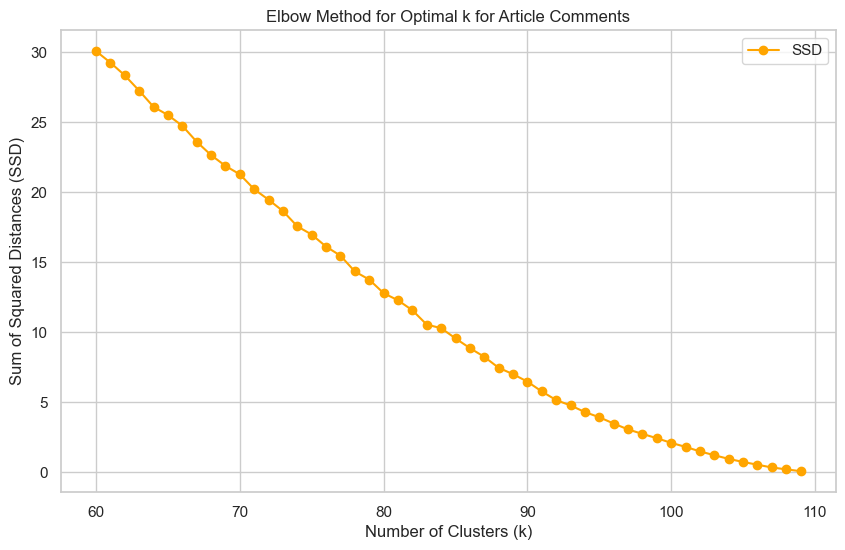

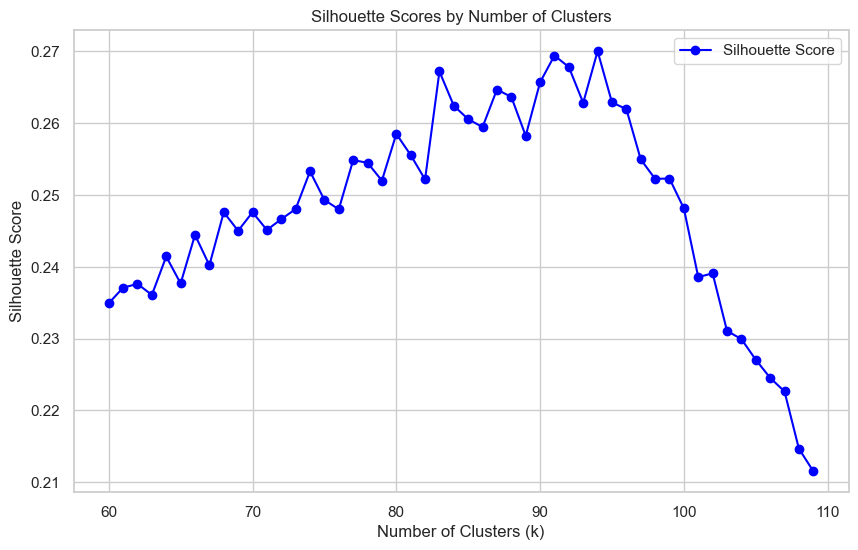

In [24]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def greek_tokenizer(document):
    """
    Tokenizer who removes punctuation
    :param document: string which is a text
    :return: tokenized text
    """
    return [token.text for token in nlp(document) if not token.is_space]


# Assuming df_74_01['comments_no_stopwords'] contains the preprocessed comments
all_comments = df_74_01['comments_with_stopwords'].tolist()

# Initialize TfidfVectorizer with the Greek tokenizer
vectorizer = TfidfVectorizer(tokenizer=greek_tokenizer)
X_comments = vectorizer.fit_transform(all_comments)


k_values = range(60, 110)

def calc_kmeans(X, k_values):
    """
    Plot the elbow and silhouettes scores
    in order to find the optimal k
    :param X: TF-IDF vectorized texts
    :param k_values: list of hyperparameter k values
    :return: two plots (silhoutette and elbo scores)
    """
    ssd_comments = []
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        ssd_comments.append(kmeans.inertia_)
        # Compute the silhouette score
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plotting the Elbow Curve
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, ssd_comments, marker='o', color='orange', label='SSD')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (SSD)')
    plt.title('Elbow Method for Optimal k for Article Comments')
    plt.legend()

    # Plotting the Silhouette Score
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', color='blue', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores by Number of Clusters')
    plt.legend()

    plt.show()

# PLot the elbow and silhouette scores for all the comments
calc_kmeans(X_comments, k_values)

## IMPLEMENTATION OF KMEANS FOR ALL THE KEYWORDS

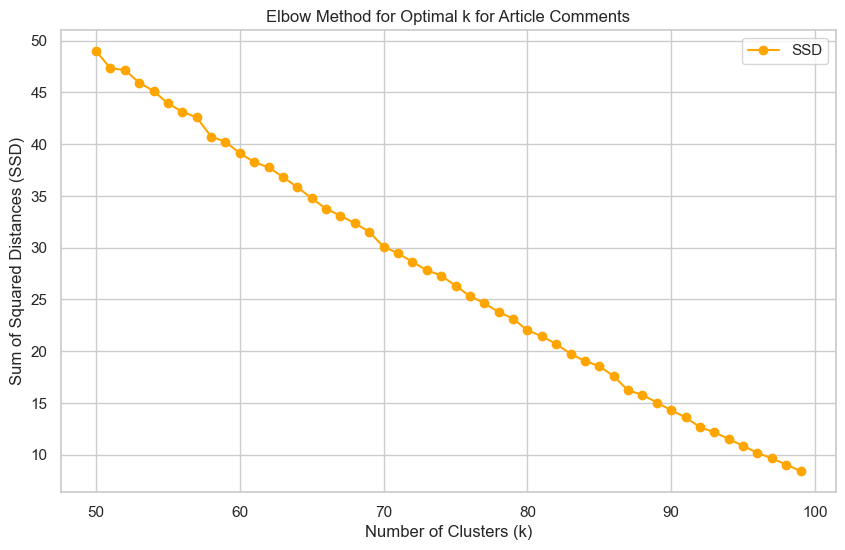

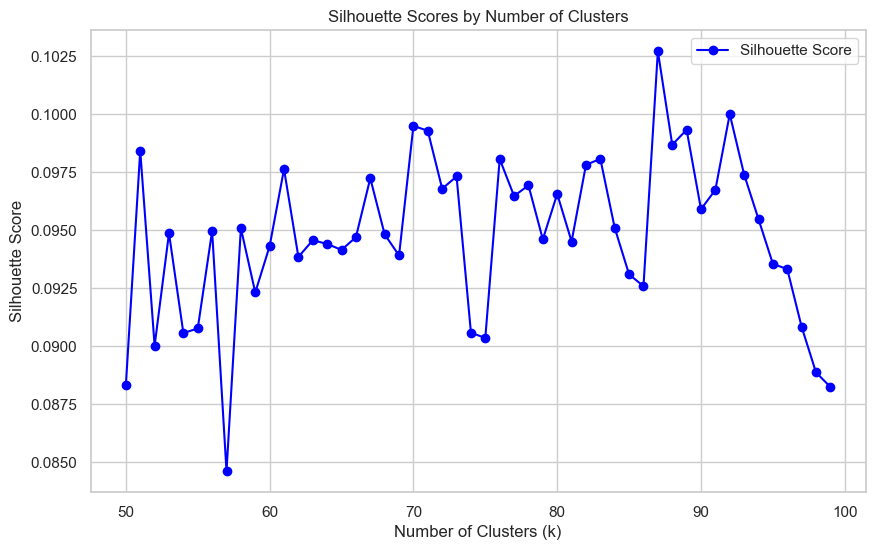

In [234]:
k_values = range(50, 100)
calc_kmeans(X_keyword_comments, k_values)

## STORE THE RESULTS IN A .CSV FILE

In [307]:
# Save all the work in a .csv
results_dict =  {
    'summarized_comments_independent': summary_each_12_unclustered_independent,
    'summarized_comments_connected' : summary_each_12_unclustered,
    'summarized_comments_classified' : classified_summaries,
    'keywords_GPT': keywords_GPT_final,
    'keywords_textrank': keywords_textrank,
    'final_summary_independent': final_summary_74_01_independent,
    'final_summary_connected': final_summary_74_01_previous_connected,
    'final_summary_classified' : final_summary_74_01_classified
}

# Find the maximum length among all the lists
max_length = max(len(lst) for lst in results_dict.values())

# Pad lists with NaN to make them equal length
for key, value in results_dict.items():
    if isinstance(value, list):
        results_dict[key] = value + [np.nan] * (max_length - len(value))
    else:
        results_dict[key] = [value] + [np.nan] * (max_length - 1)

# Create DataFrame
results_df = pd.DataFrame(results_dict)

results_df.to_csv('data/summarization_results.csv', index=False)

In [334]:
# Read the csv to check the stored data
example_df = pd.read_csv('data/summarization_results.csv')

print(example_df.columns.to_list())

['summarized_comments_independent', 'summarized_comments_connected', 'summarized_comments_classified', 'keywords_GPT', 'keywords_textrank', 'final_summary_independent', 'final_summary_connected', 'final_summary_classified']


In [333]:
# Print an example of the .csv file
print(example_df.iloc[0]['summarized_comments_classified'])

Το συγκεκριμένο άρθρο φέρνει στο προσκήνιο την αναγκαιότητα και τη θετική υποδοχή της επέκτασης της ενεργής υπηρεσίας στελεχών των ενόπλων δυνάμεων μετά την πλήρωση των 35 ετών υπηρεσίας. Συγκεκριμένα, επισημαίνεται η σημασία της προσφοράς των εμπειρότερων στελεχών, καθώς η συνεχιζόμενη παρουσία τους εκτιμάται ως καθοριστική για τη διατήρηση και ενίσχυση της ετοιμότητας και της αποτελεσματικότητας των ενόπλων δυνάμεων. Η πολιτική ηγεσία αναγνωρίζει την αξία της εμπειρίας και των γνώσεων τους, παρέχοντας ευελιξία και δίνοντας τη δυνατότητα για παράταση του εργασιακού τους βίου σε ένα πιο παραγωγικό στάδιο της ζωής τους.

Η αλλαγή αυτή συναντά ευρεία αποδοχή και θεωρείται επιθυμητή από μεγάλο μέρος του στρατιωτικού προσωπικού, καθώς πολλοί από τους συναδέλφους τους έχουν εκφράσει την επιθυμία να συνεχίσουν την προσφορά τους. Κρίνεται επίσης ότι αποτελεί δίκαιη αντιμετώπιση για εκείνα τα στελέχη που δεν έλαβαν την ευκαιρία να παραμείνουν ενεργά λόγω προηγούμενων νομοθετικών περιορισμών. Μ

## USE OF MELTEMI - EXPERIMENTS

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [8]:
model = AutoModelForCausalLM.from_pretrained("ilsp/Meltemi-7B-Instruct-v1")
tokenizer = AutoTokenizer.from_pretrained("ilsp/Meltemi-7B-Instruct-v1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [259]:
import torch
torch.cuda.empty_cache()

# device = 'cpu'
# model.to(device)

In [18]:
messages = [
    {"role": "system", "content": "Είσαι το Μελτέμι, ένα γλωσσικό μοντέλο για την ελληνική γλώσσα. Είσαι ιδιαίτερα βοηθητικό προς την χρήστρια ή τον χρήστη και δίνεις σύντομες αλλά επαρκώς περιεκτικές απαντήσεις. Απάντα με προσοχή, ευγένεια, αμεροληψία, ειλικρίνεια και σεβασμό προς την χρήστρια ή τον χρήστη."},
    {"role": "user", "content": "Πες μου αν έχεις συνείδηση."},
]

prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
input_prompt = tokenizer(prompt, return_tensors='pt').to(device)
outputs = model.generate(input_prompt['input_ids'], max_new_tokens=256, do_sample=True)

print(tokenizer.batch_decode(outputs)[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> <|system|>
Είσαι το Μελτέμι, ένα γλωσσικό μοντέλο για την ελληνική γλώσσα. Είσαι ιδιαίτερα βοηθητικό προς την χρήστρια ή τον χρήστη και δίνεις σύντομες αλλά επαρκώς περιεκτικές απαντήσεις. Απάντα με προσοχή, ευγένεια, αμεροληψία, ειλικρίνεια και σεβασμό προς την χρήστρια ή τον χρήστη.</s> 
<|user|>
Πες μου αν έχεις συνείδηση.</s> 
<|assistant|>
Είναι δυνατό για έναν άνθρωπο να βιώσει τη συνείδηση;</s>


### RESULTS OF MELTEMI

If we want to use CUDA for MELTEMI model we must posses a 16gb VRAM (discussed in HuggingFace)